# Coursework 2 - PyTorch based experiment framework

## Intro
Welcome to the coursework 2 PyTorch experiment framework. Pytorch is a  modern, intuitive, highly Pythonic and very fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, so PyTorch is a great framework to use, if you want to build  complicated deep networks fairly easily.

## MLP package vs Pytorch
**Student**: So, why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Well, Pytorch is everything the MLP package is, but faster, cleaner and far more resourceful. Since it is one of the main deep learning frameworks being used by industry and research alike, it has been fine-tuned quite a bit, to conform to the expectation of researchers and engineers alike. What this means, is that PyTorch is now a very robust and highly flexible package, that you can use for any project you want to work on in the future, if it involves trainining differentiable graphs. 

In addition, MLP is written in NumPy and your time working on it has taught some low level details of NNs; PyTorch was written to look as much as possible to NumPy, so it will feel very familiar to you. The skills you have acquired are highly transferable (that is, they generalize well, so not much overfitting there...). 

PyTorch will almost always have all the latest and greatest implemented in it as soon as they are released as papers, and if not, give it a week or two and someone will reproduce it. If you can't wait, you can reproduce it yourself and open source it. A great way to show your skills and get github likes. 

In addition PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? We did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. It allowed you to delve deep into how one can go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually have. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

In addition, by trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 

**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work... as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself. 


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```mlp/pytorch_experiment_scripts```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

In [1]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False,stride=1):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        self.stride = stride
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape))  # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,stride=self.stride,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.relu(out)  # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution':  # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # use strided conv to get an output
                out = F.relu(out)  # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)
        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print('shape before final linear layer', out.shape)
        out = out.view(out.shape[0], -1)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers):  # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.relu(out)  # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # pass previous outputs through a strided convolution indexed i
                out = F.relu(out)  # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.logit_linear_layer(out)  # pass through a linear layer to get logits/preds
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logit_linear_layer.reset_parameters()

In [4]:
import time
from mlp.pytorch_experiment_scripts.storage_utils import save_statistics
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu: # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda') # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0" # sets the main GPU to be the one at index 0
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu') # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device) # sends the model from the cpu to the gpu
        self.model.reset_parameters() # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.
        self.totalTime = 0
        if not os.path.exists(self.experiment_folder): # If experiment directory does not exist
            os.mkdir(self.experiment_folder) # create the experiment directory
            os.mkdir(self.experiment_logs) # create the experiment log directory
            os.mkdir(self.experiment_saved_models) # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device) # send the loss computation to the GPU

        if continue_from_epoch != -1: # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch) # reload existing model from epoch and return best val model index
                                             # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train() # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # send data to device as torch tensors
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(input=out, target=y) # compute loss

        self.optimizer.zero_grad() # set all weight grads from previous training iters to 0
        loss.backward() # backpropagate to compute gradients for current iter loss

        self.optimizer.step() # update network parameters
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval() # sets the system to validation mode
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(out, y) # compute loss
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        state = dict()
        state['network'] = self.state_dict() # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx)))) # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []} # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train: # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data): # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y) # take a training iter step
                    current_epoch_losses["train_loss"].append(loss) # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy) # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val: # create a progress bar for validation
                for x, y in self.val_data: # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y) # run a validation iter
                    current_epoch_losses["val_loss"].append(loss) # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy) # add current iter acc to val acc lst.
                    pbar_val.update(1) # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            if np.mean(current_epoch_losses['val_acc']) > self.best_val_model_acc: # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = np.mean(current_epoch_losses['val_acc']) # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(value)) # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i) # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time # calculate time taken for epoch
            self.totalTime += epoch_elapsed_time
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            seconds = self.totalTime
            m, s = divmod(seconds, 60)
            print('total time{} : {}'.format(m,s))
            self.save_model(model_save_dir=self.experiment_saved_models, # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx, # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []} # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test: # ini a progress bar
            for x, y in self.test_data: # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x, y=y) # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss) # save test loss
                current_epoch_losses["test_acc"].append(accuracy) # save test accuracy
                pbar_test.update(1) # update progress bar status
                pbar_test.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in current_epoch_losses.items()} # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv', # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6590199240>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f653db57d30>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f653db57d68>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


  0%|          | 0/1000 [00:00<?, ?it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 2.4486, accuracy: 0.3900: 100%|██████████| 158/158 [00:01<00:00, 130.42it/s]


Epoch 0: train_acc_0.2255_train_loss_2.9600_val_acc_0.3499_val_loss_2.4988 epoch time 13.3773 seconds
total time0.0 : 13.377266645431519


loss: 2.1499, accuracy: 0.4200:   2%|▏         | 17/1000 [00:00<00:10, 91.37it/s]

Epoch 1: train_acc_0.4256_train_loss_2.2059_val_acc_0.5134_val_loss_1.9163 epoch time 13.0133 seconds
total time0.0 : 26.390576601028442


loss: 1.5624, accuracy: 0.5700:   2%|▏         | 18/1000 [00:00<00:10, 94.60it/s]

Epoch 2: train_acc_0.5591_train_loss_1.7101_val_acc_0.6001_val_loss_1.5141 epoch time 12.9819 seconds
total time0.0 : 39.372520446777344


loss: 1.2596, accuracy: 0.6300:   2%|▏         | 17/1000 [00:00<00:10, 90.35it/s]

Epoch 3: train_acc_0.6278_train_loss_1.3960_val_acc_0.6492_val_loss_1.2807 epoch time 12.9693 seconds
total time0.0 : 52.34177756309509


loss: 1.1722, accuracy: 0.6700:   2%|▏         | 18/1000 [00:00<00:10, 95.44it/s]

Epoch 4: train_acc_0.6608_train_loss_1.2216_val_acc_0.6775_val_loss_1.1490 epoch time 12.9605 seconds
total time1.0 : 5.302255868911743


loss: 1.0249, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 93.55it/s]

Epoch 5: train_acc_0.6809_train_loss_1.1220_val_acc_0.6927_val_loss_1.0730 epoch time 12.9582 seconds
total time1.0 : 18.260449647903442


loss: 1.4229, accuracy: 0.5600:   2%|▏         | 17/1000 [00:00<00:10, 91.53it/s]

Epoch 6: train_acc_0.6928_train_loss_1.0586_val_acc_0.7013_val_loss_1.0220 epoch time 13.0086 seconds
total time1.0 : 31.269070863723755


loss: 1.1275, accuracy: 0.6800:   2%|▏         | 18/1000 [00:00<00:10, 94.45it/s]

Epoch 7: train_acc_0.7000_train_loss_1.0174_val_acc_0.7065_val_loss_0.9904 epoch time 12.7792 seconds
total time1.0 : 44.04822087287903


loss: 1.0705, accuracy: 0.6900:   2%|▏         | 18/1000 [00:00<00:10, 97.79it/s]

Epoch 8: train_acc_0.7071_train_loss_0.9869_val_acc_0.7120_val_loss_0.9674 epoch time 12.6584 seconds
total time1.0 : 56.70664119720459


loss: 0.9256, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 94.22it/s]

Epoch 9: train_acc_0.7110_train_loss_0.9642_val_acc_0.7132_val_loss_0.9484 epoch time 13.0007 seconds
total time2.0 : 9.707325458526611


loss: 0.9487, accuracy: 0.7000:   2%|▏         | 19/1000 [00:00<00:10, 97.07it/s]

Epoch 10: train_acc_0.7160_train_loss_0.9457_val_acc_0.7239_val_loss_0.9224 epoch time 13.0564 seconds
total time2.0 : 22.763688564300537


loss: 0.8627, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 91.87it/s]

Epoch 11: train_acc_0.7184_train_loss_0.9315_val_acc_0.7229_val_loss_0.9157 epoch time 12.9673 seconds
total time2.0 : 35.730952501297


loss: 0.9403, accuracy: 0.7200:   2%|▏         | 18/1000 [00:00<00:10, 93.49it/s]

Epoch 12: train_acc_0.7225_train_loss_0.9186_val_acc_0.7266_val_loss_0.9090 epoch time 12.9967 seconds
total time2.0 : 48.727630853652954


loss: 0.7249, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 94.35it/s]

Epoch 13: train_acc_0.7253_train_loss_0.9084_val_acc_0.7346_val_loss_0.8924 epoch time 12.9267 seconds
total time3.0 : 1.6543009281158447


loss: 0.8662, accuracy: 0.7000:   2%|▏         | 18/1000 [00:00<00:10, 92.72it/s]

Epoch 14: train_acc_0.7272_train_loss_0.8998_val_acc_0.7324_val_loss_0.8839 epoch time 12.6979 seconds
total time3.0 : 14.35217547416687


loss: 0.9466, accuracy: 0.6900:   2%|▏         | 18/1000 [00:00<00:10, 95.87it/s]

Epoch 15: train_acc_0.7294_train_loss_0.8923_val_acc_0.7307_val_loss_0.8836 epoch time 13.0072 seconds
total time3.0 : 27.359339475631714


loss: 0.9979, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 93.24it/s]

Epoch 16: train_acc_0.7307_train_loss_0.8847_val_acc_0.7351_val_loss_0.8767 epoch time 13.0784 seconds
total time3.0 : 40.43770670890808


loss: 0.7684, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 93.91it/s]

Epoch 17: train_acc_0.7325_train_loss_0.8773_val_acc_0.7328_val_loss_0.8713 epoch time 12.9666 seconds
total time3.0 : 53.40435290336609


loss: 0.9087, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 91.53it/s]

Epoch 18: train_acc_0.7349_train_loss_0.8703_val_acc_0.7378_val_loss_0.8571 epoch time 12.9972 seconds
total time4.0 : 6.401514530181885


loss: 0.6805, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 95.03it/s]

Epoch 19: train_acc_0.7361_train_loss_0.8655_val_acc_0.7358_val_loss_0.8586 epoch time 12.9615 seconds
total time4.0 : 19.36299443244934


loss: 0.8395, accuracy: 0.7000:   2%|▏         | 17/1000 [00:00<00:10, 92.30it/s]

Epoch 20: train_acc_0.7365_train_loss_0.8605_val_acc_0.7441_val_loss_0.8522 epoch time 12.9617 seconds
total time4.0 : 32.32466506958008


loss: 0.5690, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 93.75it/s]

Epoch 21: train_acc_0.7387_train_loss_0.8545_val_acc_0.7426_val_loss_0.8449 epoch time 13.0278 seconds
total time4.0 : 45.352511405944824


loss: 0.6713, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 93.41it/s]

Epoch 22: train_acc_0.7409_train_loss_0.8485_val_acc_0.7427_val_loss_0.8410 epoch time 12.9459 seconds
total time4.0 : 58.29843020439148


loss: 0.7482, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 96.44it/s]

Epoch 23: train_acc_0.7421_train_loss_0.8451_val_acc_0.7448_val_loss_0.8344 epoch time 13.0284 seconds
total time5.0 : 11.326847553253174


loss: 0.9520, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:10, 92.53it/s]

Epoch 24: train_acc_0.7442_train_loss_0.8394_val_acc_0.7446_val_loss_0.8320 epoch time 12.9879 seconds
total time5.0 : 24.314775943756104


loss: 1.0408, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 93.46it/s]

Epoch 25: train_acc_0.7446_train_loss_0.8351_val_acc_0.7452_val_loss_0.8346 epoch time 13.0543 seconds
total time5.0 : 37.36908745765686


loss: 0.8398, accuracy: 0.6900:   2%|▏         | 18/1000 [00:00<00:10, 94.11it/s]

Epoch 26: train_acc_0.7453_train_loss_0.8321_val_acc_0.7472_val_loss_0.8221 epoch time 12.9926 seconds
total time5.0 : 50.36171007156372


loss: 0.8175, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 93.23it/s]

Epoch 27: train_acc_0.7464_train_loss_0.8271_val_acc_0.7433_val_loss_0.8264 epoch time 12.9959 seconds
total time6.0 : 3.357640027999878


loss: 0.7869, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 95.13it/s]

Epoch 28: train_acc_0.7479_train_loss_0.8232_val_acc_0.7484_val_loss_0.8187 epoch time 12.9461 seconds
total time6.0 : 16.303728342056274


loss: 0.6669, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 92.36it/s]

Epoch 29: train_acc_0.7487_train_loss_0.8185_val_acc_0.7498_val_loss_0.8162 epoch time 13.0609 seconds
total time6.0 : 29.364582300186157


loss: 0.9008, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 90.97it/s]

Epoch 30: train_acc_0.7502_train_loss_0.8142_val_acc_0.7503_val_loss_0.8219 epoch time 13.0237 seconds
total time6.0 : 42.38829803466797


loss: 0.6206, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 96.59it/s]

Epoch 31: train_acc_0.7515_train_loss_0.8105_val_acc_0.7551_val_loss_0.8064 epoch time 12.7289 seconds
total time6.0 : 55.117162227630615


loss: 0.6334, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 93.12it/s]

Epoch 32: train_acc_0.7522_train_loss_0.8063_val_acc_0.7544_val_loss_0.8002 epoch time 12.7038 seconds
total time7.0 : 7.820920705795288


loss: 0.8101, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 92.34it/s]

Epoch 33: train_acc_0.7545_train_loss_0.8028_val_acc_0.7560_val_loss_0.7943 epoch time 12.8975 seconds
total time7.0 : 20.718446016311646


loss: 0.7636, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 91.63it/s]

Epoch 34: train_acc_0.7541_train_loss_0.7988_val_acc_0.7572_val_loss_0.7969 epoch time 12.9892 seconds
total time7.0 : 33.70767164230347


loss: 0.4955, accuracy: 0.8200:   2%|▏         | 17/1000 [00:00<00:10, 89.70it/s]

Epoch 35: train_acc_0.7564_train_loss_0.7955_val_acc_0.7587_val_loss_0.7885 epoch time 13.0381 seconds
total time7.0 : 46.745789527893066


loss: 0.7453, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 97.97it/s]

Epoch 36: train_acc_0.7560_train_loss_0.7924_val_acc_0.7579_val_loss_0.7906 epoch time 12.9826 seconds
total time7.0 : 59.72834014892578


loss: 0.6675, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 94.73it/s]

Epoch 37: train_acc_0.7588_train_loss_0.7891_val_acc_0.7607_val_loss_0.7884 epoch time 13.0460 seconds
total time8.0 : 12.774334192276001


loss: 0.6888, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 93.68it/s]

Epoch 38: train_acc_0.7598_train_loss_0.7847_val_acc_0.7633_val_loss_0.7779 epoch time 12.7521 seconds
total time8.0 : 25.526415586471558


loss: 0.7182, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 90.31it/s]

Epoch 39: train_acc_0.7603_train_loss_0.7815_val_acc_0.7561_val_loss_0.7821 epoch time 13.0362 seconds
total time8.0 : 38.56258845329285


loss: 0.6379, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 93.64it/s]

Epoch 40: train_acc_0.7612_train_loss_0.7779_val_acc_0.7588_val_loss_0.7763 epoch time 12.9696 seconds
total time8.0 : 51.53217601776123


loss: 0.6553, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 92.22it/s]

Epoch 41: train_acc_0.7625_train_loss_0.7735_val_acc_0.7639_val_loss_0.7733 epoch time 12.9405 seconds
total time9.0 : 4.472697496414185


loss: 0.8188, accuracy: 0.6800:   2%|▏         | 18/1000 [00:00<00:10, 95.77it/s]

Epoch 42: train_acc_0.7631_train_loss_0.7717_val_acc_0.7644_val_loss_0.7685 epoch time 13.0299 seconds
total time9.0 : 17.502639055252075


loss: 0.8440, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 91.64it/s]

Epoch 43: train_acc_0.7627_train_loss_0.7683_val_acc_0.7623_val_loss_0.7690 epoch time 12.9504 seconds
total time9.0 : 30.45299243927002


loss: 0.6799, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 92.04it/s]

Epoch 44: train_acc_0.7649_train_loss_0.7648_val_acc_0.7645_val_loss_0.7653 epoch time 12.8990 seconds
total time9.0 : 43.35199165344238


loss: 0.5416, accuracy: 0.8100:   2%|▏         | 17/1000 [00:00<00:10, 91.86it/s]

Epoch 45: train_acc_0.7652_train_loss_0.7606_val_acc_0.7697_val_loss_0.7536 epoch time 12.9544 seconds
total time9.0 : 56.306410789489746


loss: 0.7562, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 91.37it/s]

Epoch 46: train_acc_0.7666_train_loss_0.7593_val_acc_0.7678_val_loss_0.7557 epoch time 12.9988 seconds
total time10.0 : 9.30525517463684


loss: 0.5331, accuracy: 0.8900:   2%|▏         | 17/1000 [00:00<00:10, 92.34it/s]

Epoch 47: train_acc_0.7672_train_loss_0.7563_val_acc_0.7673_val_loss_0.7522 epoch time 13.0035 seconds
total time10.0 : 22.308722734451294


loss: 0.9764, accuracy: 0.7200:   2%|▏         | 18/1000 [00:00<00:09, 98.66it/s]

Epoch 48: train_acc_0.7686_train_loss_0.7528_val_acc_0.7683_val_loss_0.7512 epoch time 12.9868 seconds
total time10.0 : 35.295475006103516


loss: 0.7190, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 93.21it/s]

Epoch 49: train_acc_0.7694_train_loss_0.7500_val_acc_0.7689_val_loss_0.7513 epoch time 13.0374 seconds
total time10.0 : 48.332902669906616


loss: 0.8731, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 93.34it/s]

Epoch 50: train_acc_0.7689_train_loss_0.7470_val_acc_0.7720_val_loss_0.7445 epoch time 12.9839 seconds
total time11.0 : 1.3167893886566162


loss: 0.6868, accuracy: 0.8100:   2%|▏         | 18/1000 [00:00<00:10, 92.82it/s]

Epoch 51: train_acc_0.7705_train_loss_0.7441_val_acc_0.7689_val_loss_0.7467 epoch time 12.9485 seconds
total time11.0 : 14.265289068222046


loss: 0.8767, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 91.67it/s]

Epoch 52: train_acc_0.7708_train_loss_0.7417_val_acc_0.7703_val_loss_0.7454 epoch time 12.9720 seconds
total time11.0 : 27.237322092056274


loss: 0.6636, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 94.80it/s]

Epoch 53: train_acc_0.7716_train_loss_0.7386_val_acc_0.7696_val_loss_0.7435 epoch time 13.0208 seconds
total time11.0 : 40.25817012786865


loss: 0.9394, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 94.25it/s]

Epoch 54: train_acc_0.7721_train_loss_0.7363_val_acc_0.7730_val_loss_0.7314 epoch time 12.9521 seconds
total time11.0 : 53.2102632522583


loss: 0.8148, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 94.48it/s]

Epoch 55: train_acc_0.7741_train_loss_0.7331_val_acc_0.7741_val_loss_0.7302 epoch time 12.6571 seconds
total time12.0 : 5.86736798286438


loss: 0.8977, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 97.92it/s]

Epoch 56: train_acc_0.7741_train_loss_0.7309_val_acc_0.7779_val_loss_0.7286 epoch time 12.7474 seconds
total time12.0 : 18.61477780342102


loss: 0.7896, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 92.30it/s]

Epoch 57: train_acc_0.7745_train_loss_0.7279_val_acc_0.7721_val_loss_0.7298 epoch time 12.9607 seconds
total time12.0 : 31.5754337310791


loss: 0.7881, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 94.73it/s]

Epoch 58: train_acc_0.7756_train_loss_0.7258_val_acc_0.7718_val_loss_0.7276 epoch time 12.9472 seconds
total time12.0 : 44.52268028259277


loss: 0.6654, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 93.52it/s]

Epoch 59: train_acc_0.7762_train_loss_0.7230_val_acc_0.7777_val_loss_0.7221 epoch time 12.9605 seconds
total time12.0 : 57.48313856124878


loss: 0.6816, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 93.50it/s]

Epoch 60: train_acc_0.7772_train_loss_0.7210_val_acc_0.7740_val_loss_0.7251 epoch time 13.0110 seconds
total time13.0 : 10.494154691696167


loss: 0.8254, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 91.10it/s]

Epoch 61: train_acc_0.7782_train_loss_0.7187_val_acc_0.7801_val_loss_0.7180 epoch time 12.6924 seconds
total time13.0 : 23.18655252456665


loss: 0.7435, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 91.82it/s]

Epoch 62: train_acc_0.7782_train_loss_0.7160_val_acc_0.7777_val_loss_0.7163 epoch time 13.0144 seconds
total time13.0 : 36.20098400115967


loss: 0.5886, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 91.34it/s]

Epoch 63: train_acc_0.7794_train_loss_0.7130_val_acc_0.7761_val_loss_0.7141 epoch time 12.9446 seconds
total time13.0 : 49.14561653137207


loss: 0.8465, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 91.23it/s]

Epoch 64: train_acc_0.7799_train_loss_0.7112_val_acc_0.7778_val_loss_0.7127 epoch time 12.9287 seconds
total time14.0 : 2.0743234157562256


loss: 0.7986, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 92.25it/s]

Epoch 65: train_acc_0.7813_train_loss_0.7088_val_acc_0.7794_val_loss_0.7107 epoch time 12.9227 seconds
total time14.0 : 14.997039079666138


loss: 0.7105, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 94.08it/s]

Epoch 66: train_acc_0.7816_train_loss_0.7067_val_acc_0.7806_val_loss_0.7055 epoch time 13.0008 seconds
total time14.0 : 27.99783730506897


loss: 0.6011, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 92.65it/s]

Epoch 67: train_acc_0.7820_train_loss_0.7049_val_acc_0.7803_val_loss_0.7069 epoch time 12.9354 seconds
total time14.0 : 40.93326163291931


loss: 0.8588, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 94.26it/s]

Epoch 68: train_acc_0.7822_train_loss_0.7029_val_acc_0.7811_val_loss_0.7073 epoch time 12.9939 seconds
total time14.0 : 53.92712616920471


loss: 0.7038, accuracy: 0.8100:   2%|▏         | 17/1000 [00:00<00:10, 93.02it/s]

Epoch 69: train_acc_0.7830_train_loss_0.7001_val_acc_0.7803_val_loss_0.7017 epoch time 13.0255 seconds
total time15.0 : 6.952645540237427


loss: 0.6160, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 96.42it/s]

Epoch 70: train_acc_0.7833_train_loss_0.6978_val_acc_0.7846_val_loss_0.6954 epoch time 13.0058 seconds
total time15.0 : 19.958494424819946


loss: 0.7708, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 92.86it/s]

Epoch 71: train_acc_0.7843_train_loss_0.6961_val_acc_0.7851_val_loss_0.6947 epoch time 13.0168 seconds
total time15.0 : 32.9752893447876


loss: 0.8842, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 91.26it/s]

Epoch 72: train_acc_0.7851_train_loss_0.6931_val_acc_0.7851_val_loss_0.6942 epoch time 13.0037 seconds
total time15.0 : 45.978976011276245


loss: 0.8582, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 96.11it/s]

Epoch 73: train_acc_0.7855_train_loss_0.6916_val_acc_0.7806_val_loss_0.6942 epoch time 12.9691 seconds
total time15.0 : 58.948081970214844


loss: 0.8905, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 94.47it/s]

Epoch 74: train_acc_0.7857_train_loss_0.6896_val_acc_0.7853_val_loss_0.6862 epoch time 13.0367 seconds
total time16.0 : 11.984791994094849


loss: 0.8281, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 94.46it/s]

Epoch 75: train_acc_0.7867_train_loss_0.6869_val_acc_0.7856_val_loss_0.6939 epoch time 13.0121 seconds
total time16.0 : 24.99686574935913


loss: 0.8048, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 92.44it/s]

Epoch 76: train_acc_0.7879_train_loss_0.6850_val_acc_0.7885_val_loss_0.6879 epoch time 13.0479 seconds
total time16.0 : 38.04479622840881


loss: 0.5384, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 91.36it/s]

Epoch 77: train_acc_0.7882_train_loss_0.6836_val_acc_0.7859_val_loss_0.6855 epoch time 12.9107 seconds
total time16.0 : 50.95553469657898


loss: 0.8879, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 93.60it/s]

Epoch 78: train_acc_0.7887_train_loss_0.6819_val_acc_0.7866_val_loss_0.6853 epoch time 12.9817 seconds
total time17.0 : 3.9372003078460693


loss: 0.6063, accuracy: 0.8100:   2%|▏         | 18/1000 [00:00<00:10, 97.97it/s]

Epoch 79: train_acc_0.7881_train_loss_0.6802_val_acc_0.7875_val_loss_0.6815 epoch time 12.6869 seconds
total time17.0 : 16.624080419540405


loss: 0.6840, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 91.63it/s]

Epoch 80: train_acc_0.7906_train_loss_0.6774_val_acc_0.7867_val_loss_0.6782 epoch time 12.7726 seconds
total time17.0 : 29.396647214889526


loss: 0.7138, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 90.56it/s]

Epoch 81: train_acc_0.7902_train_loss_0.6760_val_acc_0.7879_val_loss_0.6757 epoch time 12.9451 seconds
total time17.0 : 42.3417911529541


loss: 0.6439, accuracy: 0.8300:   2%|▏         | 17/1000 [00:00<00:10, 89.50it/s]

Epoch 82: train_acc_0.7904_train_loss_0.6745_val_acc_0.7889_val_loss_0.6725 epoch time 13.0486 seconds
total time17.0 : 55.3903865814209


loss: 0.6666, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 94.89it/s]

Epoch 83: train_acc_0.7915_train_loss_0.6725_val_acc_0.7898_val_loss_0.6783 epoch time 13.0304 seconds
total time18.0 : 8.420751333236694


loss: 0.5095, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 94.48it/s]

Epoch 84: train_acc_0.7923_train_loss_0.6710_val_acc_0.7885_val_loss_0.6748 epoch time 12.9322 seconds
total time18.0 : 21.35291337966919


loss: 0.7529, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 95.40it/s]

Epoch 85: train_acc_0.7915_train_loss_0.6697_val_acc_0.7882_val_loss_0.6719 epoch time 12.7319 seconds
total time18.0 : 34.08476901054382


loss: 0.4254, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 96.02it/s]

Epoch 86: train_acc_0.7926_train_loss_0.6676_val_acc_0.7892_val_loss_0.6760 epoch time 12.9054 seconds
total time18.0 : 46.990139961242676


loss: 0.7668, accuracy: 0.7400:   2%|▏         | 18/1000 [00:00<00:10, 93.02it/s]

Epoch 87: train_acc_0.7928_train_loss_0.6662_val_acc_0.7908_val_loss_0.6725 epoch time 12.6638 seconds
total time18.0 : 59.65394067764282


loss: 0.6277, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 92.62it/s]

Epoch 88: train_acc_0.7935_train_loss_0.6644_val_acc_0.7909_val_loss_0.6670 epoch time 12.7707 seconds
total time19.0 : 12.424674272537231


loss: 0.6782, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 94.24it/s]

Epoch 89: train_acc_0.7951_train_loss_0.6630_val_acc_0.7899_val_loss_0.6646 epoch time 12.7810 seconds
total time19.0 : 25.20571208000183


loss: 0.5911, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 92.19it/s]

Epoch 90: train_acc_0.7948_train_loss_0.6618_val_acc_0.7945_val_loss_0.6602 epoch time 12.9156 seconds
total time19.0 : 38.1212682723999


loss: 0.9412, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 94.39it/s]

Epoch 91: train_acc_0.7953_train_loss_0.6602_val_acc_0.7933_val_loss_0.6593 epoch time 12.9517 seconds
total time19.0 : 51.07292699813843


loss: 0.5326, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 91.09it/s]

Epoch 92: train_acc_0.7953_train_loss_0.6589_val_acc_0.7913_val_loss_0.6629 epoch time 12.9395 seconds
total time20.0 : 4.012461185455322


loss: 0.4550, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 97.68it/s]

Epoch 93: train_acc_0.7958_train_loss_0.6578_val_acc_0.7944_val_loss_0.6596 epoch time 12.9604 seconds
total time20.0 : 16.97282648086548


loss: 0.7557, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 90.95it/s]

Epoch 94: train_acc_0.7951_train_loss_0.6566_val_acc_0.7917_val_loss_0.6599 epoch time 13.0129 seconds
total time20.0 : 29.985764026641846


loss: 0.6024, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 90.30it/s]

Epoch 95: train_acc_0.7974_train_loss_0.6546_val_acc_0.7947_val_loss_0.6528 epoch time 12.9999 seconds
total time20.0 : 42.985679149627686


loss: 0.4825, accuracy: 0.8300:   2%|▏         | 17/1000 [00:00<00:10, 92.74it/s]

Epoch 96: train_acc_0.7973_train_loss_0.6530_val_acc_0.7961_val_loss_0.6573 epoch time 13.0468 seconds
total time20.0 : 56.03251886367798


loss: 0.7815, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 93.78it/s]

Epoch 97: train_acc_0.7969_train_loss_0.6527_val_acc_0.7961_val_loss_0.6562 epoch time 13.0212 seconds
total time21.0 : 9.053687810897827


loss: 0.5981, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 92.96it/s]

Epoch 98: train_acc_0.7965_train_loss_0.6517_val_acc_0.7905_val_loss_0.6583 epoch time 13.0144 seconds
total time21.0 : 22.068099975585938


loss: 0.5567, accuracy: 0.8300:  18%|█▊        | 28/158 [00:00<00:00, 153.19it/s]

Epoch 99: train_acc_0.7979_train_loss_0.6497_val_acc_0.7954_val_loss_0.6561 epoch time 13.0510 seconds
total time21.0 : 35.11910557746887
Generating test set evaluation metrics


loss: 0.6973, accuracy: 0.7800: 100%|██████████| 158/158 [00:01<00:00, 129.95it/s]


finish


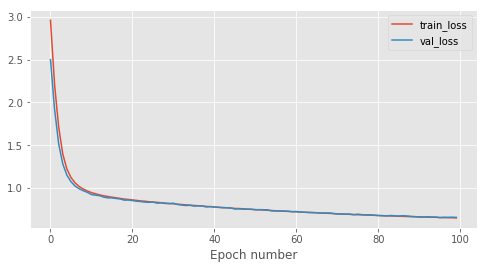

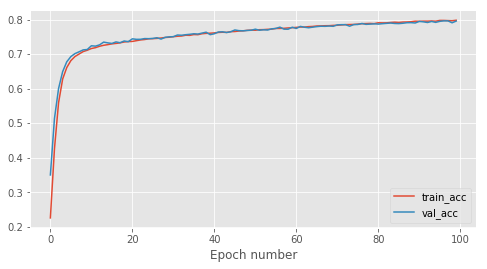

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])


loss: 3.8532, accuracy: 0.0000:   1%|          | 7/1000 [00:00<00:23, 42.88it/s]

torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.7027, accuracy: 0.7900:   1%|          | 11/1000 [00:00<00:16, 58.75it/s]

Epoch 0: train_acc_0.5600_train_loss_1.5590_val_acc_0.7165_val_loss_0.9249 epoch time 19.5659 seconds
total time0.0 : 19.56591010093689


loss: 0.7434, accuracy: 0.7900:   1%|          | 11/1000 [00:00<00:16, 60.08it/s]

Epoch 1: train_acc_0.7409_train_loss_0.8409_val_acc_0.7634_val_loss_0.7556 epoch time 19.2550 seconds
total time0.0 : 38.820932388305664


loss: 0.5748, accuracy: 0.8000:   1%|          | 11/1000 [00:00<00:16, 59.57it/s]

Epoch 2: train_acc_0.7764_train_loss_0.7176_val_acc_0.7915_val_loss_0.6616 epoch time 18.9128 seconds
total time0.0 : 57.73368287086487


loss: 0.4769, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 61.40it/s]

Epoch 3: train_acc_0.7977_train_loss_0.6437_val_acc_0.8078_val_loss_0.6067 epoch time 19.0365 seconds
total time1.0 : 16.770138025283813


loss: 0.3961, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 60.43it/s]

Epoch 4: train_acc_0.8128_train_loss_0.5933_val_acc_0.8131_val_loss_0.5844 epoch time 19.5766 seconds
total time1.0 : 36.346723794937134


loss: 0.6344, accuracy: 0.7900:   1%|          | 11/1000 [00:00<00:16, 60.44it/s]

Epoch 5: train_acc_0.8228_train_loss_0.5545_val_acc_0.8272_val_loss_0.5271 epoch time 18.9152 seconds
total time1.0 : 55.26187753677368


loss: 0.5363, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 60.89it/s]

Epoch 6: train_acc_0.8315_train_loss_0.5213_val_acc_0.8349_val_loss_0.5103 epoch time 19.4409 seconds
total time2.0 : 14.70282244682312


loss: 0.5339, accuracy: 0.7800:   1%|          | 11/1000 [00:00<00:16, 58.51it/s]

Epoch 7: train_acc_0.8395_train_loss_0.4958_val_acc_0.8354_val_loss_0.5043 epoch time 19.0872 seconds
total time2.0 : 33.79000902175903


loss: 0.6441, accuracy: 0.8000:   1%|          | 11/1000 [00:00<00:15, 62.02it/s]

Epoch 8: train_acc_0.8443_train_loss_0.4735_val_acc_0.8502_val_loss_0.4527 epoch time 19.5474 seconds
total time2.0 : 53.33740162849426


loss: 0.3612, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.23it/s]

Epoch 9: train_acc_0.8481_train_loss_0.4562_val_acc_0.8538_val_loss_0.4497 epoch time 19.1182 seconds
total time3.0 : 12.455603837966919


loss: 0.3422, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 62.14it/s]

Epoch 10: train_acc_0.8538_train_loss_0.4415_val_acc_0.8537_val_loss_0.4420 epoch time 19.5692 seconds
total time3.0 : 32.0247757434845


loss: 0.3510, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.59it/s]

Epoch 11: train_acc_0.8567_train_loss_0.4282_val_acc_0.8541_val_loss_0.4323 epoch time 19.1732 seconds
total time3.0 : 51.19801044464111


loss: 0.2692, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.57it/s]

Epoch 12: train_acc_0.8594_train_loss_0.4172_val_acc_0.8582_val_loss_0.4198 epoch time 19.5380 seconds
total time4.0 : 10.736046552658081


loss: 0.4497, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 58.22it/s]

Epoch 13: train_acc_0.8639_train_loss_0.4070_val_acc_0.8593_val_loss_0.4081 epoch time 19.2610 seconds
total time4.0 : 29.997050523757935


loss: 0.3178, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:15, 63.06it/s]

Epoch 14: train_acc_0.8643_train_loss_0.3986_val_acc_0.8645_val_loss_0.4049 epoch time 19.5129 seconds
total time4.0 : 49.50996780395508


loss: 0.4023, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.04it/s]

Epoch 15: train_acc_0.8669_train_loss_0.3917_val_acc_0.8666_val_loss_0.3959 epoch time 19.1452 seconds
total time5.0 : 8.655131816864014


loss: 0.4428, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 60.96it/s]

Epoch 16: train_acc_0.8685_train_loss_0.3857_val_acc_0.8628_val_loss_0.3953 epoch time 19.5356 seconds
total time5.0 : 28.19070267677307


loss: 0.4634, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 58.90it/s]

Epoch 17: train_acc_0.8700_train_loss_0.3794_val_acc_0.8541_val_loss_0.4038 epoch time 19.0750 seconds
total time5.0 : 47.2657208442688


loss: 0.4900, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 61.19it/s]

Epoch 18: train_acc_0.8712_train_loss_0.3752_val_acc_0.8659_val_loss_0.3882 epoch time 18.9719 seconds
total time6.0 : 6.237664699554443


loss: 0.4333, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:17, 57.75it/s]

Epoch 19: train_acc_0.8730_train_loss_0.3692_val_acc_0.8713_val_loss_0.3765 epoch time 19.0321 seconds
total time6.0 : 25.269749402999878


loss: 0.2602, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.74it/s]

Epoch 20: train_acc_0.8737_train_loss_0.3658_val_acc_0.8693_val_loss_0.3831 epoch time 19.5326 seconds
total time6.0 : 44.80233430862427


loss: 0.2087, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:17, 58.15it/s]

Epoch 21: train_acc_0.8753_train_loss_0.3611_val_acc_0.8665_val_loss_0.3824 epoch time 18.9517 seconds
total time7.0 : 3.7539920806884766


loss: 0.4334, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:16, 60.07it/s]

Epoch 22: train_acc_0.8772_train_loss_0.3581_val_acc_0.8709_val_loss_0.3733 epoch time 19.5576 seconds
total time7.0 : 23.311625003814697


loss: 0.3211, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 59.41it/s]

Epoch 23: train_acc_0.8767_train_loss_0.3545_val_acc_0.8696_val_loss_0.3752 epoch time 19.1069 seconds
total time7.0 : 42.41856932640076


loss: 0.3027, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 61.18it/s]

Epoch 24: train_acc_0.8785_train_loss_0.3517_val_acc_0.8668_val_loss_0.3786 epoch time 19.4997 seconds
total time8.0 : 1.9183032512664795


loss: 0.3876, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 59.54it/s]

Epoch 25: train_acc_0.8788_train_loss_0.3488_val_acc_0.8703_val_loss_0.3667 epoch time 19.1100 seconds
total time8.0 : 21.02827000617981


loss: 0.2845, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:15, 62.45it/s]

Epoch 26: train_acc_0.8797_train_loss_0.3458_val_acc_0.8724_val_loss_0.3718 epoch time 19.5591 seconds
total time8.0 : 40.58732008934021


loss: 0.2879, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:17, 57.97it/s]

Epoch 27: train_acc_0.8817_train_loss_0.3433_val_acc_0.8716_val_loss_0.3738 epoch time 19.0206 seconds
total time8.0 : 59.607930183410645


loss: 0.3340, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 60.39it/s]

Epoch 28: train_acc_0.8818_train_loss_0.3410_val_acc_0.8683_val_loss_0.3727 epoch time 19.5700 seconds
total time9.0 : 19.177916049957275


loss: 0.3525, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 59.62it/s]

Epoch 29: train_acc_0.8810_train_loss_0.3382_val_acc_0.8737_val_loss_0.3620 epoch time 19.0064 seconds
total time9.0 : 38.18427610397339


loss: 0.2715, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.38it/s]

Epoch 30: train_acc_0.8824_train_loss_0.3365_val_acc_0.8720_val_loss_0.3623 epoch time 19.5235 seconds
total time9.0 : 57.70777487754822


loss: 0.2789, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 58.17it/s]

Epoch 31: train_acc_0.8832_train_loss_0.3345_val_acc_0.8732_val_loss_0.3658 epoch time 18.9710 seconds
total time10.0 : 16.67873764038086


loss: 0.2794, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 61.54it/s]

Epoch 32: train_acc_0.8845_train_loss_0.3325_val_acc_0.8740_val_loss_0.3617 epoch time 19.4902 seconds
total time10.0 : 36.16890025138855


loss: 0.3640, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:18, 54.72it/s]

Epoch 33: train_acc_0.8840_train_loss_0.3306_val_acc_0.8699_val_loss_0.3654 epoch time 19.2844 seconds
total time10.0 : 55.45329546928406


loss: 0.2930, accuracy: 0.8600:   1%|          | 12/1000 [00:00<00:15, 61.85it/s]

Epoch 34: train_acc_0.8851_train_loss_0.3290_val_acc_0.8691_val_loss_0.3732 epoch time 19.0260 seconds
total time11.0 : 14.479265451431274


loss: 0.3217, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 59.54it/s]

Epoch 35: train_acc_0.8851_train_loss_0.3277_val_acc_0.8781_val_loss_0.3569 epoch time 19.1512 seconds
total time11.0 : 33.63044619560242


loss: 0.2438, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 61.26it/s]

Epoch 36: train_acc_0.8860_train_loss_0.3257_val_acc_0.8704_val_loss_0.3639 epoch time 19.5700 seconds
total time11.0 : 53.200416564941406


loss: 0.2807, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:17, 56.73it/s]

Epoch 37: train_acc_0.8866_train_loss_0.3239_val_acc_0.8756_val_loss_0.3618 epoch time 18.9973 seconds
total time12.0 : 12.197761535644531


loss: 0.2077, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 60.91it/s]

Epoch 38: train_acc_0.8867_train_loss_0.3230_val_acc_0.8758_val_loss_0.3620 epoch time 19.5856 seconds
total time12.0 : 31.78340721130371


loss: 0.2227, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 59.32it/s]

Epoch 39: train_acc_0.8883_train_loss_0.3211_val_acc_0.8680_val_loss_0.3677 epoch time 19.1110 seconds
total time12.0 : 50.89436459541321


loss: 0.2414, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 61.36it/s]

Epoch 40: train_acc_0.8875_train_loss_0.3199_val_acc_0.8774_val_loss_0.3612 epoch time 19.5678 seconds
total time13.0 : 10.462131023406982


loss: 0.2437, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 60.03it/s]

Epoch 41: train_acc_0.8886_train_loss_0.3182_val_acc_0.8731_val_loss_0.3613 epoch time 19.1705 seconds
total time13.0 : 29.632641553878784


loss: 0.2575, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 61.47it/s]

Epoch 42: train_acc_0.8888_train_loss_0.3169_val_acc_0.8709_val_loss_0.3706 epoch time 19.5429 seconds
total time13.0 : 49.1755747795105


loss: 0.3903, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 58.76it/s]

Epoch 43: train_acc_0.8887_train_loss_0.3158_val_acc_0.8769_val_loss_0.3596 epoch time 19.3402 seconds
total time14.0 : 8.515813827514648


loss: 0.2505, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:16, 61.42it/s]

Epoch 44: train_acc_0.8896_train_loss_0.3147_val_acc_0.8740_val_loss_0.3640 epoch time 19.5994 seconds
total time14.0 : 28.1152560710907


loss: 0.2350, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 59.48it/s]

Epoch 45: train_acc_0.8906_train_loss_0.3134_val_acc_0.8742_val_loss_0.3618 epoch time 19.0688 seconds
total time14.0 : 47.18408751487732


loss: 0.3879, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.40it/s]

Epoch 46: train_acc_0.8901_train_loss_0.3124_val_acc_0.8759_val_loss_0.3587 epoch time 19.5192 seconds
total time15.0 : 6.703284740447998


loss: 0.4985, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:16, 59.30it/s]

Epoch 47: train_acc_0.8908_train_loss_0.3104_val_acc_0.8777_val_loss_0.3555 epoch time 19.1593 seconds
total time15.0 : 25.862581491470337


loss: 0.2898, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 61.56it/s]

Epoch 48: train_acc_0.8902_train_loss_0.3097_val_acc_0.8721_val_loss_0.3646 epoch time 19.4883 seconds
total time15.0 : 45.35089659690857


loss: 0.2534, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.34it/s]

Epoch 49: train_acc_0.8913_train_loss_0.3086_val_acc_0.8772_val_loss_0.3600 epoch time 19.1617 seconds
total time16.0 : 4.512568473815918


loss: 0.3784, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 62.96it/s]

Epoch 50: train_acc_0.8914_train_loss_0.3080_val_acc_0.8778_val_loss_0.3548 epoch time 19.0577 seconds
total time16.0 : 23.570260524749756


loss: 0.2911, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:17, 57.97it/s]

Epoch 51: train_acc_0.8918_train_loss_0.3077_val_acc_0.8777_val_loss_0.3566 epoch time 18.9840 seconds
total time16.0 : 42.554288387298584


loss: 0.3424, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:15, 61.90it/s]

Epoch 52: train_acc_0.8920_train_loss_0.3061_val_acc_0.8778_val_loss_0.3544 epoch time 19.5261 seconds
total time17.0 : 2.0803744792938232


loss: 0.3141, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.43it/s]

Epoch 53: train_acc_0.8917_train_loss_0.3046_val_acc_0.8765_val_loss_0.3553 epoch time 18.9030 seconds
total time17.0 : 20.98340630531311


loss: 0.3044, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:15, 62.00it/s]

Epoch 54: train_acc_0.8921_train_loss_0.3043_val_acc_0.8759_val_loss_0.3596 epoch time 19.5081 seconds
total time17.0 : 40.491472005844116


loss: 0.2183, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:17, 57.33it/s]

Epoch 55: train_acc_0.8933_train_loss_0.3031_val_acc_0.8728_val_loss_0.3571 epoch time 19.1646 seconds
total time17.0 : 59.65609359741211


loss: 0.3467, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:15, 63.42it/s]

Epoch 56: train_acc_0.8937_train_loss_0.3025_val_acc_0.8747_val_loss_0.3563 epoch time 19.5511 seconds
total time18.0 : 19.207164525985718


loss: 0.2264, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:16, 58.53it/s]

Epoch 57: train_acc_0.8939_train_loss_0.3013_val_acc_0.8775_val_loss_0.3637 epoch time 19.1896 seconds
total time18.0 : 38.39680218696594


loss: 0.5347, accuracy: 0.8200:   1%|          | 11/1000 [00:00<00:16, 59.60it/s]

Epoch 58: train_acc_0.8939_train_loss_0.3008_val_acc_0.8754_val_loss_0.3601 epoch time 19.5416 seconds
total time18.0 : 57.93837642669678


loss: 0.2616, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.98it/s]

Epoch 59: train_acc_0.8943_train_loss_0.2994_val_acc_0.8775_val_loss_0.3571 epoch time 19.1856 seconds
total time19.0 : 17.12395453453064


loss: 0.2119, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 60.55it/s]

Epoch 60: train_acc_0.8935_train_loss_0.2997_val_acc_0.8740_val_loss_0.3630 epoch time 19.5920 seconds
total time19.0 : 36.71591806411743


loss: 0.3083, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 59.52it/s]

Epoch 61: train_acc_0.8946_train_loss_0.2988_val_acc_0.8777_val_loss_0.3558 epoch time 19.1551 seconds
total time19.0 : 55.871004819869995


loss: 0.2375, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 61.82it/s]

Epoch 62: train_acc_0.8933_train_loss_0.2984_val_acc_0.8746_val_loss_0.3687 epoch time 19.5773 seconds
total time20.0 : 15.448346376419067


loss: 0.3550, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 58.76it/s]

Epoch 63: train_acc_0.8949_train_loss_0.2977_val_acc_0.8767_val_loss_0.3567 epoch time 19.0739 seconds
total time20.0 : 34.52225375175476


loss: 0.2324, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 61.40it/s]

Epoch 64: train_acc_0.8953_train_loss_0.2951_val_acc_0.8704_val_loss_0.3699 epoch time 19.5018 seconds
total time20.0 : 54.02405023574829


loss: 0.1739, accuracy: 0.9500:   1%|          | 11/1000 [00:00<00:16, 59.26it/s]

Epoch 65: train_acc_0.8945_train_loss_0.2958_val_acc_0.8788_val_loss_0.3531 epoch time 19.2108 seconds
total time21.0 : 13.234894275665283


loss: 0.2959, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:15, 62.82it/s]

Epoch 66: train_acc_0.8958_train_loss_0.2947_val_acc_0.8785_val_loss_0.3502 epoch time 19.1114 seconds
total time21.0 : 32.34633708000183


loss: 0.2619, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 59.12it/s]

Epoch 67: train_acc_0.8950_train_loss_0.2937_val_acc_0.8785_val_loss_0.3570 epoch time 19.0794 seconds
total time21.0 : 51.42571544647217


loss: 0.3010, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 60.65it/s]

Epoch 68: train_acc_0.8956_train_loss_0.2929_val_acc_0.8784_val_loss_0.3542 epoch time 19.6002 seconds
total time22.0 : 11.025942087173462


loss: 0.2880, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:17, 57.08it/s]

Epoch 69: train_acc_0.8959_train_loss_0.2920_val_acc_0.8772_val_loss_0.3570 epoch time 18.9360 seconds
total time22.0 : 29.96196961402893


loss: 0.2971, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.75it/s]

Epoch 70: train_acc_0.8962_train_loss_0.2920_val_acc_0.8795_val_loss_0.3533 epoch time 19.5625 seconds
total time22.0 : 49.524500608444214


loss: 0.4135, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 59.06it/s]

Epoch 71: train_acc_0.8965_train_loss_0.2908_val_acc_0.8768_val_loss_0.3563 epoch time 19.2316 seconds
total time23.0 : 8.756124019622803


loss: 0.1974, accuracy: 0.9500:   1%|          | 11/1000 [00:00<00:15, 61.91it/s]

Epoch 72: train_acc_0.8952_train_loss_0.2913_val_acc_0.8782_val_loss_0.3534 epoch time 19.5702 seconds
total time23.0 : 28.32633686065674


loss: 0.4404, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.17it/s]

Epoch 73: train_acc_0.8966_train_loss_0.2894_val_acc_0.8787_val_loss_0.3579 epoch time 19.0750 seconds
total time23.0 : 47.40134119987488


loss: 0.2217, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.13it/s]

Epoch 74: train_acc_0.8967_train_loss_0.2893_val_acc_0.8737_val_loss_0.3644 epoch time 19.6129 seconds
total time24.0 : 7.014275312423706


loss: 0.3302, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 58.94it/s]

Epoch 75: train_acc_0.8973_train_loss_0.2882_val_acc_0.8797_val_loss_0.3586 epoch time 19.1314 seconds
total time24.0 : 26.145633220672607


loss: 0.2789, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:15, 61.83it/s]

Epoch 76: train_acc_0.8965_train_loss_0.2883_val_acc_0.8776_val_loss_0.3596 epoch time 19.5350 seconds
total time24.0 : 45.68064761161804


loss: 0.3531, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 56.03it/s]

Epoch 77: train_acc_0.8983_train_loss_0.2870_val_acc_0.8771_val_loss_0.3609 epoch time 19.2668 seconds
total time25.0 : 4.947424411773682


loss: 0.3460, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 61.52it/s]

Epoch 78: train_acc_0.8972_train_loss_0.2866_val_acc_0.8782_val_loss_0.3539 epoch time 19.5468 seconds
total time25.0 : 24.4941885471344


loss: 0.2383, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 58.69it/s]

Epoch 79: train_acc_0.8976_train_loss_0.2856_val_acc_0.8780_val_loss_0.3560 epoch time 19.0743 seconds
total time25.0 : 43.56850814819336


loss: 0.1749, accuracy: 0.9500:   1%|          | 11/1000 [00:00<00:16, 61.54it/s]

Epoch 80: train_acc_0.8982_train_loss_0.2848_val_acc_0.8754_val_loss_0.3585 epoch time 19.5895 seconds
total time26.0 : 3.1580121517181396


loss: 0.2374, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:17, 58.11it/s]

Epoch 81: train_acc_0.8974_train_loss_0.2854_val_acc_0.8772_val_loss_0.3534 epoch time 19.1327 seconds
total time26.0 : 22.290730714797974


loss: 0.1440, accuracy: 0.9500:   1%|          | 12/1000 [00:00<00:15, 61.93it/s]

Epoch 82: train_acc_0.8986_train_loss_0.2841_val_acc_0.8790_val_loss_0.3540 epoch time 19.2198 seconds
total time26.0 : 41.51051092147827


loss: 0.4189, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 58.88it/s]

Epoch 83: train_acc_0.8974_train_loss_0.2847_val_acc_0.8803_val_loss_0.3512 epoch time 19.1340 seconds
total time27.0 : 0.6445364952087402


loss: 0.2512, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:15, 61.93it/s]

Epoch 84: train_acc_0.8992_train_loss_0.2833_val_acc_0.8787_val_loss_0.3537 epoch time 19.5638 seconds
total time27.0 : 20.208330631256104


loss: 0.3279, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.44it/s]

Epoch 85: train_acc_0.8986_train_loss_0.2833_val_acc_0.8764_val_loss_0.3568 epoch time 19.0129 seconds
total time27.0 : 39.22123098373413


loss: 0.1966, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 59.80it/s]

Epoch 86: train_acc_0.8980_train_loss_0.2828_val_acc_0.8771_val_loss_0.3578 epoch time 19.5883 seconds
total time27.0 : 58.809490442276


loss: 0.2283, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 59.99it/s]

Epoch 87: train_acc_0.8988_train_loss_0.2818_val_acc_0.8792_val_loss_0.3554 epoch time 19.2868 seconds
total time28.0 : 18.09631109237671


loss: 0.3812, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 60.01it/s]

Epoch 88: train_acc_0.8995_train_loss_0.2812_val_acc_0.8794_val_loss_0.3602 epoch time 19.5281 seconds
total time28.0 : 37.62442874908447


loss: 0.3006, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.06it/s]

Epoch 89: train_acc_0.8995_train_loss_0.2809_val_acc_0.8782_val_loss_0.3560 epoch time 19.0032 seconds
total time28.0 : 56.62765169143677


loss: 0.2381, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 61.67it/s]

Epoch 90: train_acc_0.9000_train_loss_0.2800_val_acc_0.8785_val_loss_0.3571 epoch time 19.4955 seconds
total time29.0 : 16.123140811920166


loss: 0.3703, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 59.16it/s]

Epoch 91: train_acc_0.8995_train_loss_0.2796_val_acc_0.8755_val_loss_0.3593 epoch time 19.0579 seconds
total time29.0 : 35.18104386329651


loss: 0.2517, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 61.48it/s]

Epoch 92: train_acc_0.8998_train_loss_0.2788_val_acc_0.8794_val_loss_0.3552 epoch time 19.5447 seconds
total time29.0 : 54.72571635246277


loss: 0.3353, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 58.91it/s]

Epoch 93: train_acc_0.8998_train_loss_0.2790_val_acc_0.8749_val_loss_0.3625 epoch time 19.0125 seconds
total time30.0 : 13.738186120986938


loss: 0.2063, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.72it/s]

Epoch 94: train_acc_0.8995_train_loss_0.2780_val_acc_0.8801_val_loss_0.3578 epoch time 19.5668 seconds
total time30.0 : 33.304961919784546


loss: 0.1853, accuracy: 0.9400:   1%|          | 11/1000 [00:00<00:16, 59.17it/s]

Epoch 95: train_acc_0.8996_train_loss_0.2781_val_acc_0.8737_val_loss_0.3615 epoch time 19.1583 seconds
total time30.0 : 52.463299036026


loss: 0.2499, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 60.55it/s]

Epoch 96: train_acc_0.9005_train_loss_0.2771_val_acc_0.8794_val_loss_0.3579 epoch time 19.5002 seconds
total time31.0 : 11.963523864746094


loss: 0.2779, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 57.94it/s]

Epoch 97: train_acc_0.9013_train_loss_0.2766_val_acc_0.8780_val_loss_0.3572 epoch time 19.0837 seconds
total time31.0 : 31.047231674194336


loss: 0.4174, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 61.43it/s]

Epoch 98: train_acc_0.9011_train_loss_0.2761_val_acc_0.8777_val_loss_0.3603 epoch time 19.2590 seconds
total time31.0 : 50.30623388290405


loss: 0.4080, accuracy: 0.8900:  14%|█▍        | 22/158 [00:00<00:01, 124.80it/s]

Epoch 99: train_acc_0.9014_train_loss_0.2755_val_acc_0.8789_val_loss_0.3534 epoch time 18.8765 seconds
total time32.0 : 9.182694435119629
Generating test set evaluation metrics


loss: 0.3751, accuracy: 0.8400: 100%|██████████| 158/158 [00:01<00:00, 103.42it/s]


finish


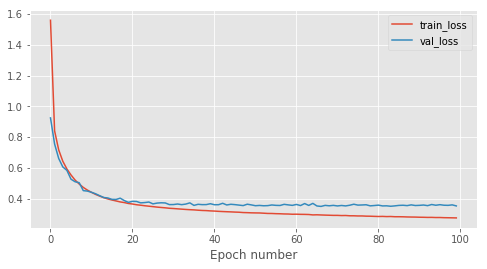

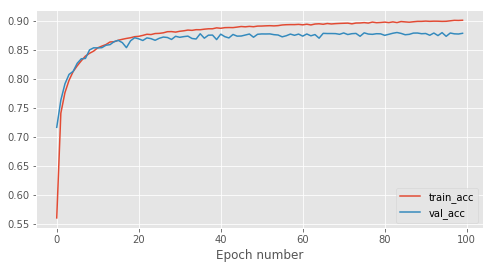

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])


loss: 3.8366, accuracy: 0.0100:   1%|          | 8/1000 [00:00<00:21, 47.00it/s]

torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.6310, accuracy: 0.7600:   1%|          | 10/1000 [00:00<00:18, 54.49it/s]

Epoch 0: train_acc_0.6533_train_loss_1.1868_val_acc_0.8006_val_loss_0.6241 epoch time 21.6124 seconds
total time0.0 : 21.612369775772095


loss: 0.4250, accuracy: 0.8400:   1%|          | 10/1000 [00:00<00:18, 53.53it/s]

Epoch 1: train_acc_0.8172_train_loss_0.5546_val_acc_0.8414_val_loss_0.4705 epoch time 21.6692 seconds
total time0.0 : 43.281607151031494


loss: 0.3317, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 53.07it/s]

Epoch 2: train_acc_0.8399_train_loss_0.4711_val_acc_0.8375_val_loss_0.4620 epoch time 21.6818 seconds
total time1.0 : 4.963417053222656


loss: 0.3573, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:18, 52.57it/s]

Epoch 3: train_acc_0.8542_train_loss_0.4266_val_acc_0.8586_val_loss_0.4105 epoch time 21.6572 seconds
total time1.0 : 26.620582580566406


loss: 0.3113, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.43it/s]

Epoch 4: train_acc_0.8619_train_loss_0.4007_val_acc_0.8541_val_loss_0.3996 epoch time 21.6744 seconds
total time1.0 : 48.2950325012207


loss: 0.4181, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:19, 50.85it/s]

Epoch 5: train_acc_0.8674_train_loss_0.3796_val_acc_0.8709_val_loss_0.3648 epoch time 21.7178 seconds
total time2.0 : 10.012836933135986


loss: 0.2975, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 53.55it/s]

Epoch 6: train_acc_0.8721_train_loss_0.3653_val_acc_0.8665_val_loss_0.3799 epoch time 21.7221 seconds
total time2.0 : 31.73494553565979


loss: 0.3063, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:18, 53.61it/s]

Epoch 7: train_acc_0.8749_train_loss_0.3530_val_acc_0.8725_val_loss_0.3613 epoch time 21.6895 seconds
total time2.0 : 53.424474477767944


loss: 0.2150, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:17, 55.10it/s]

Epoch 8: train_acc_0.8775_train_loss_0.3443_val_acc_0.8823_val_loss_0.3389 epoch time 21.6957 seconds
total time3.0 : 15.120177507400513


loss: 0.2807, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 54.18it/s]

Epoch 9: train_acc_0.8812_train_loss_0.3332_val_acc_0.8809_val_loss_0.3390 epoch time 21.6856 seconds
total time3.0 : 36.80575513839722


loss: 0.2438, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 53.11it/s]

Epoch 10: train_acc_0.8836_train_loss_0.3247_val_acc_0.8835_val_loss_0.3350 epoch time 21.6367 seconds
total time3.0 : 58.44249987602234


loss: 0.2711, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.36it/s]

Epoch 11: train_acc_0.8859_train_loss_0.3167_val_acc_0.8773_val_loss_0.3439 epoch time 21.7414 seconds
total time4.0 : 20.183857679367065


loss: 0.4641, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:18, 53.08it/s]

Epoch 12: train_acc_0.8883_train_loss_0.3095_val_acc_0.8849_val_loss_0.3284 epoch time 21.6540 seconds
total time4.0 : 41.83787560462952


loss: 0.4203, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 52.55it/s]

Epoch 13: train_acc_0.8901_train_loss_0.3039_val_acc_0.8792_val_loss_0.3440 epoch time 21.4264 seconds
total time5.0 : 3.264249324798584


loss: 0.4852, accuracy: 0.8400:   1%|          | 10/1000 [00:00<00:18, 52.43it/s]

Epoch 14: train_acc_0.8911_train_loss_0.2975_val_acc_0.8833_val_loss_0.3354 epoch time 21.5446 seconds
total time5.0 : 24.80881690979004


loss: 0.2788, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.27it/s]

Epoch 15: train_acc_0.8931_train_loss_0.2931_val_acc_0.8847_val_loss_0.3284 epoch time 21.7890 seconds
total time5.0 : 46.597809076309204


loss: 0.2246, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.66it/s]

Epoch 16: train_acc_0.8944_train_loss_0.2879_val_acc_0.8834_val_loss_0.3323 epoch time 21.7834 seconds
total time6.0 : 8.381231784820557


loss: 0.3115, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.28it/s]

Epoch 17: train_acc_0.8963_train_loss_0.2814_val_acc_0.8829_val_loss_0.3399 epoch time 21.7418 seconds
total time6.0 : 30.12299919128418


loss: 0.1946, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.31it/s]

Epoch 18: train_acc_0.8972_train_loss_0.2784_val_acc_0.8865_val_loss_0.3288 epoch time 21.7101 seconds
total time6.0 : 51.83307957649231


loss: 0.1324, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 51.60it/s]

Epoch 19: train_acc_0.9000_train_loss_0.2728_val_acc_0.8863_val_loss_0.3306 epoch time 21.7416 seconds
total time7.0 : 13.574649810791016


loss: 0.1637, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.48it/s]

Epoch 20: train_acc_0.8996_train_loss_0.2692_val_acc_0.8795_val_loss_0.3349 epoch time 21.7354 seconds
total time7.0 : 35.31004452705383


loss: 0.2442, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:18, 52.37it/s]

Epoch 21: train_acc_0.9014_train_loss_0.2649_val_acc_0.8815_val_loss_0.3454 epoch time 21.7918 seconds
total time7.0 : 57.10185122489929


loss: 0.1317, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 51.45it/s]

Epoch 22: train_acc_0.9028_train_loss_0.2612_val_acc_0.8862_val_loss_0.3315 epoch time 21.7489 seconds
total time8.0 : 18.850760221481323


loss: 0.2890, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 53.17it/s]

Epoch 23: train_acc_0.9039_train_loss_0.2561_val_acc_0.8851_val_loss_0.3392 epoch time 21.7922 seconds
total time8.0 : 40.64297032356262


loss: 0.2123, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.92it/s]

Epoch 24: train_acc_0.9051_train_loss_0.2544_val_acc_0.8792_val_loss_0.3422 epoch time 21.7381 seconds
total time9.0 : 2.381096839904785


loss: 0.3657, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 52.08it/s]

Epoch 25: train_acc_0.9062_train_loss_0.2510_val_acc_0.8818_val_loss_0.3370 epoch time 21.7771 seconds
total time9.0 : 24.158165454864502


loss: 0.2848, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 52.64it/s]

Epoch 26: train_acc_0.9066_train_loss_0.2475_val_acc_0.8778_val_loss_0.3487 epoch time 21.7373 seconds
total time9.0 : 45.89543557167053


loss: 0.2559, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 53.54it/s]

Epoch 27: train_acc_0.9074_train_loss_0.2439_val_acc_0.8832_val_loss_0.3423 epoch time 21.3788 seconds
total time10.0 : 7.274285078048706


loss: 0.2213, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:17, 55.32it/s]

Epoch 28: train_acc_0.9086_train_loss_0.2410_val_acc_0.8813_val_loss_0.3411 epoch time 21.5221 seconds
total time10.0 : 28.796411275863647


loss: 0.2799, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.94it/s]

Epoch 29: train_acc_0.9083_train_loss_0.2397_val_acc_0.8809_val_loss_0.3494 epoch time 21.6466 seconds
total time10.0 : 50.44305396080017


loss: 0.1746, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.04it/s]

Epoch 30: train_acc_0.9110_train_loss_0.2341_val_acc_0.8834_val_loss_0.3411 epoch time 21.6794 seconds
total time11.0 : 12.122443914413452


loss: 0.2151, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.33it/s]

Epoch 31: train_acc_0.9112_train_loss_0.2333_val_acc_0.8740_val_loss_0.3616 epoch time 21.6911 seconds
total time11.0 : 33.81350541114807


loss: 0.1312, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.85it/s]

Epoch 32: train_acc_0.9122_train_loss_0.2290_val_acc_0.8825_val_loss_0.3409 epoch time 21.7240 seconds
total time11.0 : 55.537476778030396


loss: 0.1857, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.42it/s]

Epoch 33: train_acc_0.9133_train_loss_0.2270_val_acc_0.8797_val_loss_0.3523 epoch time 21.7009 seconds
total time12.0 : 17.23836588859558


loss: 0.1571, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.52it/s]

Epoch 34: train_acc_0.9136_train_loss_0.2255_val_acc_0.8801_val_loss_0.3565 epoch time 21.6631 seconds
total time12.0 : 38.901443004608154


loss: 0.2207, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.81it/s]

Epoch 35: train_acc_0.9146_train_loss_0.2222_val_acc_0.8815_val_loss_0.3559 epoch time 21.6740 seconds
total time13.0 : 0.5754146575927734


loss: 0.2073, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.61it/s]

Epoch 36: train_acc_0.9153_train_loss_0.2193_val_acc_0.8820_val_loss_0.3576 epoch time 21.7266 seconds
total time13.0 : 22.302011966705322


loss: 0.1734, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.39it/s]

Epoch 37: train_acc_0.9164_train_loss_0.2176_val_acc_0.8774_val_loss_0.3688 epoch time 21.6761 seconds
total time13.0 : 43.97812366485596


loss: 0.1328, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.98it/s]

Epoch 38: train_acc_0.9170_train_loss_0.2151_val_acc_0.8825_val_loss_0.3550 epoch time 21.7318 seconds
total time14.0 : 5.709883451461792


loss: 0.2487, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.76it/s]

Epoch 39: train_acc_0.9179_train_loss_0.2126_val_acc_0.8773_val_loss_0.3660 epoch time 21.8457 seconds
total time14.0 : 27.555586099624634


loss: 0.2437, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.98it/s]

Epoch 40: train_acc_0.9176_train_loss_0.2113_val_acc_0.8822_val_loss_0.3659 epoch time 21.9023 seconds
total time14.0 : 49.45789885520935


loss: 0.1571, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.82it/s]

Epoch 41: train_acc_0.9190_train_loss_0.2087_val_acc_0.8765_val_loss_0.3736 epoch time 21.5785 seconds
total time15.0 : 11.036429405212402


loss: 0.1220, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.39it/s]

Epoch 42: train_acc_0.9204_train_loss_0.2055_val_acc_0.8780_val_loss_0.3676 epoch time 21.5767 seconds
total time15.0 : 32.61311650276184


loss: 0.1486, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.74it/s]

Epoch 43: train_acc_0.9204_train_loss_0.2042_val_acc_0.8773_val_loss_0.3738 epoch time 21.6473 seconds
total time15.0 : 54.26041054725647


loss: 0.1944, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 53.06it/s]

Epoch 44: train_acc_0.9215_train_loss_0.2016_val_acc_0.8793_val_loss_0.3823 epoch time 21.7234 seconds
total time16.0 : 15.983821868896484


loss: 0.1609, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 53.50it/s]

Epoch 45: train_acc_0.9222_train_loss_0.1990_val_acc_0.8777_val_loss_0.3832 epoch time 21.7345 seconds
total time16.0 : 37.71833848953247


loss: 0.1828, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:18, 52.86it/s]

Epoch 46: train_acc_0.9226_train_loss_0.1978_val_acc_0.8788_val_loss_0.3760 epoch time 21.7644 seconds
total time16.0 : 59.48277306556702


loss: 0.1519, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.25it/s]

Epoch 47: train_acc_0.9233_train_loss_0.1955_val_acc_0.8791_val_loss_0.3810 epoch time 21.7360 seconds
total time17.0 : 21.218735694885254


loss: 0.2509, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:18, 52.93it/s]

Epoch 48: train_acc_0.9242_train_loss_0.1922_val_acc_0.8773_val_loss_0.3818 epoch time 21.7317 seconds
total time17.0 : 42.95048117637634


loss: 0.1608, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.96it/s]

Epoch 49: train_acc_0.9245_train_loss_0.1921_val_acc_0.8751_val_loss_0.4018 epoch time 21.7415 seconds
total time18.0 : 4.691945552825928


loss: 0.1203, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.61it/s]

Epoch 50: train_acc_0.9247_train_loss_0.1904_val_acc_0.8741_val_loss_0.3908 epoch time 21.6970 seconds
total time18.0 : 26.388975858688354


loss: 0.1719, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:18, 53.75it/s]

Epoch 51: train_acc_0.9258_train_loss_0.1879_val_acc_0.8759_val_loss_0.4018 epoch time 21.6891 seconds
total time18.0 : 48.07808756828308


loss: 0.1141, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:18, 52.42it/s]

Epoch 52: train_acc_0.9267_train_loss_0.1847_val_acc_0.8728_val_loss_0.4051 epoch time 21.7643 seconds
total time19.0 : 9.84243106842041


loss: 0.1545, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.69it/s]

Epoch 53: train_acc_0.9266_train_loss_0.1851_val_acc_0.8730_val_loss_0.4023 epoch time 21.7693 seconds
total time19.0 : 31.611737966537476


loss: 0.2017, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.88it/s]

Epoch 54: train_acc_0.9275_train_loss_0.1826_val_acc_0.8751_val_loss_0.4039 epoch time 21.7591 seconds
total time19.0 : 53.37085270881653


loss: 0.1842, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.87it/s]

Epoch 55: train_acc_0.9274_train_loss_0.1802_val_acc_0.8749_val_loss_0.4062 epoch time 21.7312 seconds
total time20.0 : 15.10202670097351


loss: 0.1614, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.63it/s]

Epoch 56: train_acc_0.9290_train_loss_0.1791_val_acc_0.8755_val_loss_0.4097 epoch time 21.3596 seconds
total time20.0 : 36.46164917945862


loss: 0.2032, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 53.35it/s]

Epoch 57: train_acc_0.9289_train_loss_0.1772_val_acc_0.8735_val_loss_0.4163 epoch time 21.6851 seconds
total time20.0 : 58.14673447608948


loss: 0.3569, accuracy: 0.8500:   1%|          | 10/1000 [00:00<00:18, 54.11it/s]

Epoch 58: train_acc_0.9297_train_loss_0.1764_val_acc_0.8777_val_loss_0.4073 epoch time 21.7288 seconds
total time21.0 : 19.875532865524292


loss: 0.1882, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.80it/s]

Epoch 59: train_acc_0.9313_train_loss_0.1736_val_acc_0.8736_val_loss_0.4175 epoch time 21.6831 seconds
total time21.0 : 41.55863356590271


loss: 0.1698, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:18, 52.24it/s]

Epoch 60: train_acc_0.9308_train_loss_0.1728_val_acc_0.8659_val_loss_0.4531 epoch time 21.7676 seconds
total time22.0 : 3.3261873722076416


loss: 0.1030, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.16it/s]

Epoch 61: train_acc_0.9313_train_loss_0.1713_val_acc_0.8698_val_loss_0.4258 epoch time 21.7120 seconds
total time22.0 : 25.03820776939392


loss: 0.1471, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.65it/s]

Epoch 62: train_acc_0.9314_train_loss_0.1707_val_acc_0.8706_val_loss_0.4304 epoch time 21.7340 seconds
total time22.0 : 46.77217149734497


loss: 0.1778, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 53.84it/s]

Epoch 63: train_acc_0.9332_train_loss_0.1683_val_acc_0.8716_val_loss_0.4456 epoch time 21.7252 seconds
total time23.0 : 8.497332572937012


loss: 0.1811, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 52.80it/s]

Epoch 64: train_acc_0.9326_train_loss_0.1678_val_acc_0.8725_val_loss_0.4404 epoch time 21.7111 seconds
total time23.0 : 30.20845341682434


loss: 0.1589, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 52.24it/s]

Epoch 65: train_acc_0.9346_train_loss_0.1649_val_acc_0.8716_val_loss_0.4390 epoch time 21.7690 seconds
total time23.0 : 51.97740626335144


loss: 0.1324, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.49it/s]

Epoch 66: train_acc_0.9338_train_loss_0.1636_val_acc_0.8747_val_loss_0.4430 epoch time 21.7284 seconds
total time24.0 : 13.705832242965698


loss: 0.1276, accuracy: 0.9300:   1%|          | 10/1000 [00:00<00:18, 53.35it/s]

Epoch 67: train_acc_0.9350_train_loss_0.1624_val_acc_0.8713_val_loss_0.4438 epoch time 21.6907 seconds
total time24.0 : 35.396535873413086


loss: 0.1055, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 50.77it/s]

Epoch 68: train_acc_0.9357_train_loss_0.1602_val_acc_0.8720_val_loss_0.4431 epoch time 21.7270 seconds
total time24.0 : 57.123584508895874


loss: 0.1293, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.11it/s]

Epoch 69: train_acc_0.9353_train_loss_0.1593_val_acc_0.8668_val_loss_0.4703 epoch time 21.7567 seconds
total time25.0 : 18.880243062973022


loss: 0.1752, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.86it/s]

Epoch 70: train_acc_0.9363_train_loss_0.1589_val_acc_0.8680_val_loss_0.4617 epoch time 21.4015 seconds
total time25.0 : 40.28172445297241


loss: 0.2358, accuracy: 0.8700:   1%|          | 10/1000 [00:00<00:18, 53.23it/s]

Epoch 71: train_acc_0.9368_train_loss_0.1563_val_acc_0.8711_val_loss_0.4631 epoch time 21.6474 seconds
total time26.0 : 1.9290988445281982


loss: 0.1330, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 54.33it/s]

Epoch 72: train_acc_0.9372_train_loss_0.1561_val_acc_0.8697_val_loss_0.4794 epoch time 21.7617 seconds
total time26.0 : 23.69077968597412


loss: 0.1079, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.33it/s]

Epoch 73: train_acc_0.9385_train_loss_0.1538_val_acc_0.8690_val_loss_0.4811 epoch time 21.7384 seconds
total time26.0 : 45.42919993400574


loss: 0.0922, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.83it/s]

Epoch 74: train_acc_0.9380_train_loss_0.1537_val_acc_0.8689_val_loss_0.4786 epoch time 21.7063 seconds
total time27.0 : 7.1355202198028564


loss: 0.1563, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.48it/s]

Epoch 75: train_acc_0.9393_train_loss_0.1511_val_acc_0.8718_val_loss_0.4822 epoch time 21.7380 seconds
total time27.0 : 28.873564958572388


loss: 0.1310, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.77it/s]

Epoch 76: train_acc_0.9394_train_loss_0.1500_val_acc_0.8713_val_loss_0.4765 epoch time 21.7761 seconds
total time27.0 : 50.64970541000366


loss: 0.1433, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.25it/s]

Epoch 77: train_acc_0.9395_train_loss_0.1484_val_acc_0.8709_val_loss_0.4786 epoch time 21.7090 seconds
total time28.0 : 12.358714580535889


loss: 0.1183, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:18, 53.49it/s]

Epoch 78: train_acc_0.9406_train_loss_0.1477_val_acc_0.8690_val_loss_0.4879 epoch time 21.7730 seconds
total time28.0 : 34.13172936439514


loss: 0.1678, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 52.52it/s]

Epoch 79: train_acc_0.9410_train_loss_0.1472_val_acc_0.8700_val_loss_0.4967 epoch time 21.7388 seconds
total time28.0 : 55.87052273750305


loss: 0.0958, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.92it/s]

Epoch 80: train_acc_0.9418_train_loss_0.1445_val_acc_0.8696_val_loss_0.4930 epoch time 21.7268 seconds
total time29.0 : 17.59731388092041


loss: 0.0981, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.36it/s]

Epoch 81: train_acc_0.9408_train_loss_0.1453_val_acc_0.8692_val_loss_0.4944 epoch time 21.7514 seconds
total time29.0 : 39.34869456291199


loss: 0.0964, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:18, 52.99it/s]

Epoch 82: train_acc_0.9420_train_loss_0.1437_val_acc_0.8706_val_loss_0.4900 epoch time 21.7504 seconds
total time30.0 : 1.0990889072418213


loss: 0.1557, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:18, 52.26it/s]

Epoch 83: train_acc_0.9422_train_loss_0.1429_val_acc_0.8694_val_loss_0.5140 epoch time 21.7028 seconds
total time30.0 : 22.80186104774475


loss: 0.1199, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.92it/s]

Epoch 84: train_acc_0.9438_train_loss_0.1402_val_acc_0.8683_val_loss_0.5172 epoch time 21.4752 seconds
total time30.0 : 44.277101039886475


loss: 0.1061, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:18, 52.62it/s]

Epoch 85: train_acc_0.9427_train_loss_0.1401_val_acc_0.8691_val_loss_0.5161 epoch time 21.5846 seconds
total time31.0 : 5.861711263656616


loss: 0.0889, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 53.04it/s]

Epoch 86: train_acc_0.9444_train_loss_0.1384_val_acc_0.8660_val_loss_0.5248 epoch time 21.6792 seconds
total time31.0 : 27.540879249572754


loss: 0.1577, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.40it/s]

Epoch 87: train_acc_0.9439_train_loss_0.1384_val_acc_0.8677_val_loss_0.5155 epoch time 21.7586 seconds
total time31.0 : 49.29951882362366


loss: 0.1256, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:19, 51.79it/s]

Epoch 88: train_acc_0.9451_train_loss_0.1369_val_acc_0.8669_val_loss_0.5154 epoch time 21.7597 seconds
total time32.0 : 11.05917739868164


loss: 0.1130, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 54.95it/s]

Epoch 89: train_acc_0.9451_train_loss_0.1354_val_acc_0.8669_val_loss_0.5349 epoch time 21.7155 seconds
total time32.0 : 32.77471160888672


loss: 0.1195, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 53.15it/s]

Epoch 90: train_acc_0.9461_train_loss_0.1338_val_acc_0.8652_val_loss_0.5393 epoch time 21.7454 seconds
total time32.0 : 54.5201256275177


loss: 0.1469, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:18, 52.31it/s]

Epoch 91: train_acc_0.9461_train_loss_0.1328_val_acc_0.8652_val_loss_0.5434 epoch time 21.7783 seconds
total time33.0 : 16.29837989807129


loss: 0.0983, accuracy: 0.9700:   1%|          | 10/1000 [00:00<00:18, 52.21it/s]

Epoch 92: train_acc_0.9460_train_loss_0.1327_val_acc_0.8682_val_loss_0.5467 epoch time 21.7502 seconds
total time33.0 : 38.048622369766235


loss: 0.1176, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 52.23it/s]

Epoch 93: train_acc_0.9464_train_loss_0.1325_val_acc_0.8672_val_loss_0.5491 epoch time 21.7498 seconds
total time33.0 : 59.79847192764282


loss: 0.2318, accuracy: 0.9500:   1%|          | 10/1000 [00:00<00:18, 53.66it/s]

Epoch 94: train_acc_0.9469_train_loss_0.1308_val_acc_0.8668_val_loss_0.5442 epoch time 21.7335 seconds
total time34.0 : 21.531981706619263


loss: 0.1000, accuracy: 0.9600:   1%|          | 10/1000 [00:00<00:18, 52.36it/s]

Epoch 95: train_acc_0.9483_train_loss_0.1281_val_acc_0.8690_val_loss_0.5436 epoch time 21.7334 seconds
total time34.0 : 43.26535654067993


loss: 0.0773, accuracy: 0.9800:   1%|          | 10/1000 [00:00<00:19, 51.81it/s]

Epoch 96: train_acc_0.9485_train_loss_0.1277_val_acc_0.8656_val_loss_0.5523 epoch time 21.7442 seconds
total time35.0 : 5.0095295906066895


loss: 0.1296, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:19, 51.69it/s]

Epoch 97: train_acc_0.9481_train_loss_0.1281_val_acc_0.8666_val_loss_0.5554 epoch time 21.7394 seconds
total time35.0 : 26.748894691467285


loss: 0.1108, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:18, 54.22it/s]

Epoch 98: train_acc_0.9491_train_loss_0.1252_val_acc_0.8677_val_loss_0.5479 epoch time 21.6567 seconds
total time35.0 : 48.405592918395996


loss: 0.4211, accuracy: 0.8300:  13%|█▎        | 20/158 [00:00<00:01, 109.31it/s]

Epoch 99: train_acc_0.9491_train_loss_0.1248_val_acc_0.8643_val_loss_0.5608 epoch time 21.6056 seconds
total time36.0 : 10.01122522354126
Generating test set evaluation metrics


loss: 0.3275, accuracy: 0.8600: 100%|██████████| 158/158 [00:01<00:00, 96.87it/s]


finish


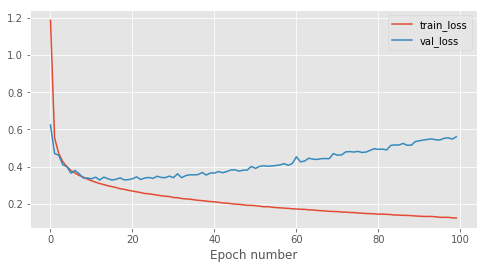

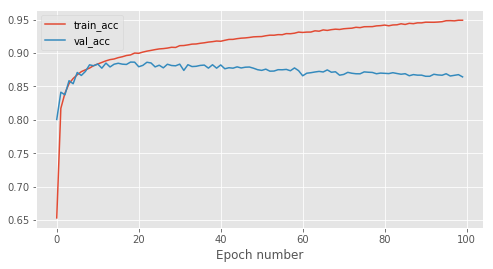

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])


loss: 3.8475, accuracy: 0.0200:   1%|          | 7/1000 [00:00<00:22, 44.82it/s]

torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=

loss: 0.4434, accuracy: 0.8200:   1%|          | 9/1000 [00:00<00:20, 47.70it/s]

Epoch 0: train_acc_0.6910_train_loss_1.0218_val_acc_0.8283_val_loss_0.5000 epoch time 23.7178 seconds
total time0.0 : 23.717756271362305


loss: 0.5203, accuracy: 0.8300:   1%|          | 8/1000 [00:00<00:20, 47.76it/s]

Epoch 1: train_acc_0.8368_train_loss_0.4721_val_acc_0.8641_val_loss_0.3974 epoch time 23.6876 seconds
total time0.0 : 47.40534281730652


loss: 0.3996, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:19, 49.81it/s]

Epoch 2: train_acc_0.8579_train_loss_0.4023_val_acc_0.8675_val_loss_0.3747 epoch time 23.7022 seconds
total time1.0 : 11.107568264007568


loss: 0.4199, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.68it/s]

Epoch 3: train_acc_0.8706_train_loss_0.3649_val_acc_0.8722_val_loss_0.3566 epoch time 23.6162 seconds
total time1.0 : 34.72378754615784


loss: 0.2851, accuracy: 0.8600:   1%|          | 8/1000 [00:00<00:21, 47.00it/s]

Epoch 4: train_acc_0.8760_train_loss_0.3410_val_acc_0.8711_val_loss_0.3526 epoch time 23.7166 seconds
total time1.0 : 58.44035744667053


loss: 0.3548, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:20, 48.71it/s]

Epoch 5: train_acc_0.8830_train_loss_0.3218_val_acc_0.8773_val_loss_0.3350 epoch time 23.7138 seconds
total time2.0 : 22.154160737991333


loss: 0.3259, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 49.41it/s]

Epoch 6: train_acc_0.8867_train_loss_0.3057_val_acc_0.8769_val_loss_0.3411 epoch time 23.7158 seconds
total time2.0 : 45.86991333961487


loss: 0.2171, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 47.21it/s]

Epoch 7: train_acc_0.8907_train_loss_0.2923_val_acc_0.8820_val_loss_0.3289 epoch time 23.7045 seconds
total time3.0 : 9.57439923286438


loss: 0.3046, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 47.82it/s]

Epoch 8: train_acc_0.8948_train_loss_0.2793_val_acc_0.8825_val_loss_0.3295 epoch time 23.7028 seconds
total time3.0 : 33.277238607406616


loss: 0.2581, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.59it/s]

Epoch 9: train_acc_0.8981_train_loss_0.2687_val_acc_0.8837_val_loss_0.3210 epoch time 23.6685 seconds
total time3.0 : 56.945775270462036


loss: 0.2003, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.66it/s]

Epoch 10: train_acc_0.9000_train_loss_0.2582_val_acc_0.8786_val_loss_0.3353 epoch time 23.6140 seconds
total time4.0 : 20.559730768203735


loss: 0.2801, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.73it/s]

Epoch 11: train_acc_0.9032_train_loss_0.2490_val_acc_0.8815_val_loss_0.3421 epoch time 23.7029 seconds
total time4.0 : 44.26267147064209


loss: 0.1575, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.75it/s]

Epoch 12: train_acc_0.9065_train_loss_0.2403_val_acc_0.8847_val_loss_0.3287 epoch time 23.3368 seconds
total time5.0 : 7.599493741989136


loss: 0.1377, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.66it/s]

Epoch 13: train_acc_0.9091_train_loss_0.2314_val_acc_0.8802_val_loss_0.3365 epoch time 23.6834 seconds
total time5.0 : 31.282859563827515


loss: 0.3170, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 49.22it/s]

Epoch 14: train_acc_0.9119_train_loss_0.2231_val_acc_0.8825_val_loss_0.3514 epoch time 23.6828 seconds
total time5.0 : 54.96564269065857


loss: 0.2204, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 47.19it/s]

Epoch 15: train_acc_0.9146_train_loss_0.2157_val_acc_0.8832_val_loss_0.3349 epoch time 23.6936 seconds
total time6.0 : 18.659281015396118


loss: 0.1052, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.52it/s]

Epoch 16: train_acc_0.9165_train_loss_0.2078_val_acc_0.8841_val_loss_0.3497 epoch time 23.6559 seconds
total time6.0 : 42.31514072418213


loss: 0.1439, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 49.93it/s]

Epoch 17: train_acc_0.9190_train_loss_0.2009_val_acc_0.8839_val_loss_0.3469 epoch time 23.7202 seconds
total time7.0 : 6.0353851318359375


loss: 0.2142, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.92it/s]

Epoch 18: train_acc_0.9220_train_loss_0.1934_val_acc_0.8818_val_loss_0.3582 epoch time 23.6120 seconds
total time7.0 : 29.647414445877075


loss: 0.2188, accuracy: 0.8700:   1%|          | 8/1000 [00:00<00:20, 47.29it/s]

Epoch 19: train_acc_0.9228_train_loss_0.1887_val_acc_0.8820_val_loss_0.3693 epoch time 23.6356 seconds
total time7.0 : 53.28301787376404


loss: 0.1447, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.92it/s]

Epoch 20: train_acc_0.9258_train_loss_0.1829_val_acc_0.8742_val_loss_0.3842 epoch time 23.6798 seconds
total time8.0 : 16.96278667449951


loss: 0.1500, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:21, 47.16it/s]

Epoch 21: train_acc_0.9278_train_loss_0.1766_val_acc_0.8808_val_loss_0.3896 epoch time 23.6358 seconds
total time8.0 : 40.59854984283447


loss: 0.1259, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 48.22it/s]

Epoch 22: train_acc_0.9294_train_loss_0.1714_val_acc_0.8800_val_loss_0.3853 epoch time 23.6916 seconds
total time9.0 : 4.290118217468262


loss: 0.1285, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.52it/s]

Epoch 23: train_acc_0.9317_train_loss_0.1660_val_acc_0.8753_val_loss_0.4097 epoch time 23.6703 seconds
total time9.0 : 27.960435390472412


loss: 0.1849, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.82it/s]

Epoch 24: train_acc_0.9332_train_loss_0.1610_val_acc_0.8781_val_loss_0.4196 epoch time 23.5850 seconds
total time9.0 : 51.54546403884888


loss: 0.0697, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.49it/s]

Epoch 25: train_acc_0.9359_train_loss_0.1564_val_acc_0.8809_val_loss_0.4228 epoch time 23.0497 seconds
total time10.0 : 14.595213890075684


loss: 0.1785, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 48.32it/s]

Epoch 26: train_acc_0.9366_train_loss_0.1511_val_acc_0.8791_val_loss_0.4381 epoch time 23.6678 seconds
total time10.0 : 38.26296949386597


loss: 0.2005, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 48.07it/s]

Epoch 27: train_acc_0.9389_train_loss_0.1462_val_acc_0.8767_val_loss_0.4771 epoch time 23.6852 seconds
total time11.0 : 1.948152780532837


loss: 0.1209, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.16it/s]

Epoch 28: train_acc_0.9399_train_loss_0.1432_val_acc_0.8787_val_loss_0.4429 epoch time 23.6812 seconds
total time11.0 : 25.62939429283142


loss: 0.1852, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:20, 48.96it/s]

Epoch 29: train_acc_0.9422_train_loss_0.1377_val_acc_0.8756_val_loss_0.4797 epoch time 23.6944 seconds
total time11.0 : 49.32378315925598


loss: 0.1332, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 49.78it/s]

Epoch 30: train_acc_0.9450_train_loss_0.1325_val_acc_0.8790_val_loss_0.4578 epoch time 23.6675 seconds
total time12.0 : 12.991320848464966


loss: 0.0695, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:21, 46.98it/s]

Epoch 31: train_acc_0.9436_train_loss_0.1337_val_acc_0.8758_val_loss_0.4737 epoch time 23.7023 seconds
total time12.0 : 36.69357514381409


loss: 0.1544, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 49.90it/s]

Epoch 32: train_acc_0.9463_train_loss_0.1284_val_acc_0.8723_val_loss_0.4956 epoch time 23.7117 seconds
total time13.0 : 0.4052765369415283


loss: 0.0674, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 46.59it/s]

Epoch 33: train_acc_0.9466_train_loss_0.1260_val_acc_0.8722_val_loss_0.5051 epoch time 23.6539 seconds
total time13.0 : 24.05921506881714


loss: 0.1943, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 48.76it/s]

Epoch 34: train_acc_0.9481_train_loss_0.1231_val_acc_0.8732_val_loss_0.5221 epoch time 23.6645 seconds
total time13.0 : 47.72371864318848


loss: 0.1117, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.77it/s]

Epoch 35: train_acc_0.9504_train_loss_0.1182_val_acc_0.8713_val_loss_0.5317 epoch time 23.6434 seconds
total time14.0 : 11.367105722427368


loss: 0.1026, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.39it/s]

Epoch 36: train_acc_0.9508_train_loss_0.1160_val_acc_0.8742_val_loss_0.5597 epoch time 23.7078 seconds
total time14.0 : 35.07494926452637


loss: 0.0862, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.90it/s]

Epoch 37: train_acc_0.9520_train_loss_0.1148_val_acc_0.8720_val_loss_0.5366 epoch time 23.5231 seconds
total time14.0 : 58.59804105758667


loss: 0.0597, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 49.59it/s]

Epoch 38: train_acc_0.9535_train_loss_0.1109_val_acc_0.8705_val_loss_0.5981 epoch time 23.0976 seconds
total time15.0 : 21.695686101913452


loss: 0.0935, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.46it/s]

Epoch 39: train_acc_0.9538_train_loss_0.1105_val_acc_0.8727_val_loss_0.5722 epoch time 23.5841 seconds
total time15.0 : 45.27983283996582


loss: 0.0933, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 48.78it/s]

Epoch 40: train_acc_0.9548_train_loss_0.1085_val_acc_0.8713_val_loss_0.5798 epoch time 23.6536 seconds
total time16.0 : 8.933430671691895


loss: 0.0841, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:21, 47.15it/s]

Epoch 41: train_acc_0.9562_train_loss_0.1043_val_acc_0.8736_val_loss_0.5935 epoch time 23.6389 seconds
total time16.0 : 32.572317123413086


loss: 0.1173, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 49.03it/s]

Epoch 42: train_acc_0.9573_train_loss_0.1022_val_acc_0.8653_val_loss_0.6013 epoch time 23.6443 seconds
total time16.0 : 56.2166645526886


loss: 0.0315, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:20, 48.50it/s]

Epoch 43: train_acc_0.9572_train_loss_0.1021_val_acc_0.8722_val_loss_0.6078 epoch time 23.6418 seconds
total time17.0 : 19.858498334884644


loss: 0.0920, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.62it/s]

Epoch 44: train_acc_0.9596_train_loss_0.0958_val_acc_0.8692_val_loss_0.6107 epoch time 23.6846 seconds
total time17.0 : 43.543123722076416


loss: 0.1336, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.82it/s]

Epoch 45: train_acc_0.9588_train_loss_0.0989_val_acc_0.8681_val_loss_0.6320 epoch time 23.6463 seconds
total time18.0 : 7.189450263977051


loss: 0.1570, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.02it/s]

Epoch 46: train_acc_0.9602_train_loss_0.0966_val_acc_0.8761_val_loss_0.6222 epoch time 23.6417 seconds
total time18.0 : 30.831170082092285


loss: 0.0694, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.36it/s]

Epoch 47: train_acc_0.9617_train_loss_0.0921_val_acc_0.8735_val_loss_0.6707 epoch time 23.5332 seconds
total time18.0 : 54.36441206932068


loss: 0.0975, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.65it/s]

Epoch 48: train_acc_0.9623_train_loss_0.0920_val_acc_0.8675_val_loss_0.6861 epoch time 23.6687 seconds
total time19.0 : 18.033136129379272


loss: 0.0795, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.35it/s]

Epoch 49: train_acc_0.9616_train_loss_0.0919_val_acc_0.8687_val_loss_0.6744 epoch time 23.5525 seconds
total time19.0 : 41.58566665649414


loss: 0.0663, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.56it/s]

Epoch 50: train_acc_0.9625_train_loss_0.0899_val_acc_0.8715_val_loss_0.6580 epoch time 23.5026 seconds
total time20.0 : 5.088288068771362


loss: 0.0802, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:21, 46.80it/s]

Epoch 51: train_acc_0.9641_train_loss_0.0868_val_acc_0.8676_val_loss_0.6683 epoch time 23.1610 seconds
total time20.0 : 28.24927854537964


loss: 0.0824, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.31it/s]

Epoch 52: train_acc_0.9655_train_loss_0.0837_val_acc_0.8711_val_loss_0.6901 epoch time 23.6721 seconds
total time20.0 : 51.92137694358826


loss: 0.0480, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.56it/s]

Epoch 53: train_acc_0.9646_train_loss_0.0864_val_acc_0.8708_val_loss_0.7158 epoch time 23.6073 seconds
total time21.0 : 15.528700351715088


loss: 0.0327, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 49.32it/s]

Epoch 54: train_acc_0.9653_train_loss_0.0828_val_acc_0.8686_val_loss_0.7378 epoch time 23.6648 seconds
total time21.0 : 39.19351029396057


loss: 0.0465, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 47.53it/s]

Epoch 55: train_acc_0.9656_train_loss_0.0845_val_acc_0.8689_val_loss_0.7327 epoch time 23.6262 seconds
total time22.0 : 2.8197500705718994


loss: 0.0604, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.50it/s]

Epoch 56: train_acc_0.9667_train_loss_0.0805_val_acc_0.8698_val_loss_0.7324 epoch time 23.7009 seconds
total time22.0 : 26.52066707611084


loss: 0.1271, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.98it/s]

Epoch 57: train_acc_0.9677_train_loss_0.0788_val_acc_0.8696_val_loss_0.7453 epoch time 23.5285 seconds
total time22.0 : 50.04920506477356


loss: 0.0308, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 48.54it/s]

Epoch 58: train_acc_0.9659_train_loss_0.0830_val_acc_0.8684_val_loss_0.7700 epoch time 23.6352 seconds
total time23.0 : 13.68441891670227


loss: 0.0826, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:21, 47.04it/s]

Epoch 59: train_acc_0.9676_train_loss_0.0790_val_acc_0.8684_val_loss_0.7919 epoch time 23.6451 seconds
total time23.0 : 37.32952094078064


loss: 0.1206, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 49.13it/s]

Epoch 60: train_acc_0.9692_train_loss_0.0741_val_acc_0.8677_val_loss_0.7967 epoch time 23.6696 seconds
total time24.0 : 0.9991326332092285


loss: 0.0511, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.32it/s]

Epoch 61: train_acc_0.9688_train_loss_0.0771_val_acc_0.8699_val_loss_0.7889 epoch time 23.6328 seconds
total time24.0 : 24.631894826889038


loss: 0.0623, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.34it/s]

Epoch 62: train_acc_0.9692_train_loss_0.0761_val_acc_0.8680_val_loss_0.7792 epoch time 23.6079 seconds
total time24.0 : 48.239773750305176


loss: 0.0832, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 49.14it/s]

Epoch 63: train_acc_0.9691_train_loss_0.0746_val_acc_0.8705_val_loss_0.7847 epoch time 23.3981 seconds
total time25.0 : 11.63791823387146


loss: 0.0979, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.75it/s]

Epoch 64: train_acc_0.9711_train_loss_0.0716_val_acc_0.8671_val_loss_0.7972 epoch time 23.2096 seconds
total time25.0 : 34.84756517410278


loss: 0.0734, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.73it/s]

Epoch 65: train_acc_0.9707_train_loss_0.0726_val_acc_0.8736_val_loss_0.8191 epoch time 23.5044 seconds
total time25.0 : 58.3519549369812


loss: 0.0766, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.41it/s]

Epoch 66: train_acc_0.9710_train_loss_0.0721_val_acc_0.8702_val_loss_0.8180 epoch time 23.6058 seconds
total time26.0 : 21.957738161087036


loss: 0.0536, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.64it/s]

Epoch 67: train_acc_0.9728_train_loss_0.0673_val_acc_0.8629_val_loss_0.8897 epoch time 23.5129 seconds
total time26.0 : 45.47059917449951


loss: 0.0560, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.76it/s]

Epoch 68: train_acc_0.9711_train_loss_0.0723_val_acc_0.8678_val_loss_0.8333 epoch time 23.6436 seconds
total time27.0 : 9.11421823501587


loss: 0.0171, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:20, 47.47it/s]

Epoch 69: train_acc_0.9729_train_loss_0.0683_val_acc_0.8672_val_loss_0.8452 epoch time 23.5564 seconds
total time27.0 : 32.67065143585205


loss: 0.0404, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.78it/s]

Epoch 70: train_acc_0.9722_train_loss_0.0689_val_acc_0.8685_val_loss_0.8740 epoch time 23.5970 seconds
total time27.0 : 56.26768684387207


loss: 0.0898, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.84it/s]

Epoch 71: train_acc_0.9731_train_loss_0.0674_val_acc_0.8666_val_loss_0.8388 epoch time 23.4943 seconds
total time28.0 : 19.762017726898193


loss: 0.0824, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.43it/s]

Epoch 72: train_acc_0.9721_train_loss_0.0679_val_acc_0.8715_val_loss_0.8359 epoch time 23.5747 seconds
total time28.0 : 43.336700677871704


loss: 0.1451, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.71it/s]

Epoch 73: train_acc_0.9747_train_loss_0.0626_val_acc_0.8627_val_loss_0.8948 epoch time 23.5700 seconds
total time29.0 : 6.906665086746216


loss: 0.0405, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.24it/s]

Epoch 74: train_acc_0.9744_train_loss_0.0634_val_acc_0.8668_val_loss_0.8707 epoch time 23.6247 seconds
total time29.0 : 30.53140878677368


loss: 0.0925, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.65it/s]

Epoch 75: train_acc_0.9742_train_loss_0.0648_val_acc_0.8665_val_loss_0.8345 epoch time 23.6013 seconds
total time29.0 : 54.13266944885254


loss: 0.0698, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:19, 50.03it/s]

Epoch 76: train_acc_0.9739_train_loss_0.0650_val_acc_0.8694_val_loss_0.8753 epoch time 23.4248 seconds
total time30.0 : 17.557466506958008


loss: 0.0640, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.89it/s]

Epoch 77: train_acc_0.9766_train_loss_0.0598_val_acc_0.8680_val_loss_0.9437 epoch time 23.3140 seconds
total time30.0 : 40.87143111228943


loss: 0.0819, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 49.62it/s]

Epoch 78: train_acc_0.9723_train_loss_0.0694_val_acc_0.8694_val_loss_0.8887 epoch time 23.3601 seconds
total time31.0 : 4.231512069702148


loss: 0.0728, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.48it/s]

Epoch 79: train_acc_0.9768_train_loss_0.0583_val_acc_0.8678_val_loss_0.9325 epoch time 23.5275 seconds
total time31.0 : 27.758994340896606


loss: 0.0491, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 50.80it/s]

Epoch 80: train_acc_0.9763_train_loss_0.0595_val_acc_0.8649_val_loss_0.8575 epoch time 23.6161 seconds
total time31.0 : 51.375075817108154


loss: 0.0408, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.76it/s]

Epoch 81: train_acc_0.9766_train_loss_0.0588_val_acc_0.8641_val_loss_0.9531 epoch time 23.4627 seconds
total time32.0 : 14.837746620178223


loss: 0.0780, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.89it/s]

Epoch 82: train_acc_0.9748_train_loss_0.0636_val_acc_0.8647_val_loss_0.9060 epoch time 23.5753 seconds
total time32.0 : 38.41303110122681


loss: 0.0366, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.25it/s]

Epoch 83: train_acc_0.9760_train_loss_0.0603_val_acc_0.8667_val_loss_0.9214 epoch time 23.5873 seconds
total time33.0 : 2.0003137588500977


loss: 0.0381, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 50.08it/s]

Epoch 84: train_acc_0.9775_train_loss_0.0566_val_acc_0.8669_val_loss_0.9501 epoch time 23.6207 seconds
total time33.0 : 25.620989084243774


loss: 0.0372, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.42it/s]

Epoch 85: train_acc_0.9765_train_loss_0.0595_val_acc_0.8647_val_loss_0.9583 epoch time 23.5133 seconds
total time33.0 : 49.134272813797


loss: 0.0449, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.22it/s]

Epoch 86: train_acc_0.9775_train_loss_0.0560_val_acc_0.8643_val_loss_0.9313 epoch time 23.6195 seconds
total time34.0 : 12.753785610198975


loss: 0.0505, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 47.56it/s]

Epoch 87: train_acc_0.9780_train_loss_0.0572_val_acc_0.8661_val_loss_0.9580 epoch time 23.6260 seconds
total time34.0 : 36.379793643951416


loss: 0.0216, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 49.16it/s]

Epoch 88: train_acc_0.9763_train_loss_0.0603_val_acc_0.8684_val_loss_0.9474 epoch time 23.6309 seconds
total time35.0 : 0.010715007781982422


loss: 0.0434, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.94it/s]

Epoch 89: train_acc_0.9795_train_loss_0.0523_val_acc_0.8663_val_loss_0.9584 epoch time 23.4285 seconds
total time35.0 : 23.4392147064209


loss: 0.1013, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 49.35it/s]

Epoch 90: train_acc_0.9789_train_loss_0.0545_val_acc_0.8690_val_loss_0.9988 epoch time 23.6033 seconds
total time35.0 : 47.04248785972595


loss: 0.0758, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.34it/s]

Epoch 91: train_acc_0.9779_train_loss_0.0574_val_acc_0.8665_val_loss_0.9842 epoch time 23.0909 seconds
total time36.0 : 10.133345127105713


loss: 0.0287, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:19, 49.91it/s]

Epoch 92: train_acc_0.9782_train_loss_0.0550_val_acc_0.8653_val_loss_1.0267 epoch time 23.4367 seconds
total time36.0 : 33.57004976272583


loss: 0.0361, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.44it/s]

Epoch 93: train_acc_0.9793_train_loss_0.0531_val_acc_0.8672_val_loss_0.9950 epoch time 23.5134 seconds
total time36.0 : 57.083407163619995


loss: 0.1293, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 49.55it/s]

Epoch 94: train_acc_0.9796_train_loss_0.0523_val_acc_0.8680_val_loss_1.0412 epoch time 23.5039 seconds
total time37.0 : 20.587276697158813


loss: 0.0652, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.99it/s]

Epoch 95: train_acc_0.9813_train_loss_0.0487_val_acc_0.8693_val_loss_0.9799 epoch time 23.5531 seconds
total time37.0 : 44.14037752151489


loss: 0.0178, accuracy: 1.0000:   1%|          | 9/1000 [00:00<00:19, 50.80it/s]

Epoch 96: train_acc_0.9779_train_loss_0.0567_val_acc_0.8650_val_loss_1.0100 epoch time 23.5185 seconds
total time38.0 : 7.658881902694702


loss: 0.0655, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.46it/s]

Epoch 97: train_acc_0.9809_train_loss_0.0504_val_acc_0.8649_val_loss_1.0349 epoch time 23.4766 seconds
total time38.0 : 31.13544011116028


loss: 0.0517, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.80it/s]

Epoch 98: train_acc_0.9798_train_loss_0.0520_val_acc_0.8641_val_loss_1.0374 epoch time 23.5885 seconds
total time38.0 : 54.72390627861023


loss: 0.1928, accuracy: 0.9000:  12%|█▏        | 19/158 [00:00<00:01, 103.26it/s]

Epoch 99: train_acc_0.9811_train_loss_0.0497_val_acc_0.8621_val_loss_1.0718 epoch time 23.6377 seconds
total time39.0 : 18.361652374267578
Generating test set evaluation metrics


loss: 0.7423, accuracy: 0.8200: 100%|██████████| 158/158 [00:01<00:00, 92.88it/s]


finish


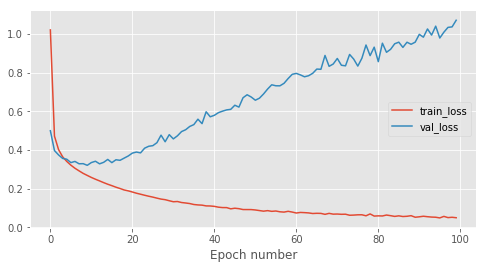

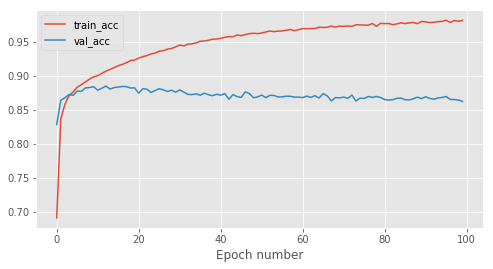

In [5]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [2,2,2,2]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [1,2,3,4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("maxpooling_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

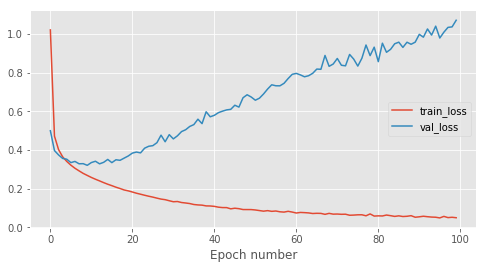

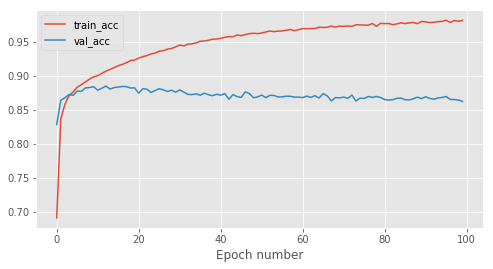

In [6]:
plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f2969cd25f8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29688fe8d0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29688fed30>)


loss: 3.8613, accuracy: 0.0100:   1%|          | 11/1000 [00:00<00:11, 89.23it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 2.5931, accuracy: 0.2500:   2%|▏         | 17/1000 [00:00<00:11, 88.39it/s]

Epoch 0: train_acc_0.2005_train_loss_3.0392_val_acc_0.2968_val_loss_2.6806 epoch time 13.9241 seconds
total time0.0 : 13.924070835113525


loss: 2.3607, accuracy: 0.3500:   2%|▏         | 16/1000 [00:00<00:11, 88.85it/s]

Epoch 1: train_acc_0.3636_train_loss_2.4482_val_acc_0.4535_val_loss_2.1823 epoch time 13.6360 seconds
total time0.0 : 27.560023546218872


loss: 1.8033, accuracy: 0.5300:   2%|▏         | 16/1000 [00:00<00:11, 88.15it/s]

Epoch 2: train_acc_0.5025_train_loss_1.9680_val_acc_0.5488_val_loss_1.7594 epoch time 13.6298 seconds
total time0.0 : 41.18985295295715


loss: 1.6496, accuracy: 0.5400:   2%|▏         | 16/1000 [00:00<00:11, 86.44it/s]

Epoch 3: train_acc_0.5798_train_loss_1.6242_val_acc_0.6084_val_loss_1.4890 epoch time 13.5934 seconds
total time0.0 : 54.783215045928955


loss: 1.2660, accuracy: 0.6800:   2%|▏         | 16/1000 [00:00<00:11, 85.30it/s]

Epoch 4: train_acc_0.6240_train_loss_1.4116_val_acc_0.6443_val_loss_1.3201 epoch time 13.6176 seconds
total time1.0 : 8.40079927444458


loss: 1.1918, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:10, 89.51it/s]

Epoch 5: train_acc_0.6508_train_loss_1.2776_val_acc_0.6653_val_loss_1.2107 epoch time 13.5974 seconds
total time1.0 : 21.998201847076416


loss: 1.5880, accuracy: 0.4900:   2%|▏         | 17/1000 [00:00<00:10, 91.50it/s]

Epoch 6: train_acc_0.6686_train_loss_1.1859_val_acc_0.6796_val_loss_1.1360 epoch time 13.5445 seconds
total time1.0 : 35.542720556259155


loss: 0.8673, accuracy: 0.7800:   2%|▏         | 16/1000 [00:00<00:11, 88.84it/s]

Epoch 7: train_acc_0.6810_train_loss_1.1232_val_acc_0.6912_val_loss_1.0815 epoch time 13.3840 seconds
total time1.0 : 48.92668271064758


loss: 1.5311, accuracy: 0.5100:   2%|▏         | 17/1000 [00:00<00:11, 89.16it/s]

Epoch 8: train_acc_0.6898_train_loss_1.0759_val_acc_0.7001_val_loss_1.0431 epoch time 13.2438 seconds
total time2.0 : 2.17047119140625


loss: 0.8650, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:11, 88.56it/s]

Epoch 9: train_acc_0.6979_train_loss_1.0406_val_acc_0.7060_val_loss_1.0142 epoch time 13.3451 seconds
total time2.0 : 15.515554666519165


loss: 1.2385, accuracy: 0.6200:   2%|▏         | 18/1000 [00:00<00:10, 92.58it/s]

Epoch 10: train_acc_0.7029_train_loss_1.0127_val_acc_0.7141_val_loss_0.9811 epoch time 13.0646 seconds
total time2.0 : 28.58018708229065


loss: 0.8924, accuracy: 0.7000:   2%|▏         | 17/1000 [00:00<00:11, 87.26it/s]

Epoch 11: train_acc_0.7076_train_loss_0.9911_val_acc_0.7120_val_loss_0.9694 epoch time 12.9947 seconds
total time2.0 : 41.574880599975586


loss: 1.0120, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 89.98it/s]

Epoch 12: train_acc_0.7120_train_loss_0.9727_val_acc_0.7170_val_loss_0.9519 epoch time 13.1707 seconds
total time2.0 : 54.745628118515015


loss: 0.7651, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 93.37it/s]

Epoch 13: train_acc_0.7150_train_loss_0.9576_val_acc_0.7238_val_loss_0.9340 epoch time 12.5169 seconds
total time3.0 : 7.262538909912109


loss: 1.0423, accuracy: 0.6700:   2%|▏         | 17/1000 [00:00<00:10, 90.95it/s]

Epoch 14: train_acc_0.7173_train_loss_0.9456_val_acc_0.7249_val_loss_0.9234 epoch time 12.9444 seconds
total time3.0 : 20.20692539215088


loss: 0.8003, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:11, 87.72it/s]

Epoch 15: train_acc_0.7198_train_loss_0.9349_val_acc_0.7213_val_loss_0.9154 epoch time 12.9723 seconds
total time3.0 : 33.17918586730957


loss: 0.7531, accuracy: 0.8100:   2%|▏         | 16/1000 [00:00<00:11, 88.64it/s]

Epoch 16: train_acc_0.7224_train_loss_0.9251_val_acc_0.7282_val_loss_0.9082 epoch time 13.3972 seconds
total time3.0 : 46.57634615898132


loss: 0.7825, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 89.79it/s]

Epoch 17: train_acc_0.7240_train_loss_0.9160_val_acc_0.7268_val_loss_0.9020 epoch time 13.2416 seconds
total time3.0 : 59.81789708137512


loss: 0.7765, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 89.65it/s]

Epoch 18: train_acc_0.7275_train_loss_0.9077_val_acc_0.7316_val_loss_0.8888 epoch time 13.2870 seconds
total time4.0 : 13.104850769042969


loss: 0.6193, accuracy: 0.8200:   2%|▏         | 16/1000 [00:00<00:11, 86.61it/s]

Epoch 19: train_acc_0.7284_train_loss_0.9018_val_acc_0.7284_val_loss_0.8889 epoch time 13.1916 seconds
total time4.0 : 26.296403408050537


loss: 0.8548, accuracy: 0.7300:   2%|▏         | 17/1000 [00:00<00:11, 87.76it/s]

Epoch 20: train_acc_0.7300_train_loss_0.8958_val_acc_0.7325_val_loss_0.8797 epoch time 13.2187 seconds
total time4.0 : 39.51512861251831


loss: 0.9404, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:10, 90.22it/s]

Epoch 21: train_acc_0.7309_train_loss_0.8897_val_acc_0.7337_val_loss_0.8753 epoch time 13.1860 seconds
total time4.0 : 52.701138734817505


loss: 1.2099, accuracy: 0.6700:   2%|▏         | 17/1000 [00:00<00:10, 89.92it/s]

Epoch 22: train_acc_0.7340_train_loss_0.8829_val_acc_0.7348_val_loss_0.8708 epoch time 13.1266 seconds
total time5.0 : 5.827742338180542


loss: 1.0966, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:11, 88.10it/s]

Epoch 23: train_acc_0.7343_train_loss_0.8798_val_acc_0.7356_val_loss_0.8647 epoch time 13.1656 seconds
total time5.0 : 18.993319511413574


loss: 1.0060, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:10, 91.52it/s]

Epoch 24: train_acc_0.7355_train_loss_0.8740_val_acc_0.7357_val_loss_0.8647 epoch time 13.1215 seconds
total time5.0 : 32.1148407459259


loss: 1.0910, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 89.87it/s]

Epoch 25: train_acc_0.7363_train_loss_0.8697_val_acc_0.7378_val_loss_0.8614 epoch time 13.1862 seconds
total time5.0 : 45.301050662994385


loss: 0.6955, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:11, 89.07it/s]

Epoch 26: train_acc_0.7384_train_loss_0.8668_val_acc_0.7368_val_loss_0.8531 epoch time 13.1502 seconds
total time5.0 : 58.45125150680542


loss: 0.8251, accuracy: 0.7400:   2%|▏         | 16/1000 [00:00<00:11, 86.21it/s]

Epoch 27: train_acc_0.7379_train_loss_0.8621_val_acc_0.7391_val_loss_0.8565 epoch time 13.1276 seconds
total time6.0 : 11.578823804855347


loss: 0.6521, accuracy: 0.8200:   2%|▏         | 17/1000 [00:00<00:10, 91.33it/s]

Epoch 28: train_acc_0.7388_train_loss_0.8586_val_acc_0.7392_val_loss_0.8506 epoch time 13.1233 seconds
total time6.0 : 24.70214867591858


loss: 0.6789, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:09, 98.35it/s]

Epoch 29: train_acc_0.7408_train_loss_0.8549_val_acc_0.7414_val_loss_0.8460 epoch time 13.1212 seconds
total time6.0 : 37.823326110839844


loss: 0.9452, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 89.52it/s]

Epoch 30: train_acc_0.7419_train_loss_0.8510_val_acc_0.7412_val_loss_0.8500 epoch time 13.0498 seconds
total time6.0 : 50.8731369972229


loss: 0.8561, accuracy: 0.7100:   2%|▏         | 17/1000 [00:00<00:10, 93.92it/s]

Epoch 31: train_acc_0.7424_train_loss_0.8479_val_acc_0.7456_val_loss_0.8393 epoch time 13.1199 seconds
total time7.0 : 3.9930572509765625


loss: 0.7154, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:11, 89.06it/s]

Epoch 32: train_acc_0.7432_train_loss_0.8446_val_acc_0.7441_val_loss_0.8316 epoch time 13.1025 seconds
total time7.0 : 17.095549821853638


loss: 0.8495, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 91.48it/s]

Epoch 33: train_acc_0.7448_train_loss_0.8418_val_acc_0.7451_val_loss_0.8317 epoch time 12.9919 seconds
total time7.0 : 30.08747148513794


loss: 0.8258, accuracy: 0.7300:   2%|▏         | 17/1000 [00:00<00:10, 91.23it/s]

Epoch 34: train_acc_0.7452_train_loss_0.8385_val_acc_0.7470_val_loss_0.8344 epoch time 12.7448 seconds
total time7.0 : 42.83222484588623


loss: 0.5203, accuracy: 0.8500:   2%|▏         | 17/1000 [00:00<00:10, 90.94it/s]

Epoch 35: train_acc_0.7467_train_loss_0.8361_val_acc_0.7479_val_loss_0.8257 epoch time 13.0513 seconds
total time7.0 : 55.88348937034607


loss: 0.8231, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:10, 96.97it/s]

Epoch 36: train_acc_0.7455_train_loss_0.8341_val_acc_0.7473_val_loss_0.8262 epoch time 12.9851 seconds
total time8.0 : 8.868629932403564


loss: 0.7081, accuracy: 0.8100:   2%|▏         | 18/1000 [00:00<00:10, 95.57it/s]

Epoch 37: train_acc_0.7475_train_loss_0.8315_val_acc_0.7501_val_loss_0.8229 epoch time 12.5480 seconds
total time8.0 : 21.416670083999634


loss: 0.9406, accuracy: 0.7000:   2%|▏         | 18/1000 [00:00<00:10, 91.42it/s]

Epoch 38: train_acc_0.7484_train_loss_0.8283_val_acc_0.7516_val_loss_0.8164 epoch time 13.0414 seconds
total time8.0 : 34.45807957649231


loss: 0.7710, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 90.53it/s]

Epoch 39: train_acc_0.7500_train_loss_0.8258_val_acc_0.7463_val_loss_0.8198 epoch time 13.0110 seconds
total time8.0 : 47.46905851364136


loss: 0.6562, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 93.74it/s]

Epoch 40: train_acc_0.7502_train_loss_0.8231_val_acc_0.7481_val_loss_0.8168 epoch time 13.0103 seconds
total time9.0 : 0.47931885719299316


loss: 0.7027, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 89.85it/s]

Epoch 41: train_acc_0.7508_train_loss_0.8201_val_acc_0.7500_val_loss_0.8164 epoch time 13.0511 seconds
total time9.0 : 13.530388116836548


loss: 1.0138, accuracy: 0.6500:   2%|▏         | 16/1000 [00:00<00:10, 90.96it/s]

Epoch 42: train_acc_0.7520_train_loss_0.8195_val_acc_0.7522_val_loss_0.8093 epoch time 13.3158 seconds
total time9.0 : 26.846172332763672


loss: 0.6402, accuracy: 0.8000:   2%|▏         | 16/1000 [00:00<00:11, 87.50it/s]

Epoch 43: train_acc_0.7506_train_loss_0.8173_val_acc_0.7524_val_loss_0.8097 epoch time 13.5320 seconds
total time9.0 : 40.37812829017639


loss: 0.8087, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 89.45it/s]

Epoch 44: train_acc_0.7516_train_loss_0.8144_val_acc_0.7495_val_loss_0.8106 epoch time 13.3401 seconds
total time9.0 : 53.71825075149536


loss: 0.7706, accuracy: 0.7900:   2%|▏         | 16/1000 [00:00<00:11, 86.56it/s]

Epoch 45: train_acc_0.7525_train_loss_0.8114_val_acc_0.7545_val_loss_0.8019 epoch time 13.3235 seconds
total time10.0 : 7.041731595993042


loss: 0.7188, accuracy: 0.7500:   2%|▏         | 16/1000 [00:00<00:11, 87.19it/s]

Epoch 46: train_acc_0.7533_train_loss_0.8110_val_acc_0.7530_val_loss_0.8031 epoch time 13.3931 seconds
total time10.0 : 20.43485975265503


loss: 0.5420, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 89.79it/s]

Epoch 47: train_acc_0.7547_train_loss_0.8091_val_acc_0.7557_val_loss_0.8020 epoch time 13.3325 seconds
total time10.0 : 33.76740574836731


loss: 0.7776, accuracy: 0.7100:   2%|▏         | 16/1000 [00:00<00:11, 87.62it/s]

Epoch 48: train_acc_0.7539_train_loss_0.8065_val_acc_0.7542_val_loss_0.7987 epoch time 13.4679 seconds
total time10.0 : 47.2353515625


loss: 0.8294, accuracy: 0.7100:   2%|▏         | 16/1000 [00:00<00:11, 87.63it/s]

Epoch 49: train_acc_0.7552_train_loss_0.8048_val_acc_0.7553_val_loss_0.7999 epoch time 13.3719 seconds
total time11.0 : 0.6072666645050049


loss: 0.5824, accuracy: 0.8100:   2%|▏         | 16/1000 [00:00<00:11, 86.68it/s]

Epoch 50: train_acc_0.7543_train_loss_0.8027_val_acc_0.7589_val_loss_0.7939 epoch time 13.4717 seconds
total time11.0 : 14.079004764556885


loss: 0.8830, accuracy: 0.7500:   2%|▏         | 16/1000 [00:00<00:11, 88.92it/s]

Epoch 51: train_acc_0.7557_train_loss_0.8006_val_acc_0.7551_val_loss_0.7979 epoch time 13.2379 seconds
total time11.0 : 27.316929578781128


loss: 0.7440, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 91.53it/s]

Epoch 52: train_acc_0.7561_train_loss_0.7993_val_acc_0.7553_val_loss_0.7960 epoch time 13.2841 seconds
total time11.0 : 40.60107755661011


loss: 0.5196, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 89.49it/s]

Epoch 53: train_acc_0.7565_train_loss_0.7971_val_acc_0.7545_val_loss_0.7942 epoch time 13.1464 seconds
total time11.0 : 53.74748682975769


loss: 1.0424, accuracy: 0.6900:   2%|▏         | 17/1000 [00:00<00:10, 89.72it/s]

Epoch 54: train_acc_0.7563_train_loss_0.7956_val_acc_0.7575_val_loss_0.7846 epoch time 13.1201 seconds
total time12.0 : 6.867595195770264


loss: 0.7119, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:11, 89.29it/s]

Epoch 55: train_acc_0.7588_train_loss_0.7937_val_acc_0.7594_val_loss_0.7860 epoch time 13.1380 seconds
total time12.0 : 20.005595922470093


loss: 0.6217, accuracy: 0.8100:   2%|▏         | 17/1000 [00:00<00:10, 89.98it/s]

Epoch 56: train_acc_0.7588_train_loss_0.7921_val_acc_0.7622_val_loss_0.7833 epoch time 13.1433 seconds
total time12.0 : 33.14886164665222


loss: 0.8073, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 90.00it/s]

Epoch 57: train_acc_0.7580_train_loss_0.7902_val_acc_0.7558_val_loss_0.7854 epoch time 12.7231 seconds
total time12.0 : 45.87200880050659


loss: 0.8956, accuracy: 0.7000:   2%|▏         | 17/1000 [00:00<00:10, 89.43it/s]

Epoch 58: train_acc_0.7583_train_loss_0.7891_val_acc_0.7566_val_loss_0.7840 epoch time 13.1201 seconds
total time12.0 : 58.99215579032898


loss: 0.8674, accuracy: 0.6800:   2%|▏         | 18/1000 [00:00<00:10, 91.51it/s]

Epoch 59: train_acc_0.7594_train_loss_0.7868_val_acc_0.7611_val_loss_0.7787 epoch time 12.9730 seconds
total time13.0 : 11.965146541595459


loss: 0.8173, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 96.25it/s]

Epoch 60: train_acc_0.7597_train_loss_0.7856_val_acc_0.7578_val_loss_0.7856 epoch time 12.6502 seconds
total time13.0 : 24.61539077758789


loss: 0.8712, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:09, 98.36it/s]

Epoch 61: train_acc_0.7609_train_loss_0.7844_val_acc_0.7596_val_loss_0.7812 epoch time 12.7298 seconds
total time13.0 : 37.345165967941284


loss: 0.8625, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 89.59it/s]

Epoch 62: train_acc_0.7608_train_loss_0.7825_val_acc_0.7606_val_loss_0.7763 epoch time 13.1221 seconds
total time13.0 : 50.467312812805176


loss: 0.8145, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:11, 87.80it/s]

Epoch 63: train_acc_0.7613_train_loss_0.7802_val_acc_0.7588_val_loss_0.7759 epoch time 13.2876 seconds
total time14.0 : 3.7549378871917725


loss: 0.9269, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 89.49it/s]

Epoch 64: train_acc_0.7627_train_loss_0.7792_val_acc_0.7592_val_loss_0.7777 epoch time 13.2574 seconds
total time14.0 : 17.01236891746521


loss: 0.8717, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 89.40it/s]

Epoch 65: train_acc_0.7624_train_loss_0.7776_val_acc_0.7613_val_loss_0.7757 epoch time 13.2824 seconds
total time14.0 : 30.294755458831787


loss: 0.7462, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 89.60it/s]

Epoch 66: train_acc_0.7621_train_loss_0.7765_val_acc_0.7659_val_loss_0.7686 epoch time 13.2827 seconds
total time14.0 : 43.577500104904175


loss: 0.9835, accuracy: 0.8000:   2%|▏         | 16/1000 [00:00<00:11, 87.29it/s]

Epoch 67: train_acc_0.7629_train_loss_0.7753_val_acc_0.7613_val_loss_0.7708 epoch time 13.2461 seconds
total time14.0 : 56.82360482215881


loss: 0.9918, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 89.47it/s]

Epoch 68: train_acc_0.7625_train_loss_0.7738_val_acc_0.7608_val_loss_0.7717 epoch time 13.3102 seconds
total time15.0 : 10.133838653564453


loss: 0.6836, accuracy: 0.7400:   2%|▏         | 16/1000 [00:00<00:11, 84.98it/s]

Epoch 69: train_acc_0.7636_train_loss_0.7721_val_acc_0.7635_val_loss_0.7674 epoch time 13.2740 seconds
total time15.0 : 23.407849311828613


loss: 0.5791, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 90.44it/s]

Epoch 70: train_acc_0.7644_train_loss_0.7703_val_acc_0.7659_val_loss_0.7604 epoch time 13.2455 seconds
total time15.0 : 36.65338110923767


loss: 0.8629, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 90.49it/s]

Epoch 71: train_acc_0.7653_train_loss_0.7687_val_acc_0.7668_val_loss_0.7612 epoch time 13.2103 seconds
total time15.0 : 49.863664627075195


loss: 0.7898, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 90.61it/s]

Epoch 72: train_acc_0.7664_train_loss_0.7664_val_acc_0.7670_val_loss_0.7636 epoch time 13.1844 seconds
total time16.0 : 3.0480599403381348


loss: 0.7145, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 94.86it/s]

Epoch 73: train_acc_0.7656_train_loss_0.7658_val_acc_0.7639_val_loss_0.7606 epoch time 13.1605 seconds
total time16.0 : 16.208606004714966


loss: 0.9464, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 90.51it/s]

Epoch 74: train_acc_0.7663_train_loss_0.7645_val_acc_0.7659_val_loss_0.7576 epoch time 13.1690 seconds
total time16.0 : 29.37757635116577


loss: 0.8944, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:10, 90.00it/s]

Epoch 75: train_acc_0.7666_train_loss_0.7621_val_acc_0.7658_val_loss_0.7620 epoch time 13.1691 seconds
total time16.0 : 42.54672193527222


loss: 0.9053, accuracy: 0.7000:   2%|▏         | 17/1000 [00:00<00:10, 91.33it/s]

Epoch 76: train_acc_0.7673_train_loss_0.7611_val_acc_0.7684_val_loss_0.7587 epoch time 13.1859 seconds
total time16.0 : 55.73261260986328


loss: 0.6283, accuracy: 0.8200:   2%|▏         | 17/1000 [00:00<00:10, 89.93it/s]

Epoch 77: train_acc_0.7672_train_loss_0.7601_val_acc_0.7665_val_loss_0.7558 epoch time 13.2498 seconds
total time17.0 : 8.982381343841553


loss: 0.6878, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 92.60it/s]

Epoch 78: train_acc_0.7680_train_loss_0.7589_val_acc_0.7664_val_loss_0.7581 epoch time 13.1581 seconds
total time17.0 : 22.140509128570557


loss: 0.7967, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:10, 89.52it/s]

Epoch 79: train_acc_0.7688_train_loss_0.7579_val_acc_0.7689_val_loss_0.7517 epoch time 13.1863 seconds
total time17.0 : 35.32681727409363


loss: 0.7697, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 94.02it/s]

Epoch 80: train_acc_0.7699_train_loss_0.7553_val_acc_0.7689_val_loss_0.7486 epoch time 12.7662 seconds
total time17.0 : 48.09301829338074


loss: 0.7945, accuracy: 0.7600:   2%|▏         | 17/1000 [00:00<00:10, 95.14it/s]

Epoch 81: train_acc_0.7689_train_loss_0.7545_val_acc_0.7661_val_loss_0.7516 epoch time 13.0938 seconds
total time18.0 : 1.1867849826812744


loss: 0.8242, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 92.37it/s]

Epoch 82: train_acc_0.7699_train_loss_0.7534_val_acc_0.7704_val_loss_0.7461 epoch time 13.0011 seconds
total time18.0 : 14.187894105911255


loss: 0.9139, accuracy: 0.6900:   2%|▏         | 17/1000 [00:00<00:10, 92.62it/s]

Epoch 83: train_acc_0.7700_train_loss_0.7518_val_acc_0.7697_val_loss_0.7509 epoch time 13.0814 seconds
total time18.0 : 27.269256591796875


loss: 0.8644, accuracy: 0.7200:   2%|▏         | 17/1000 [00:00<00:10, 91.65it/s]

Epoch 84: train_acc_0.7696_train_loss_0.7510_val_acc_0.7701_val_loss_0.7473 epoch time 12.4068 seconds
total time18.0 : 39.676050424575806


loss: 0.7069, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:11, 88.85it/s]

Epoch 85: train_acc_0.7698_train_loss_0.7496_val_acc_0.7672_val_loss_0.7450 epoch time 13.3088 seconds
total time18.0 : 52.98487162590027


loss: 0.5558, accuracy: 0.8200:   2%|▏         | 17/1000 [00:00<00:11, 87.61it/s]

Epoch 86: train_acc_0.7705_train_loss_0.7483_val_acc_0.7701_val_loss_0.7471 epoch time 13.2749 seconds
total time19.0 : 6.259809732437134


loss: 0.6258, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:11, 89.20it/s]

Epoch 87: train_acc_0.7708_train_loss_0.7465_val_acc_0.7708_val_loss_0.7464 epoch time 13.2342 seconds
total time19.0 : 19.4940242767334


loss: 0.7462, accuracy: 0.7400:   2%|▏         | 16/1000 [00:00<00:11, 88.96it/s]

Epoch 88: train_acc_0.7718_train_loss_0.7451_val_acc_0.7700_val_loss_0.7397 epoch time 13.1751 seconds
total time19.0 : 32.66914415359497


loss: 0.7473, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 89.49it/s]

Epoch 89: train_acc_0.7723_train_loss_0.7443_val_acc_0.7711_val_loss_0.7392 epoch time 13.3052 seconds
total time19.0 : 45.97438192367554


loss: 0.6017, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 91.44it/s]

Epoch 90: train_acc_0.7724_train_loss_0.7432_val_acc_0.7720_val_loss_0.7382 epoch time 13.1418 seconds
total time19.0 : 59.11621069908142


loss: 1.0022, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 89.74it/s]

Epoch 91: train_acc_0.7726_train_loss_0.7414_val_acc_0.7733_val_loss_0.7352 epoch time 13.2103 seconds
total time20.0 : 12.32654094696045


loss: 0.6213, accuracy: 0.7800:   2%|▏         | 17/1000 [00:00<00:10, 90.57it/s]

Epoch 92: train_acc_0.7727_train_loss_0.7406_val_acc_0.7700_val_loss_0.7376 epoch time 13.2321 seconds
total time20.0 : 25.558603048324585


loss: 0.8298, accuracy: 0.7300:   2%|▏         | 17/1000 [00:00<00:11, 88.15it/s]

Epoch 93: train_acc_0.7735_train_loss_0.7397_val_acc_0.7737_val_loss_0.7357 epoch time 13.1875 seconds
total time20.0 : 38.74612545967102


loss: 0.8110, accuracy: 0.7700:   2%|▏         | 17/1000 [00:00<00:11, 87.89it/s]

Epoch 94: train_acc_0.7735_train_loss_0.7387_val_acc_0.7722_val_loss_0.7374 epoch time 13.2080 seconds
total time20.0 : 51.95408511161804


loss: 0.6815, accuracy: 0.7400:   2%|▏         | 17/1000 [00:00<00:10, 92.25it/s]

Epoch 95: train_acc_0.7748_train_loss_0.7368_val_acc_0.7734_val_loss_0.7307 epoch time 13.2838 seconds
total time21.0 : 5.2378692626953125


loss: 0.5535, accuracy: 0.8200:   2%|▏         | 17/1000 [00:00<00:11, 86.25it/s]

Epoch 96: train_acc_0.7749_train_loss_0.7358_val_acc_0.7732_val_loss_0.7336 epoch time 13.2928 seconds
total time21.0 : 18.53067898750305


loss: 0.7052, accuracy: 0.8300:   2%|▏         | 17/1000 [00:00<00:11, 89.36it/s]

Epoch 97: train_acc_0.7754_train_loss_0.7357_val_acc_0.7750_val_loss_0.7363 epoch time 13.2037 seconds
total time21.0 : 31.734353065490723


loss: 0.6099, accuracy: 0.7500:   2%|▏         | 17/1000 [00:00<00:11, 88.15it/s]

Epoch 98: train_acc_0.7750_train_loss_0.7343_val_acc_0.7712_val_loss_0.7357 epoch time 13.3132 seconds
total time21.0 : 45.047600507736206


loss: 0.8606, accuracy: 0.7800:  17%|█▋        | 27/158 [00:00<00:00, 146.41it/s]

Epoch 99: train_acc_0.7746_train_loss_0.7324_val_acc_0.7708_val_loss_0.7294 epoch time 13.3406 seconds
total time21.0 : 58.388227462768555
Generating test set evaluation metrics


loss: 0.8677, accuracy: 0.6900: 100%|██████████| 158/158 [00:01<00:00, 130.84it/s]


finish


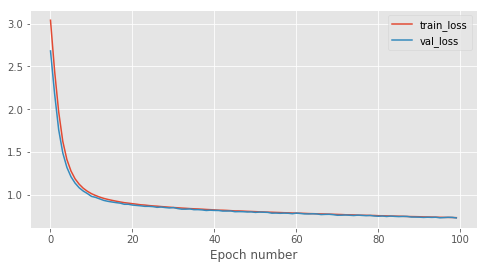

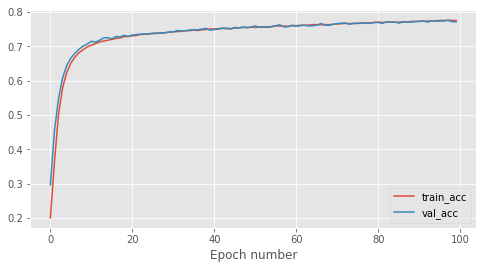

loss: 3.8552, accuracy: 0.0200:   0%|          | 1/1000 [00:00<00:18, 54.59it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 1.0258, accuracy: 0.6600:   1%|          | 10/1000 [00:00<00:17, 57.44it/s]

Epoch 0: train_acc_0.4975_train_loss_1.8069_val_acc_0.6716_val_loss_1.1061 epoch time 19.9601 seconds
total time0.0 : 19.960065126419067


loss: 0.9239, accuracy: 0.7000:   1%|          | 11/1000 [00:00<00:17, 57.52it/s]

Epoch 1: train_acc_0.6973_train_loss_1.0107_val_acc_0.7245_val_loss_0.9047 epoch time 19.7024 seconds
total time0.0 : 39.66246795654297


loss: 0.7739, accuracy: 0.7200:   1%|          | 11/1000 [00:00<00:17, 57.51it/s]

Epoch 2: train_acc_0.7377_train_loss_0.8628_val_acc_0.7593_val_loss_0.7827 epoch time 19.5817 seconds
total time0.0 : 59.244139194488525


loss: 0.6779, accuracy: 0.8000:   1%|          | 11/1000 [00:00<00:16, 58.26it/s]

Epoch 3: train_acc_0.7633_train_loss_0.7705_val_acc_0.7772_val_loss_0.7366 epoch time 19.6661 seconds
total time1.0 : 18.910264253616333


loss: 0.4573, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:16, 59.44it/s]

Epoch 4: train_acc_0.7812_train_loss_0.7027_val_acc_0.7891_val_loss_0.6866 epoch time 19.8291 seconds
total time1.0 : 38.73935627937317


loss: 0.7174, accuracy: 0.7600:   1%|          | 11/1000 [00:00<00:17, 57.78it/s]

Epoch 5: train_acc_0.7959_train_loss_0.6519_val_acc_0.8104_val_loss_0.6037 epoch time 19.0933 seconds
total time1.0 : 57.832632064819336


loss: 0.6042, accuracy: 0.8200:   1%|          | 11/1000 [00:00<00:16, 58.71it/s]

Epoch 6: train_acc_0.8051_train_loss_0.6147_val_acc_0.8092_val_loss_0.6001 epoch time 19.8879 seconds
total time2.0 : 17.7205708026886


loss: 0.6229, accuracy: 0.7400:   1%|          | 10/1000 [00:00<00:17, 56.03it/s]

Epoch 7: train_acc_0.8131_train_loss_0.5865_val_acc_0.8080_val_loss_0.6006 epoch time 19.6702 seconds
total time2.0 : 37.39074230194092


loss: 0.6766, accuracy: 0.8200:   1%|          | 11/1000 [00:00<00:16, 58.83it/s]

Epoch 8: train_acc_0.8197_train_loss_0.5637_val_acc_0.8305_val_loss_0.5306 epoch time 19.9251 seconds
total time2.0 : 57.31581258773804


loss: 0.4291, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:17, 57.58it/s]

Epoch 9: train_acc_0.8248_train_loss_0.5433_val_acc_0.8267_val_loss_0.5497 epoch time 19.6676 seconds
total time3.0 : 16.983453512191772


loss: 0.4182, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 57.63it/s]

Epoch 10: train_acc_0.8290_train_loss_0.5262_val_acc_0.8346_val_loss_0.5110 epoch time 19.8750 seconds
total time3.0 : 36.8584258556366


loss: 0.4381, accuracy: 0.8400:   1%|          | 10/1000 [00:00<00:17, 55.98it/s]

Epoch 11: train_acc_0.8335_train_loss_0.5120_val_acc_0.8352_val_loss_0.5071 epoch time 19.6916 seconds
total time3.0 : 56.550013065338135


loss: 0.3276, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.31it/s]

Epoch 12: train_acc_0.8366_train_loss_0.4998_val_acc_0.8374_val_loss_0.4942 epoch time 19.9293 seconds
total time4.0 : 16.47926688194275


loss: 0.5018, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:17, 57.24it/s]

Epoch 13: train_acc_0.8416_train_loss_0.4855_val_acc_0.8357_val_loss_0.4968 epoch time 19.6758 seconds
total time4.0 : 36.155102252960205


loss: 0.3549, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 57.68it/s]

Epoch 14: train_acc_0.8431_train_loss_0.4755_val_acc_0.8469_val_loss_0.4614 epoch time 19.9428 seconds
total time4.0 : 56.09790754318237


loss: 0.4636, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 59.09it/s]

Epoch 15: train_acc_0.8469_train_loss_0.4655_val_acc_0.8477_val_loss_0.4634 epoch time 19.6847 seconds
total time5.0 : 15.782558679580688


loss: 0.5692, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:17, 57.21it/s]

Epoch 16: train_acc_0.8479_train_loss_0.4582_val_acc_0.8508_val_loss_0.4516 epoch time 19.8493 seconds
total time5.0 : 35.6318678855896


loss: 0.5446, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 60.28it/s]

Epoch 17: train_acc_0.8508_train_loss_0.4492_val_acc_0.8404_val_loss_0.4599 epoch time 19.5603 seconds
total time5.0 : 55.19216346740723


loss: 0.5636, accuracy: 0.8000:   1%|          | 11/1000 [00:00<00:16, 59.55it/s]

Epoch 18: train_acc_0.8520_train_loss_0.4425_val_acc_0.8525_val_loss_0.4456 epoch time 19.7338 seconds
total time6.0 : 14.925932168960571


loss: 0.5380, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:17, 57.97it/s]

Epoch 19: train_acc_0.8549_train_loss_0.4348_val_acc_0.8599_val_loss_0.4249 epoch time 19.7001 seconds
total time6.0 : 34.62607741355896


loss: 0.2984, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 58.76it/s]

Epoch 20: train_acc_0.8569_train_loss_0.4294_val_acc_0.8577_val_loss_0.4267 epoch time 19.6689 seconds
total time6.0 : 54.295018672943115


loss: 0.2858, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 57.92it/s]

Epoch 21: train_acc_0.8582_train_loss_0.4232_val_acc_0.8574_val_loss_0.4205 epoch time 19.3851 seconds
total time7.0 : 13.68009352684021


loss: 0.4519, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.94it/s]

Epoch 22: train_acc_0.8595_train_loss_0.4180_val_acc_0.8596_val_loss_0.4177 epoch time 19.8151 seconds
total time7.0 : 33.495152950286865


loss: 0.4209, accuracy: 0.8500:   1%|          | 10/1000 [00:00<00:17, 56.41it/s]

Epoch 23: train_acc_0.8604_train_loss_0.4138_val_acc_0.8548_val_loss_0.4153 epoch time 19.6433 seconds
total time7.0 : 53.13849401473999


loss: 0.3050, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 57.53it/s]

Epoch 24: train_acc_0.8629_train_loss_0.4079_val_acc_0.8608_val_loss_0.4071 epoch time 19.9266 seconds
total time8.0 : 13.065135717391968


loss: 0.3231, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:17, 56.22it/s]

Epoch 25: train_acc_0.8624_train_loss_0.4039_val_acc_0.8638_val_loss_0.4054 epoch time 19.6679 seconds
total time8.0 : 32.73304009437561


loss: 0.3085, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.98it/s]

Epoch 26: train_acc_0.8648_train_loss_0.3992_val_acc_0.8634_val_loss_0.4013 epoch time 19.8928 seconds
total time8.0 : 52.62587547302246


loss: 0.3010, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:17, 57.36it/s]

Epoch 27: train_acc_0.8661_train_loss_0.3953_val_acc_0.8643_val_loss_0.4025 epoch time 19.6651 seconds
total time9.0 : 12.29093313217163


loss: 0.4695, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:16, 58.18it/s]

Epoch 28: train_acc_0.8664_train_loss_0.3920_val_acc_0.8621_val_loss_0.3996 epoch time 19.7920 seconds
total time9.0 : 32.0829656124115


loss: 0.4137, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:17, 57.09it/s]

Epoch 29: train_acc_0.8671_train_loss_0.3883_val_acc_0.8697_val_loss_0.3870 epoch time 19.6962 seconds
total time9.0 : 51.779125452041626


loss: 0.3358, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 57.51it/s]

Epoch 30: train_acc_0.8690_train_loss_0.3852_val_acc_0.8658_val_loss_0.3908 epoch time 19.8855 seconds
total time10.0 : 11.664629936218262


loss: 0.3457, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:17, 56.29it/s]

Epoch 31: train_acc_0.8699_train_loss_0.3825_val_acc_0.8690_val_loss_0.3905 epoch time 19.7146 seconds
total time10.0 : 31.379278421401978


loss: 0.3513, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 59.42it/s]

Epoch 32: train_acc_0.8700_train_loss_0.3803_val_acc_0.8665_val_loss_0.3839 epoch time 19.8066 seconds
total time10.0 : 51.18590474128723


loss: 0.4309, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:17, 55.64it/s]

Epoch 33: train_acc_0.8710_train_loss_0.3763_val_acc_0.8696_val_loss_0.3801 epoch time 19.3378 seconds
total time11.0 : 10.523697853088379


loss: 0.4056, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.77it/s]

Epoch 34: train_acc_0.8720_train_loss_0.3739_val_acc_0.8634_val_loss_0.3968 epoch time 19.8103 seconds
total time11.0 : 30.33401346206665


loss: 0.4073, accuracy: 0.8500:   1%|          | 10/1000 [00:00<00:17, 55.75it/s]

Epoch 35: train_acc_0.8723_train_loss_0.3725_val_acc_0.8727_val_loss_0.3735 epoch time 19.6717 seconds
total time11.0 : 50.00575375556946


loss: 0.2519, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 60.82it/s]

Epoch 36: train_acc_0.8734_train_loss_0.3697_val_acc_0.8703_val_loss_0.3784 epoch time 19.4336 seconds
total time12.0 : 9.439345359802246


loss: 0.3476, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:18, 54.46it/s]

Epoch 37: train_acc_0.8744_train_loss_0.3673_val_acc_0.8701_val_loss_0.3766 epoch time 19.7167 seconds
total time12.0 : 29.156084299087524


loss: 0.2019, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:17, 57.83it/s]

Epoch 38: train_acc_0.8742_train_loss_0.3650_val_acc_0.8727_val_loss_0.3729 epoch time 19.9370 seconds
total time12.0 : 49.0930392742157


loss: 0.2879, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.59it/s]

Epoch 39: train_acc_0.8756_train_loss_0.3633_val_acc_0.8661_val_loss_0.3797 epoch time 19.6125 seconds
total time13.0 : 8.705533981323242


loss: 0.2957, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 57.47it/s]

Epoch 40: train_acc_0.8763_train_loss_0.3608_val_acc_0.8742_val_loss_0.3692 epoch time 19.8702 seconds
total time13.0 : 28.575693130493164


loss: 0.2524, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:16, 59.64it/s]

Epoch 41: train_acc_0.8764_train_loss_0.3593_val_acc_0.8715_val_loss_0.3755 epoch time 19.6451 seconds
total time13.0 : 48.22078013420105


loss: 0.3350, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:16, 58.55it/s]

Epoch 42: train_acc_0.8762_train_loss_0.3576_val_acc_0.8701_val_loss_0.3718 epoch time 19.8746 seconds
total time14.0 : 8.095407247543335


loss: 0.4397, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 57.29it/s]

Epoch 43: train_acc_0.8769_train_loss_0.3561_val_acc_0.8732_val_loss_0.3666 epoch time 19.6996 seconds
total time14.0 : 27.795036792755127


loss: 0.2703, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.43it/s]

Epoch 44: train_acc_0.8761_train_loss_0.3547_val_acc_0.8743_val_loss_0.3645 epoch time 19.9498 seconds
total time14.0 : 47.74486684799194


loss: 0.3485, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 58.07it/s]

Epoch 45: train_acc_0.8787_train_loss_0.3523_val_acc_0.8720_val_loss_0.3667 epoch time 19.6656 seconds
total time15.0 : 7.410436153411865


loss: 0.4838, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 58.79it/s]

Epoch 46: train_acc_0.8788_train_loss_0.3515_val_acc_0.8765_val_loss_0.3604 epoch time 19.8515 seconds
total time15.0 : 27.261905431747437


loss: 0.1838, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:17, 56.86it/s]

Epoch 47: train_acc_0.8797_train_loss_0.3487_val_acc_0.8784_val_loss_0.3582 epoch time 19.6586 seconds
total time15.0 : 46.92045617103577


loss: 0.3053, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 60.46it/s]

Epoch 48: train_acc_0.8791_train_loss_0.3481_val_acc_0.8713_val_loss_0.3670 epoch time 19.7099 seconds
total time16.0 : 6.6303558349609375


loss: 0.3629, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:17, 56.78it/s]

Epoch 49: train_acc_0.8794_train_loss_0.3472_val_acc_0.8765_val_loss_0.3593 epoch time 19.5083 seconds
total time16.0 : 26.138678550720215


loss: 0.4539, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:17, 57.48it/s]

Epoch 50: train_acc_0.8801_train_loss_0.3451_val_acc_0.8751_val_loss_0.3580 epoch time 19.9118 seconds
total time16.0 : 46.05044722557068


loss: 0.4031, accuracy: 0.8400:   1%|          | 11/1000 [00:00<00:16, 59.54it/s]

Epoch 51: train_acc_0.8801_train_loss_0.3440_val_acc_0.8736_val_loss_0.3624 epoch time 19.7200 seconds
total time17.0 : 5.770482301712036


loss: 0.3726, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 57.29it/s]

Epoch 52: train_acc_0.8804_train_loss_0.3432_val_acc_0.8762_val_loss_0.3597 epoch time 19.5015 seconds
total time17.0 : 25.27203130722046


loss: 0.3862, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:17, 58.05it/s]

Epoch 53: train_acc_0.8815_train_loss_0.3415_val_acc_0.8789_val_loss_0.3524 epoch time 19.6737 seconds
total time17.0 : 44.94575500488281


loss: 0.3672, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 58.91it/s]

Epoch 54: train_acc_0.8821_train_loss_0.3395_val_acc_0.8747_val_loss_0.3603 epoch time 19.9002 seconds
total time18.0 : 4.845937252044678


loss: 0.2508, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 55.54it/s]

Epoch 55: train_acc_0.8806_train_loss_0.3392_val_acc_0.8760_val_loss_0.3565 epoch time 19.6594 seconds
total time18.0 : 24.505371570587158


loss: 0.4845, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:17, 56.76it/s]

Epoch 56: train_acc_0.8819_train_loss_0.3382_val_acc_0.8772_val_loss_0.3520 epoch time 19.9192 seconds
total time18.0 : 44.42455315589905


loss: 0.3023, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:17, 57.81it/s]

Epoch 57: train_acc_0.8822_train_loss_0.3366_val_acc_0.8794_val_loss_0.3569 epoch time 19.6340 seconds
total time19.0 : 4.058558940887451


loss: 0.3469, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 55.54it/s]

Epoch 58: train_acc_0.8828_train_loss_0.3358_val_acc_0.8786_val_loss_0.3495 epoch time 19.8362 seconds
total time19.0 : 23.894766807556152


loss: 0.2846, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.21it/s]

Epoch 59: train_acc_0.8824_train_loss_0.3348_val_acc_0.8786_val_loss_0.3491 epoch time 19.6259 seconds
total time19.0 : 43.52064108848572


loss: 0.2950, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:17, 56.47it/s]

Epoch 60: train_acc_0.8824_train_loss_0.3340_val_acc_0.8773_val_loss_0.3533 epoch time 19.8644 seconds
total time20.0 : 3.3850584030151367


loss: 0.3153, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:17, 57.31it/s]

Epoch 61: train_acc_0.8825_train_loss_0.3334_val_acc_0.8809_val_loss_0.3499 epoch time 19.6749 seconds
total time20.0 : 23.059935808181763


loss: 0.2892, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 58.67it/s]

Epoch 62: train_acc_0.8833_train_loss_0.3316_val_acc_0.8747_val_loss_0.3615 epoch time 19.9305 seconds
total time20.0 : 42.990442752838135


loss: 0.4046, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:17, 55.18it/s]

Epoch 63: train_acc_0.8838_train_loss_0.3314_val_acc_0.8796_val_loss_0.3489 epoch time 19.7000 seconds
total time21.0 : 2.6904549598693848


loss: 0.2849, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:17, 57.17it/s]

Epoch 64: train_acc_0.8843_train_loss_0.3293_val_acc_0.8744_val_loss_0.3555 epoch time 19.6536 seconds
total time21.0 : 22.344021320343018


loss: 0.4296, accuracy: 0.8300:   1%|          | 10/1000 [00:00<00:17, 56.82it/s]

Epoch 65: train_acc_0.8848_train_loss_0.3294_val_acc_0.8820_val_loss_0.3439 epoch time 19.6538 seconds
total time21.0 : 41.997843503952026


loss: 0.3009, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 59.00it/s]

Epoch 66: train_acc_0.8848_train_loss_0.3280_val_acc_0.8799_val_loss_0.3450 epoch time 20.0116 seconds
total time22.0 : 2.009483814239502


loss: 0.2509, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:17, 56.68it/s]

Epoch 67: train_acc_0.8851_train_loss_0.3269_val_acc_0.8803_val_loss_0.3542 epoch time 19.6053 seconds
total time22.0 : 21.614815950393677


loss: 0.3451, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:17, 57.21it/s]

Epoch 68: train_acc_0.8848_train_loss_0.3266_val_acc_0.8799_val_loss_0.3453 epoch time 19.5330 seconds
total time22.0 : 41.147820472717285


loss: 0.3855, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:17, 56.98it/s]

Epoch 69: train_acc_0.8859_train_loss_0.3251_val_acc_0.8805_val_loss_0.3440 epoch time 19.6655 seconds
total time23.0 : 0.813326358795166


loss: 0.2402, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:17, 57.16it/s]

Epoch 70: train_acc_0.8852_train_loss_0.3252_val_acc_0.8789_val_loss_0.3443 epoch time 19.9997 seconds
total time23.0 : 20.813069343566895


loss: 0.4217, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:17, 57.17it/s]

Epoch 71: train_acc_0.8857_train_loss_0.3235_val_acc_0.8790_val_loss_0.3496 epoch time 19.6509 seconds
total time23.0 : 40.46400213241577


loss: 0.1707, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:17, 57.25it/s]

Epoch 72: train_acc_0.8853_train_loss_0.3242_val_acc_0.8801_val_loss_0.3405 epoch time 19.8988 seconds
total time24.0 : 0.36275672912597656


loss: 0.4522, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 58.24it/s]

Epoch 73: train_acc_0.8864_train_loss_0.3221_val_acc_0.8801_val_loss_0.3473 epoch time 19.6878 seconds
total time24.0 : 20.050562620162964


loss: 0.4068, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:17, 55.06it/s]

Epoch 74: train_acc_0.8863_train_loss_0.3216_val_acc_0.8759_val_loss_0.3517 epoch time 19.7647 seconds
total time24.0 : 39.81526827812195


loss: 0.2873, accuracy: 0.9300:   1%|          | 11/1000 [00:00<00:17, 56.75it/s]

Epoch 75: train_acc_0.8869_train_loss_0.3203_val_acc_0.8823_val_loss_0.3395 epoch time 19.6938 seconds
total time24.0 : 59.50903630256653


loss: 0.3156, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 58.31it/s]

Epoch 76: train_acc_0.8866_train_loss_0.3201_val_acc_0.8798_val_loss_0.3404 epoch time 19.9831 seconds
total time25.0 : 19.492154121398926


loss: 0.3385, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:17, 56.89it/s]

Epoch 77: train_acc_0.8871_train_loss_0.3198_val_acc_0.8825_val_loss_0.3405 epoch time 19.5848 seconds
total time25.0 : 39.076945304870605


loss: 0.3824, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:16, 60.19it/s]

Epoch 78: train_acc_0.8875_train_loss_0.3190_val_acc_0.8809_val_loss_0.3383 epoch time 19.8525 seconds
total time25.0 : 58.92947483062744


loss: 0.2724, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:16, 59.17it/s]

Epoch 79: train_acc_0.8875_train_loss_0.3176_val_acc_0.8809_val_loss_0.3421 epoch time 19.4597 seconds
total time26.0 : 18.38920545578003


loss: 0.2240, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 58.06it/s]

Epoch 80: train_acc_0.8873_train_loss_0.3173_val_acc_0.8793_val_loss_0.3407 epoch time 19.7600 seconds
total time26.0 : 38.14923024177551


loss: 0.2963, accuracy: 0.8800:   1%|          | 11/1000 [00:00<00:16, 58.69it/s]

Epoch 81: train_acc_0.8877_train_loss_0.3173_val_acc_0.8803_val_loss_0.3385 epoch time 19.6604 seconds
total time26.0 : 57.80967354774475


loss: 0.2754, accuracy: 0.9200:   1%|          | 11/1000 [00:00<00:16, 58.46it/s]

Epoch 82: train_acc_0.8885_train_loss_0.3159_val_acc_0.8823_val_loss_0.3352 epoch time 19.8570 seconds
total time27.0 : 17.66670060157776


loss: 0.4319, accuracy: 0.8300:   1%|          | 11/1000 [00:00<00:16, 59.31it/s]

Epoch 83: train_acc_0.8877_train_loss_0.3164_val_acc_0.8825_val_loss_0.3387 epoch time 19.2584 seconds
total time27.0 : 36.92510223388672


loss: 0.3122, accuracy: 0.8900:   1%|          | 11/1000 [00:00<00:17, 57.10it/s]

Epoch 84: train_acc_0.8883_train_loss_0.3153_val_acc_0.8818_val_loss_0.3390 epoch time 19.7453 seconds
total time27.0 : 56.67040467262268


loss: 0.1936, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:17, 56.36it/s]

Epoch 85: train_acc_0.8882_train_loss_0.3145_val_acc_0.8809_val_loss_0.3380 epoch time 19.6943 seconds
total time28.0 : 16.36468529701233


loss: 0.2366, accuracy: 0.9200:   1%|          | 10/1000 [00:00<00:17, 57.62it/s]

Epoch 86: train_acc_0.8882_train_loss_0.3137_val_acc_0.8805_val_loss_0.3394 epoch time 19.9079 seconds
total time28.0 : 36.27255320549011


loss: 0.1829, accuracy: 0.9400:   1%|          | 10/1000 [00:00<00:17, 55.73it/s]

Epoch 87: train_acc_0.8892_train_loss_0.3132_val_acc_0.8827_val_loss_0.3351 epoch time 19.6496 seconds
total time28.0 : 55.92216348648071


loss: 0.4561, accuracy: 0.8700:   1%|          | 11/1000 [00:00<00:17, 57.79it/s]

Epoch 88: train_acc_0.8898_train_loss_0.3118_val_acc_0.8796_val_loss_0.3441 epoch time 19.8754 seconds
total time29.0 : 15.797552347183228


loss: 0.3137, accuracy: 0.8900:   1%|          | 10/1000 [00:00<00:17, 56.79it/s]

Epoch 89: train_acc_0.8891_train_loss_0.3124_val_acc_0.8841_val_loss_0.3310 epoch time 19.6167 seconds
total time29.0 : 35.41424775123596


loss: 0.2586, accuracy: 0.8600:   1%|          | 11/1000 [00:00<00:17, 58.01it/s]

Epoch 90: train_acc_0.8892_train_loss_0.3112_val_acc_0.8796_val_loss_0.3395 epoch time 19.8718 seconds
total time29.0 : 55.286075592041016


loss: 0.3946, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:17, 57.93it/s]

Epoch 91: train_acc_0.8900_train_loss_0.3107_val_acc_0.8804_val_loss_0.3356 epoch time 19.6434 seconds
total time30.0 : 14.92946171760559


loss: 0.2510, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 58.62it/s]

Epoch 92: train_acc_0.8898_train_loss_0.3100_val_acc_0.8830_val_loss_0.3331 epoch time 19.8240 seconds
total time30.0 : 34.75347828865051


loss: 0.3971, accuracy: 0.8600:   1%|          | 10/1000 [00:00<00:17, 56.24it/s]

Epoch 93: train_acc_0.8903_train_loss_0.3103_val_acc_0.8834_val_loss_0.3377 epoch time 19.6027 seconds
total time30.0 : 54.356162548065186


loss: 0.2400, accuracy: 0.9000:   1%|          | 11/1000 [00:00<00:16, 58.46it/s]

Epoch 94: train_acc_0.8893_train_loss_0.3096_val_acc_0.8803_val_loss_0.3363 epoch time 19.9504 seconds
total time31.0 : 14.306535959243774


loss: 0.2624, accuracy: 0.9000:   1%|          | 10/1000 [00:00<00:17, 56.71it/s]

Epoch 95: train_acc_0.8900_train_loss_0.3095_val_acc_0.8770_val_loss_0.3409 epoch time 19.3830 seconds
total time31.0 : 33.68956804275513


loss: 0.2204, accuracy: 0.9100:   1%|          | 11/1000 [00:00<00:16, 58.92it/s]

Epoch 96: train_acc_0.8904_train_loss_0.3078_val_acc_0.8823_val_loss_0.3338 epoch time 19.8523 seconds
total time31.0 : 53.541831970214844


loss: 0.2131, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:17, 56.53it/s]

Epoch 97: train_acc_0.8915_train_loss_0.3073_val_acc_0.8840_val_loss_0.3319 epoch time 19.6260 seconds
total time32.0 : 13.167824506759644


loss: 0.3786, accuracy: 0.8500:   1%|          | 11/1000 [00:00<00:17, 57.20it/s]

Epoch 98: train_acc_0.8914_train_loss_0.3072_val_acc_0.8841_val_loss_0.3311 epoch time 19.9295 seconds
total time32.0 : 33.09729814529419


loss: 0.3121, accuracy: 0.9000:  13%|█▎        | 21/158 [00:00<00:01, 111.82it/s]

Epoch 99: train_acc_0.8915_train_loss_0.3071_val_acc_0.8842_val_loss_0.3317 epoch time 19.1670 seconds
total time32.0 : 52.26432991027832
Generating test set evaluation metrics


loss: 0.3129, accuracy: 0.8900: 100%|██████████| 158/158 [00:01<00:00, 101.38it/s]


finish


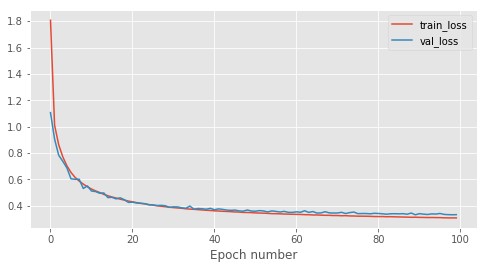

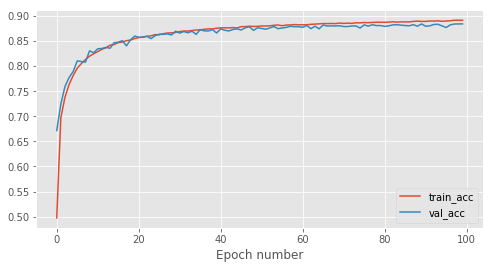

  0%|          | 0/1000 [00:00<?, ?it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.7618, accuracy: 0.7400:   1%|          | 9/1000 [00:00<00:19, 50.07it/s]

Epoch 0: train_acc_0.5560_train_loss_1.5524_val_acc_0.7575_val_loss_0.7816 epoch time 22.3856 seconds
total time0.0 : 22.385605573654175


loss: 0.8209, accuracy: 0.7600:   1%|          | 9/1000 [00:00<00:19, 50.06it/s]

Epoch 1: train_acc_0.7765_train_loss_0.7006_val_acc_0.8110_val_loss_0.5906 epoch time 22.2526 seconds
total time0.0 : 44.63825535774231


loss: 0.5012, accuracy: 0.7900:   1%|          | 9/1000 [00:00<00:20, 49.40it/s]

Epoch 2: train_acc_0.8076_train_loss_0.5879_val_acc_0.8208_val_loss_0.5322 epoch time 22.2810 seconds
total time1.0 : 6.9192094802856445


loss: 0.4498, accuracy: 0.8200:   1%|          | 9/1000 [00:00<00:19, 50.45it/s]

Epoch 3: train_acc_0.8237_train_loss_0.5297_val_acc_0.8312_val_loss_0.4933 epoch time 22.2477 seconds
total time1.0 : 29.166890621185303


loss: 0.3894, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 50.25it/s]

Epoch 4: train_acc_0.8343_train_loss_0.4925_val_acc_0.8295_val_loss_0.4860 epoch time 22.1970 seconds
total time1.0 : 51.36389946937561


loss: 0.4508, accuracy: 0.8100:   1%|          | 9/1000 [00:00<00:19, 50.82it/s]

Epoch 5: train_acc_0.8428_train_loss_0.4636_val_acc_0.8519_val_loss_0.4321 epoch time 22.2543 seconds
total time2.0 : 13.618226528167725


loss: 0.4449, accuracy: 0.8000:   1%|          | 9/1000 [00:00<00:19, 50.87it/s]

Epoch 6: train_acc_0.8496_train_loss_0.4426_val_acc_0.8423_val_loss_0.4505 epoch time 22.2253 seconds
total time2.0 : 35.8434898853302


loss: 0.4738, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:20, 49.37it/s]

Epoch 7: train_acc_0.8542_train_loss_0.4217_val_acc_0.8609_val_loss_0.4016 epoch time 22.2496 seconds
total time2.0 : 58.093111753463745


loss: 0.3510, accuracy: 0.8300:   1%|          | 9/1000 [00:00<00:20, 49.36it/s]

Epoch 8: train_acc_0.8599_train_loss_0.4099_val_acc_0.8616_val_loss_0.3831 epoch time 22.2765 seconds
total time3.0 : 20.36961269378662


loss: 0.3429, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.75it/s]

Epoch 9: train_acc_0.8636_train_loss_0.3952_val_acc_0.8663_val_loss_0.3888 epoch time 22.0908 seconds
total time3.0 : 42.46038246154785


loss: 0.3821, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:19, 51.26it/s]

Epoch 10: train_acc_0.8672_train_loss_0.3842_val_acc_0.8721_val_loss_0.3729 epoch time 22.3369 seconds
total time4.0 : 4.797328233718872


loss: 0.2833, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.34it/s]

Epoch 11: train_acc_0.8693_train_loss_0.3759_val_acc_0.8716_val_loss_0.3665 epoch time 22.2377 seconds
total time4.0 : 27.035030364990234


loss: 0.2999, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.88it/s]

Epoch 12: train_acc_0.8734_train_loss_0.3656_val_acc_0.8771_val_loss_0.3557 epoch time 22.2733 seconds
total time4.0 : 49.3083701133728


loss: 0.3411, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 50.49it/s]

Epoch 13: train_acc_0.8732_train_loss_0.3579_val_acc_0.8764_val_loss_0.3609 epoch time 21.8782 seconds
total time5.0 : 11.186580657958984


loss: 0.2559, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 49.67it/s]

Epoch 14: train_acc_0.8756_train_loss_0.3517_val_acc_0.8774_val_loss_0.3503 epoch time 22.3385 seconds
total time5.0 : 33.52503991127014


loss: 0.2804, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 49.40it/s]

Epoch 15: train_acc_0.8779_train_loss_0.3451_val_acc_0.8780_val_loss_0.3490 epoch time 22.3490 seconds
total time5.0 : 55.873998403549194


loss: 0.2827, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:20, 48.77it/s]

Epoch 16: train_acc_0.8794_train_loss_0.3399_val_acc_0.8758_val_loss_0.3483 epoch time 22.3353 seconds
total time6.0 : 18.209266185760498


loss: 0.2859, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 50.66it/s]

Epoch 17: train_acc_0.8810_train_loss_0.3329_val_acc_0.8787_val_loss_0.3483 epoch time 22.2106 seconds
total time6.0 : 40.419910192489624


loss: 0.3155, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 49.70it/s]

Epoch 18: train_acc_0.8829_train_loss_0.3304_val_acc_0.8786_val_loss_0.3536 epoch time 22.2290 seconds
total time7.0 : 2.648932933807373


loss: 0.2175, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.99it/s]

Epoch 19: train_acc_0.8841_train_loss_0.3244_val_acc_0.8791_val_loss_0.3451 epoch time 22.4627 seconds
total time7.0 : 25.11164903640747


loss: 0.2198, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.63it/s]

Epoch 20: train_acc_0.8853_train_loss_0.3207_val_acc_0.8823_val_loss_0.3287 epoch time 22.3174 seconds
total time7.0 : 47.42907691001892


loss: 0.3678, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:19, 51.07it/s]

Epoch 21: train_acc_0.8863_train_loss_0.3170_val_acc_0.8775_val_loss_0.3552 epoch time 22.3332 seconds
total time8.0 : 9.762235403060913


loss: 0.2151, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.74it/s]

Epoch 22: train_acc_0.8875_train_loss_0.3127_val_acc_0.8823_val_loss_0.3372 epoch time 22.2931 seconds
total time8.0 : 32.05535674095154


loss: 0.3544, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 50.34it/s]

Epoch 23: train_acc_0.8891_train_loss_0.3078_val_acc_0.8822_val_loss_0.3313 epoch time 22.0926 seconds
total time8.0 : 54.14795398712158


loss: 0.2209, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 49.93it/s]

Epoch 24: train_acc_0.8893_train_loss_0.3061_val_acc_0.8810_val_loss_0.3336 epoch time 22.2951 seconds
total time9.0 : 16.443090438842773


loss: 0.5524, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:19, 50.18it/s]

Epoch 25: train_acc_0.8900_train_loss_0.3033_val_acc_0.8839_val_loss_0.3253 epoch time 22.2607 seconds
total time9.0 : 38.70375990867615


loss: 0.2195, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 49.41it/s]

Epoch 26: train_acc_0.8912_train_loss_0.3003_val_acc_0.8796_val_loss_0.3388 epoch time 22.3192 seconds
total time10.0 : 1.022944688796997


loss: 0.3295, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 49.65it/s]

Epoch 27: train_acc_0.8921_train_loss_0.2967_val_acc_0.8820_val_loss_0.3267 epoch time 21.8516 seconds
total time10.0 : 22.874537229537964


loss: 0.2732, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 50.62it/s]

Epoch 28: train_acc_0.8929_train_loss_0.2941_val_acc_0.8836_val_loss_0.3198 epoch time 22.2581 seconds
total time10.0 : 45.132606744766235


loss: 0.3189, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 51.85it/s]

Epoch 29: train_acc_0.8928_train_loss_0.2926_val_acc_0.8854_val_loss_0.3246 epoch time 22.3221 seconds
total time11.0 : 7.454723119735718


loss: 0.2452, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.05it/s]

Epoch 30: train_acc_0.8942_train_loss_0.2889_val_acc_0.8849_val_loss_0.3267 epoch time 22.2877 seconds
total time11.0 : 29.742398262023926


loss: 0.1901, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 49.84it/s]

Epoch 31: train_acc_0.8958_train_loss_0.2868_val_acc_0.8852_val_loss_0.3191 epoch time 22.2706 seconds
total time11.0 : 52.01304006576538


loss: 0.2257, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.92it/s]

Epoch 32: train_acc_0.8957_train_loss_0.2842_val_acc_0.8841_val_loss_0.3233 epoch time 22.2955 seconds
total time12.0 : 14.308532476425171


loss: 0.2359, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 50.28it/s]

Epoch 33: train_acc_0.8967_train_loss_0.2816_val_acc_0.8884_val_loss_0.3122 epoch time 22.2895 seconds
total time12.0 : 36.598007678985596


loss: 0.2085, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 50.84it/s]

Epoch 34: train_acc_0.8979_train_loss_0.2798_val_acc_0.8866_val_loss_0.3182 epoch time 22.3083 seconds
total time12.0 : 58.90634059906006


loss: 0.1921, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.51it/s]

Epoch 35: train_acc_0.8982_train_loss_0.2777_val_acc_0.8849_val_loss_0.3284 epoch time 22.2012 seconds
total time13.0 : 21.107590436935425


loss: 0.3683, accuracy: 0.9100:   1%|          | 10/1000 [00:00<00:19, 51.55it/s]

Epoch 36: train_acc_0.8983_train_loss_0.2750_val_acc_0.8883_val_loss_0.3183 epoch time 22.2742 seconds
total time13.0 : 43.38179087638855


loss: 0.2508, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:20, 49.40it/s]

Epoch 37: train_acc_0.9003_train_loss_0.2733_val_acc_0.8859_val_loss_0.3226 epoch time 22.0146 seconds
total time14.0 : 5.396349191665649


loss: 0.2084, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.82it/s]

Epoch 38: train_acc_0.8995_train_loss_0.2728_val_acc_0.8856_val_loss_0.3225 epoch time 22.2947 seconds
total time14.0 : 27.691008806228638


loss: 0.3274, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:19, 50.46it/s]

Epoch 39: train_acc_0.9006_train_loss_0.2702_val_acc_0.8847_val_loss_0.3187 epoch time 22.2266 seconds
total time14.0 : 49.9175751209259


loss: 0.2491, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 51.09it/s]

Epoch 40: train_acc_0.9003_train_loss_0.2686_val_acc_0.8872_val_loss_0.3241 epoch time 22.2866 seconds
total time15.0 : 12.20414400100708


loss: 0.2935, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:20, 48.58it/s]

Epoch 41: train_acc_0.9018_train_loss_0.2669_val_acc_0.8878_val_loss_0.3144 epoch time 22.0038 seconds
total time15.0 : 34.20792555809021


loss: 0.2766, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:19, 49.85it/s]

Epoch 42: train_acc_0.9019_train_loss_0.2643_val_acc_0.8872_val_loss_0.3168 epoch time 22.3112 seconds
total time15.0 : 56.51911163330078


loss: 0.2251, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 49.44it/s]

Epoch 43: train_acc_0.9027_train_loss_0.2634_val_acc_0.8909_val_loss_0.3132 epoch time 22.3364 seconds
total time16.0 : 18.855510711669922


loss: 0.3498, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 48.76it/s]

Epoch 44: train_acc_0.9029_train_loss_0.2615_val_acc_0.8892_val_loss_0.3147 epoch time 22.2486 seconds
total time16.0 : 41.10411310195923


loss: 0.1917, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 49.24it/s]

Epoch 45: train_acc_0.9035_train_loss_0.2597_val_acc_0.8877_val_loss_0.3173 epoch time 22.3062 seconds
total time17.0 : 3.4103376865386963


loss: 0.2738, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 51.87it/s]

Epoch 46: train_acc_0.9036_train_loss_0.2583_val_acc_0.8887_val_loss_0.3155 epoch time 22.3217 seconds
total time17.0 : 25.732025384902954


loss: 0.2062, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 49.44it/s]

Epoch 47: train_acc_0.9046_train_loss_0.2564_val_acc_0.8854_val_loss_0.3288 epoch time 22.3259 seconds
total time17.0 : 48.05790400505066


loss: 0.2166, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.93it/s]

Epoch 48: train_acc_0.9040_train_loss_0.2559_val_acc_0.8830_val_loss_0.3207 epoch time 22.3202 seconds
total time18.0 : 10.378108501434326


loss: 0.1842, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.59it/s]

Epoch 49: train_acc_0.9057_train_loss_0.2540_val_acc_0.8856_val_loss_0.3216 epoch time 22.2740 seconds
total time18.0 : 32.6521475315094


loss: 0.1706, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.76it/s]

Epoch 50: train_acc_0.9061_train_loss_0.2517_val_acc_0.8882_val_loss_0.3154 epoch time 22.0223 seconds
total time18.0 : 54.67442464828491


loss: 0.1705, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.80it/s]

Epoch 51: train_acc_0.9054_train_loss_0.2508_val_acc_0.8896_val_loss_0.3136 epoch time 22.3740 seconds
total time19.0 : 17.048393964767456


loss: 0.1908, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.16it/s]

Epoch 52: train_acc_0.9067_train_loss_0.2491_val_acc_0.8861_val_loss_0.3171 epoch time 22.3991 seconds
total time19.0 : 39.44748830795288


loss: 0.1495, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 51.67it/s]

Epoch 53: train_acc_0.9068_train_loss_0.2488_val_acc_0.8870_val_loss_0.3155 epoch time 22.2195 seconds
total time20.0 : 1.6670148372650146


loss: 0.2328, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 49.21it/s]

Epoch 54: train_acc_0.9069_train_loss_0.2473_val_acc_0.8897_val_loss_0.3193 epoch time 22.1750 seconds
total time20.0 : 23.842049598693848


loss: 0.1592, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 49.93it/s]

Epoch 55: train_acc_0.9073_train_loss_0.2456_val_acc_0.8874_val_loss_0.3194 epoch time 21.8407 seconds
total time20.0 : 45.68271517753601


loss: 0.1449, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 49.98it/s]

Epoch 56: train_acc_0.9080_train_loss_0.2447_val_acc_0.8840_val_loss_0.3303 epoch time 22.4134 seconds
total time21.0 : 8.096157550811768


loss: 0.1907, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.72it/s]

Epoch 57: train_acc_0.9080_train_loss_0.2437_val_acc_0.8849_val_loss_0.3252 epoch time 22.4040 seconds
total time21.0 : 30.500153064727783


loss: 0.2331, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 50.70it/s]

Epoch 58: train_acc_0.9082_train_loss_0.2428_val_acc_0.8884_val_loss_0.3176 epoch time 22.2717 seconds
total time21.0 : 52.771852254867554


loss: 0.2058, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 49.96it/s]

Epoch 59: train_acc_0.9090_train_loss_0.2408_val_acc_0.8872_val_loss_0.3193 epoch time 22.3608 seconds
total time22.0 : 15.13262152671814


loss: 0.2624, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:19, 50.62it/s]

Epoch 60: train_acc_0.9097_train_loss_0.2393_val_acc_0.8846_val_loss_0.3329 epoch time 22.2100 seconds
total time22.0 : 37.34264636039734


loss: 0.1166, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.99it/s]

Epoch 61: train_acc_0.9100_train_loss_0.2377_val_acc_0.8865_val_loss_0.3218 epoch time 22.1547 seconds
total time22.0 : 59.49735736846924


loss: 0.1399, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.55it/s]

Epoch 62: train_acc_0.9097_train_loss_0.2382_val_acc_0.8864_val_loss_0.3283 epoch time 22.3305 seconds
total time23.0 : 21.827842473983765


loss: 0.2039, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 48.47it/s]

Epoch 63: train_acc_0.9099_train_loss_0.2365_val_acc_0.8881_val_loss_0.3162 epoch time 22.2745 seconds
total time23.0 : 44.102317810058594


loss: 0.2091, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.38it/s]

Epoch 64: train_acc_0.9106_train_loss_0.2352_val_acc_0.8859_val_loss_0.3358 epoch time 22.1664 seconds
total time24.0 : 6.268765211105347


loss: 0.2849, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 50.42it/s]

Epoch 65: train_acc_0.9114_train_loss_0.2338_val_acc_0.8889_val_loss_0.3225 epoch time 22.3841 seconds
total time24.0 : 28.6529061794281


loss: 0.1731, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 49.23it/s]

Epoch 66: train_acc_0.9113_train_loss_0.2326_val_acc_0.8910_val_loss_0.3258 epoch time 22.3399 seconds
total time24.0 : 50.99284076690674


loss: 0.1897, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.77it/s]

Epoch 67: train_acc_0.9118_train_loss_0.2317_val_acc_0.8863_val_loss_0.3285 epoch time 22.2988 seconds
total time25.0 : 13.291663408279419


loss: 0.1472, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.88it/s]

Epoch 68: train_acc_0.9124_train_loss_0.2310_val_acc_0.8916_val_loss_0.3166 epoch time 22.3481 seconds
total time25.0 : 35.6397922039032


loss: 0.1893, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.29it/s]

Epoch 69: train_acc_0.9122_train_loss_0.2293_val_acc_0.8765_val_loss_0.3525 epoch time 21.9857 seconds
total time25.0 : 57.625468492507935


loss: 0.3049, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 50.75it/s]

Epoch 70: train_acc_0.9121_train_loss_0.2285_val_acc_0.8861_val_loss_0.3217 epoch time 22.2713 seconds
total time26.0 : 19.896777868270874


loss: 0.1135, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 49.67it/s]

Epoch 71: train_acc_0.9132_train_loss_0.2280_val_acc_0.8887_val_loss_0.3222 epoch time 22.2769 seconds
total time26.0 : 42.17369294166565


loss: 0.1987, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.25it/s]

Epoch 72: train_acc_0.9143_train_loss_0.2262_val_acc_0.8860_val_loss_0.3360 epoch time 22.3503 seconds
total time27.0 : 4.5239458084106445


loss: 0.2137, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 49.61it/s]

Epoch 73: train_acc_0.9137_train_loss_0.2259_val_acc_0.8831_val_loss_0.3393 epoch time 22.2750 seconds
total time27.0 : 26.798952102661133


loss: 0.2737, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 49.94it/s]

Epoch 74: train_acc_0.9138_train_loss_0.2253_val_acc_0.8826_val_loss_0.3364 epoch time 22.3540 seconds
total time27.0 : 49.15296411514282


loss: 0.2987, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.37it/s]

Epoch 75: train_acc_0.9139_train_loss_0.2241_val_acc_0.8864_val_loss_0.3358 epoch time 22.3368 seconds
total time28.0 : 11.489757537841797


loss: 0.2113, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.35it/s]

Epoch 76: train_acc_0.9136_train_loss_0.2227_val_acc_0.8880_val_loss_0.3244 epoch time 22.2180 seconds
total time28.0 : 33.7077693939209


loss: 0.2585, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 49.73it/s]

Epoch 77: train_acc_0.9148_train_loss_0.2215_val_acc_0.8830_val_loss_0.3389 epoch time 22.2524 seconds
total time28.0 : 55.96018719673157


loss: 0.2380, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 48.85it/s]

Epoch 78: train_acc_0.9149_train_loss_0.2203_val_acc_0.8889_val_loss_0.3263 epoch time 22.0118 seconds
total time29.0 : 17.972007989883423


loss: 0.1358, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.70it/s]

Epoch 79: train_acc_0.9157_train_loss_0.2192_val_acc_0.8878_val_loss_0.3302 epoch time 22.3062 seconds
total time29.0 : 40.27825093269348


loss: 0.2564, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 48.61it/s]

Epoch 80: train_acc_0.9160_train_loss_0.2197_val_acc_0.8846_val_loss_0.3302 epoch time 22.2463 seconds
total time30.0 : 2.5245726108551025


loss: 0.1980, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.73it/s]

Epoch 81: train_acc_0.9155_train_loss_0.2187_val_acc_0.8843_val_loss_0.3326 epoch time 22.2217 seconds
total time30.0 : 24.746249437332153


loss: 0.2012, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 49.95it/s]

Epoch 82: train_acc_0.9151_train_loss_0.2177_val_acc_0.8874_val_loss_0.3307 epoch time 22.2704 seconds
total time30.0 : 47.0166757106781


loss: 0.2319, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:19, 50.99it/s]

Epoch 83: train_acc_0.9166_train_loss_0.2170_val_acc_0.8865_val_loss_0.3332 epoch time 21.8671 seconds
total time31.0 : 8.883737802505493


loss: 0.2003, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 51.53it/s]

Epoch 84: train_acc_0.9175_train_loss_0.2151_val_acc_0.8828_val_loss_0.3401 epoch time 22.3141 seconds
total time31.0 : 31.197865962982178


loss: 0.1498, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 50.14it/s]

Epoch 85: train_acc_0.9175_train_loss_0.2142_val_acc_0.8840_val_loss_0.3382 epoch time 22.4020 seconds
total time31.0 : 53.599913597106934


loss: 0.1909, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:19, 51.24it/s]

Epoch 86: train_acc_0.9169_train_loss_0.2142_val_acc_0.8826_val_loss_0.3485 epoch time 22.2306 seconds
total time32.0 : 15.830469608306885


loss: 0.2140, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.63it/s]

Epoch 87: train_acc_0.9173_train_loss_0.2130_val_acc_0.8880_val_loss_0.3288 epoch time 22.2122 seconds
total time32.0 : 38.04267072677612


loss: 0.2182, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 50.38it/s]

Epoch 88: train_acc_0.9178_train_loss_0.2128_val_acc_0.8849_val_loss_0.3350 epoch time 22.1664 seconds
total time33.0 : 0.20910167694091797


loss: 0.1357, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 51.07it/s]

Epoch 89: train_acc_0.9183_train_loss_0.2119_val_acc_0.8829_val_loss_0.3436 epoch time 22.1707 seconds
total time33.0 : 22.379773139953613


loss: 0.2875, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:19, 50.94it/s]

Epoch 90: train_acc_0.9171_train_loss_0.2107_val_acc_0.8807_val_loss_0.3465 epoch time 22.2110 seconds
total time33.0 : 44.59073519706726


loss: 0.2254, accuracy: 0.8800:   1%|          | 10/1000 [00:00<00:18, 52.64it/s]

Epoch 91: train_acc_0.9181_train_loss_0.2105_val_acc_0.8819_val_loss_0.3509 epoch time 22.1014 seconds
total time34.0 : 6.692092180252075


loss: 0.2128, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 50.25it/s]

Epoch 92: train_acc_0.9193_train_loss_0.2089_val_acc_0.8849_val_loss_0.3465 epoch time 22.1417 seconds
total time34.0 : 28.833813905715942


loss: 0.1120, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:19, 49.62it/s]

Epoch 93: train_acc_0.9194_train_loss_0.2081_val_acc_0.8841_val_loss_0.3446 epoch time 22.2717 seconds
total time34.0 : 51.10550808906555


loss: 0.1806, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:19, 50.34it/s]

Epoch 94: train_acc_0.9191_train_loss_0.2080_val_acc_0.8843_val_loss_0.3441 epoch time 22.3220 seconds
total time35.0 : 13.427509546279907


loss: 0.2277, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:19, 49.89it/s]

Epoch 95: train_acc_0.9199_train_loss_0.2070_val_acc_0.8818_val_loss_0.3495 epoch time 22.2972 seconds
total time35.0 : 35.724698066711426


loss: 0.3046, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 50.70it/s]

Epoch 96: train_acc_0.9202_train_loss_0.2063_val_acc_0.8856_val_loss_0.3377 epoch time 22.2686 seconds
total time35.0 : 57.99325776100159


loss: 0.1369, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:19, 49.98it/s]

Epoch 97: train_acc_0.9196_train_loss_0.2056_val_acc_0.8858_val_loss_0.3397 epoch time 21.7663 seconds
total time36.0 : 19.759580373764038


loss: 0.2070, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:19, 49.73it/s]

Epoch 98: train_acc_0.9214_train_loss_0.2041_val_acc_0.8841_val_loss_0.3437 epoch time 22.3073 seconds
total time36.0 : 42.0669264793396


loss: 0.1598, accuracy: 0.9300:  12%|█▏        | 19/158 [00:00<00:01, 103.15it/s]

Epoch 99: train_acc_0.9213_train_loss_0.2040_val_acc_0.8834_val_loss_0.3423 epoch time 22.2612 seconds
total time37.0 : 4.328168630599976
Generating test set evaluation metrics


loss: 0.3346, accuracy: 0.9000: 100%|██████████| 158/158 [00:01<00:00, 94.80it/s]


finish


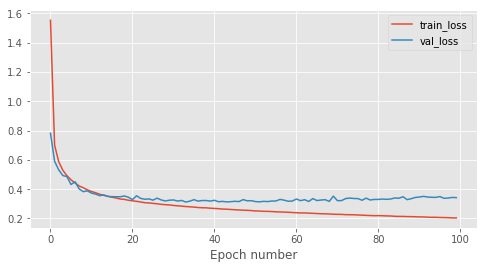

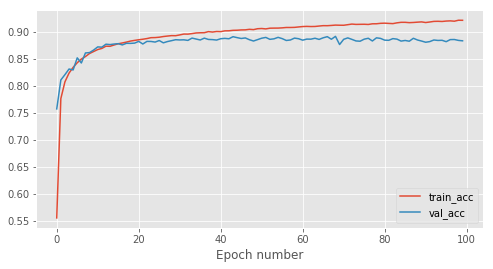

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])


loss: 3.8512, accuracy: 0.0200:   1%|          | 8/1000 [00:00<00:22, 44.59it/s]

torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_3): AvgPool2d(kernel_size=2, stride=2, padding=1)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.6785, accuracy: 0.8100:   1%|          | 9/1000 [00:00<00:20, 47.32it/s]

Epoch 0: train_acc_0.5087_train_loss_1.6850_val_acc_0.7175_val_loss_0.8710 epoch time 23.9700 seconds
total time0.0 : 23.970008611679077


loss: 0.7217, accuracy: 0.7900:   1%|          | 9/1000 [00:00<00:21, 47.06it/s]

Epoch 1: train_acc_0.7677_train_loss_0.7230_val_acc_0.8075_val_loss_0.5825 epoch time 23.8749 seconds
total time0.0 : 47.84490895271301


loss: 0.5479, accuracy: 0.8200:   1%|          | 8/1000 [00:00<00:21, 46.42it/s]

Epoch 2: train_acc_0.8058_train_loss_0.5875_val_acc_0.8221_val_loss_0.5137 epoch time 23.8838 seconds
total time1.0 : 11.728717565536499


loss: 0.4041, accuracy: 0.8500:   1%|          | 8/1000 [00:00<00:21, 46.65it/s]

Epoch 3: train_acc_0.8260_train_loss_0.5187_val_acc_0.8313_val_loss_0.4903 epoch time 23.9047 seconds
total time1.0 : 35.63340163230896


loss: 0.4097, accuracy: 0.8300:   1%|          | 9/1000 [00:00<00:20, 47.30it/s]

Epoch 4: train_acc_0.8383_train_loss_0.4725_val_acc_0.8378_val_loss_0.4583 epoch time 23.9666 seconds
total time1.0 : 59.600037813186646


loss: 0.5851, accuracy: 0.7700:   1%|          | 9/1000 [00:00<00:21, 46.88it/s]

Epoch 5: train_acc_0.8470_train_loss_0.4429_val_acc_0.8508_val_loss_0.4214 epoch time 23.6833 seconds
total time2.0 : 23.28334069252014


loss: 0.4839, accuracy: 0.8000:   1%|          | 8/1000 [00:00<00:21, 46.45it/s]

Epoch 6: train_acc_0.8547_train_loss_0.4197_val_acc_0.8585_val_loss_0.4082 epoch time 23.8989 seconds
total time2.0 : 47.182278633117676


loss: 0.2787, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.41it/s]

Epoch 7: train_acc_0.8598_train_loss_0.4016_val_acc_0.8604_val_loss_0.3976 epoch time 23.8951 seconds
total time3.0 : 11.077357292175293


loss: 0.3429, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:20, 47.39it/s]

Epoch 8: train_acc_0.8640_train_loss_0.3853_val_acc_0.8724_val_loss_0.3708 epoch time 23.8421 seconds
total time3.0 : 34.91944217681885


loss: 0.4006, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:21, 47.06it/s]

Epoch 9: train_acc_0.8686_train_loss_0.3711_val_acc_0.8701_val_loss_0.3702 epoch time 23.9112 seconds
total time3.0 : 58.830610036849976


loss: 0.3838, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 45.57it/s]

Epoch 10: train_acc_0.8718_train_loss_0.3583_val_acc_0.8674_val_loss_0.3706 epoch time 23.4492 seconds
total time4.0 : 22.279773712158203


loss: 0.3076, accuracy: 0.9000:   1%|          | 8/1000 [00:00<00:21, 46.71it/s]

Epoch 11: train_acc_0.8744_train_loss_0.3490_val_acc_0.8760_val_loss_0.3619 epoch time 23.9164 seconds
total time4.0 : 46.19621801376343


loss: 0.2288, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:21, 46.79it/s]

Epoch 12: train_acc_0.8770_train_loss_0.3411_val_acc_0.8673_val_loss_0.3703 epoch time 23.9000 seconds
total time5.0 : 10.096191167831421


loss: 0.2701, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 46.44it/s]

Epoch 13: train_acc_0.8796_train_loss_0.3305_val_acc_0.8709_val_loss_0.3482 epoch time 23.9598 seconds
total time5.0 : 34.05597710609436


loss: 0.4166, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:21, 46.88it/s]

Epoch 14: train_acc_0.8827_train_loss_0.3228_val_acc_0.8784_val_loss_0.3393 epoch time 23.9099 seconds
total time5.0 : 57.96583414077759


loss: 0.3890, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:21, 46.94it/s]

Epoch 15: train_acc_0.8857_train_loss_0.3152_val_acc_0.8789_val_loss_0.3391 epoch time 23.8515 seconds
total time6.0 : 21.817301273345947


loss: 0.3069, accuracy: 0.8600:   1%|          | 8/1000 [00:00<00:21, 45.82it/s]

Epoch 16: train_acc_0.8882_train_loss_0.3068_val_acc_0.8791_val_loss_0.3415 epoch time 23.9369 seconds
total time6.0 : 45.75417423248291


loss: 0.2954, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:20, 47.84it/s]

Epoch 17: train_acc_0.8882_train_loss_0.3027_val_acc_0.8811_val_loss_0.3307 epoch time 23.8882 seconds
total time7.0 : 9.64240050315857


loss: 0.2223, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 47.05it/s]

Epoch 18: train_acc_0.8906_train_loss_0.2956_val_acc_0.8818_val_loss_0.3262 epoch time 23.7677 seconds
total time7.0 : 33.410128116607666


loss: 0.2631, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:20, 47.32it/s]

Epoch 19: train_acc_0.8919_train_loss_0.2894_val_acc_0.8830_val_loss_0.3318 epoch time 23.9821 seconds
total time7.0 : 57.39223885536194


loss: 0.2184, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 46.69it/s]

Epoch 20: train_acc_0.8937_train_loss_0.2831_val_acc_0.8795_val_loss_0.3299 epoch time 23.9916 seconds
total time8.0 : 21.383792877197266


loss: 0.3769, accuracy: 0.8600:   1%|          | 8/1000 [00:00<00:21, 45.37it/s]

Epoch 21: train_acc_0.8961_train_loss_0.2794_val_acc_0.8730_val_loss_0.3634 epoch time 23.9709 seconds
total time8.0 : 45.35468578338623


loss: 0.2547, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:21, 47.02it/s]

Epoch 22: train_acc_0.8971_train_loss_0.2751_val_acc_0.8827_val_loss_0.3254 epoch time 24.0158 seconds
total time9.0 : 9.37046217918396


loss: 0.1865, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 45.93it/s]

Epoch 23: train_acc_0.8989_train_loss_0.2698_val_acc_0.8818_val_loss_0.3293 epoch time 23.5940 seconds
total time9.0 : 32.96444320678711


loss: 0.2103, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 46.27it/s]

Epoch 24: train_acc_0.9006_train_loss_0.2653_val_acc_0.8801_val_loss_0.3306 epoch time 24.0295 seconds
total time9.0 : 56.99398350715637


loss: 0.2647, accuracy: 0.9000:   1%|          | 8/1000 [00:00<00:21, 46.76it/s]

Epoch 25: train_acc_0.9012_train_loss_0.2603_val_acc_0.8786_val_loss_0.3437 epoch time 23.9507 seconds
total time10.0 : 20.94465184211731


loss: 0.3284, accuracy: 0.8800:   1%|          | 8/1000 [00:00<00:21, 46.56it/s]

Epoch 26: train_acc_0.9020_train_loss_0.2575_val_acc_0.8841_val_loss_0.3278 epoch time 23.9874 seconds
total time10.0 : 44.93208122253418


loss: 0.2579, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:21, 46.26it/s]

Epoch 27: train_acc_0.9039_train_loss_0.2529_val_acc_0.8847_val_loss_0.3261 epoch time 23.9695 seconds
total time11.0 : 8.901596307754517


loss: 0.3503, accuracy: 0.8900:   1%|          | 8/1000 [00:00<00:21, 45.89it/s]

Epoch 28: train_acc_0.9047_train_loss_0.2499_val_acc_0.8835_val_loss_0.3347 epoch time 23.9493 seconds
total time11.0 : 32.8508996963501


loss: 0.3121, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:21, 46.85it/s]

Epoch 29: train_acc_0.9049_train_loss_0.2466_val_acc_0.8841_val_loss_0.3279 epoch time 23.9261 seconds
total time11.0 : 56.77697682380676


loss: 0.2097, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 47.65it/s]

Epoch 30: train_acc_0.9074_train_loss_0.2423_val_acc_0.8882_val_loss_0.3186 epoch time 23.7615 seconds
total time12.0 : 20.538515329360962


loss: 0.1919, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.68it/s]

Epoch 31: train_acc_0.9069_train_loss_0.2396_val_acc_0.8801_val_loss_0.3362 epoch time 23.9396 seconds
total time12.0 : 44.47811460494995


loss: 0.1766, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:20, 47.56it/s]

Epoch 32: train_acc_0.9085_train_loss_0.2363_val_acc_0.8868_val_loss_0.3174 epoch time 23.9645 seconds
total time13.0 : 8.442575931549072


loss: 0.1900, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 45.77it/s]

Epoch 33: train_acc_0.9094_train_loss_0.2330_val_acc_0.8844_val_loss_0.3245 epoch time 23.8739 seconds
total time13.0 : 32.31651329994202


loss: 0.1320, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 46.95it/s]

Epoch 34: train_acc_0.9106_train_loss_0.2308_val_acc_0.8826_val_loss_0.3443 epoch time 23.9721 seconds
total time13.0 : 56.288586378097534


loss: 0.2860, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:20, 48.40it/s]

Epoch 35: train_acc_0.9113_train_loss_0.2270_val_acc_0.8867_val_loss_0.3279 epoch time 24.0170 seconds
total time14.0 : 20.305566549301147


loss: 0.2493, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 47.38it/s]

Epoch 36: train_acc_0.9125_train_loss_0.2239_val_acc_0.8834_val_loss_0.3319 epoch time 23.5278 seconds
total time14.0 : 43.833399295806885


loss: 0.1309, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.76it/s]

Epoch 37: train_acc_0.9129_train_loss_0.2217_val_acc_0.8840_val_loss_0.3317 epoch time 23.9396 seconds
total time15.0 : 7.773015737533569


loss: 0.2082, accuracy: 0.9000:   1%|          | 8/1000 [00:00<00:21, 45.88it/s]

Epoch 38: train_acc_0.9145_train_loss_0.2176_val_acc_0.8797_val_loss_0.3494 epoch time 23.9156 seconds
total time15.0 : 31.688598155975342


loss: 0.2286, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 47.25it/s]

Epoch 39: train_acc_0.9147_train_loss_0.2161_val_acc_0.8856_val_loss_0.3386 epoch time 23.9955 seconds
total time15.0 : 55.68414282798767


loss: 0.1920, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:22, 44.32it/s]

Epoch 40: train_acc_0.9157_train_loss_0.2132_val_acc_0.8827_val_loss_0.3380 epoch time 24.0313 seconds
total time16.0 : 19.71541452407837


loss: 0.1772, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 46.77it/s]

Epoch 41: train_acc_0.9169_train_loss_0.2107_val_acc_0.8828_val_loss_0.3500 epoch time 23.9871 seconds
total time16.0 : 43.7025032043457


loss: 0.2083, accuracy: 0.8800:   1%|          | 8/1000 [00:00<00:21, 46.86it/s]

Epoch 42: train_acc_0.9170_train_loss_0.2081_val_acc_0.8788_val_loss_0.3495 epoch time 24.0136 seconds
total time17.0 : 7.716139078140259


loss: 0.1445, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 46.10it/s]

Epoch 43: train_acc_0.9187_train_loss_0.2070_val_acc_0.8823_val_loss_0.3442 epoch time 23.7540 seconds
total time17.0 : 31.470147132873535


loss: 0.1806, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 45.39it/s]

Epoch 44: train_acc_0.9184_train_loss_0.2039_val_acc_0.8728_val_loss_0.3750 epoch time 23.9726 seconds
total time17.0 : 55.44270324707031


loss: 0.1931, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 46.39it/s]

Epoch 45: train_acc_0.9190_train_loss_0.2016_val_acc_0.8814_val_loss_0.3572 epoch time 24.0016 seconds
total time18.0 : 19.44434952735901


loss: 0.1623, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 47.07it/s]

Epoch 46: train_acc_0.9209_train_loss_0.1983_val_acc_0.8823_val_loss_0.3552 epoch time 23.9870 seconds
total time18.0 : 43.43134331703186


loss: 0.1271, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.39it/s]

Epoch 47: train_acc_0.9205_train_loss_0.1965_val_acc_0.8798_val_loss_0.3767 epoch time 23.9436 seconds
total time19.0 : 7.374967575073242


loss: 0.2195, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:21, 47.11it/s]

Epoch 48: train_acc_0.9223_train_loss_0.1925_val_acc_0.8793_val_loss_0.3673 epoch time 23.9205 seconds
total time19.0 : 31.295483589172363


loss: 0.1894, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 47.05it/s]

Epoch 49: train_acc_0.9218_train_loss_0.1931_val_acc_0.8805_val_loss_0.3614 epoch time 23.5924 seconds
total time19.0 : 54.88789987564087


loss: 0.1270, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.56it/s]

Epoch 50: train_acc_0.9232_train_loss_0.1905_val_acc_0.8806_val_loss_0.3618 epoch time 24.0118 seconds
total time20.0 : 18.89970302581787


loss: 0.1172, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:21, 46.30it/s]

Epoch 51: train_acc_0.9239_train_loss_0.1874_val_acc_0.8742_val_loss_0.3721 epoch time 23.9417 seconds
total time20.0 : 42.841426849365234


loss: 0.1882, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 45.54it/s]

Epoch 52: train_acc_0.9253_train_loss_0.1852_val_acc_0.8756_val_loss_0.3826 epoch time 23.9945 seconds
total time21.0 : 6.8359363079071045


loss: 0.2328, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 46.86it/s]

Epoch 53: train_acc_0.9247_train_loss_0.1838_val_acc_0.8799_val_loss_0.3814 epoch time 23.9137 seconds
total time21.0 : 30.749685525894165


loss: 0.1832, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.32it/s]

Epoch 54: train_acc_0.9262_train_loss_0.1819_val_acc_0.8772_val_loss_0.3766 epoch time 24.0151 seconds
total time21.0 : 54.76478886604309


loss: 0.2459, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 47.44it/s]

Epoch 55: train_acc_0.9258_train_loss_0.1809_val_acc_0.8774_val_loss_0.3806 epoch time 23.9606 seconds
total time22.0 : 18.725361347198486


loss: 0.1064, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 46.78it/s]

Epoch 56: train_acc_0.9266_train_loss_0.1783_val_acc_0.8781_val_loss_0.3887 epoch time 23.8207 seconds
total time22.0 : 42.54609823226929


loss: 0.1707, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 46.39it/s]

Epoch 57: train_acc_0.9283_train_loss_0.1756_val_acc_0.8778_val_loss_0.3878 epoch time 23.9861 seconds
total time23.0 : 6.532224893569946


loss: 0.0865, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:21, 47.07it/s]

Epoch 58: train_acc_0.9290_train_loss_0.1746_val_acc_0.8770_val_loss_0.3856 epoch time 23.9330 seconds
total time23.0 : 30.46526265144348


loss: 0.1796, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 45.28it/s]

Epoch 59: train_acc_0.9286_train_loss_0.1732_val_acc_0.8759_val_loss_0.3931 epoch time 24.0464 seconds
total time23.0 : 54.51163029670715


loss: 0.1573, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 46.87it/s]

Epoch 60: train_acc_0.9289_train_loss_0.1712_val_acc_0.8792_val_loss_0.3961 epoch time 23.9693 seconds
total time24.0 : 18.480947494506836


loss: 0.0725, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 47.51it/s]

Epoch 61: train_acc_0.9306_train_loss_0.1683_val_acc_0.8819_val_loss_0.3818 epoch time 23.9591 seconds
total time24.0 : 42.44000720977783


loss: 0.0786, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.44it/s]

Epoch 62: train_acc_0.9304_train_loss_0.1672_val_acc_0.8779_val_loss_0.4007 epoch time 23.4077 seconds
total time25.0 : 5.84774112701416


loss: 0.1296, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 46.46it/s]

Epoch 63: train_acc_0.9313_train_loss_0.1647_val_acc_0.8774_val_loss_0.4009 epoch time 23.8783 seconds
total time25.0 : 29.726019144058228


loss: 0.1716, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.34it/s]

Epoch 64: train_acc_0.9317_train_loss_0.1641_val_acc_0.8704_val_loss_0.4117 epoch time 23.9261 seconds
total time25.0 : 53.652085065841675


loss: 0.1283, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 46.55it/s]

Epoch 65: train_acc_0.9326_train_loss_0.1622_val_acc_0.8789_val_loss_0.4066 epoch time 23.8873 seconds
total time26.0 : 17.539372444152832


loss: 0.1760, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 46.90it/s]

Epoch 66: train_acc_0.9341_train_loss_0.1598_val_acc_0.8766_val_loss_0.4150 epoch time 23.8790 seconds
total time26.0 : 41.41839551925659


loss: 0.1762, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 46.99it/s]

Epoch 67: train_acc_0.9339_train_loss_0.1589_val_acc_0.8728_val_loss_0.4272 epoch time 23.9372 seconds
total time27.0 : 5.355580806732178


loss: 0.0999, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 48.22it/s]

Epoch 68: train_acc_0.9345_train_loss_0.1587_val_acc_0.8784_val_loss_0.4181 epoch time 23.8149 seconds
total time27.0 : 29.170464515686035


loss: 0.1587, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 46.28it/s]

Epoch 69: train_acc_0.9352_train_loss_0.1561_val_acc_0.8738_val_loss_0.4173 epoch time 23.7013 seconds
total time27.0 : 52.87176561355591


loss: 0.0709, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 46.72it/s]

Epoch 70: train_acc_0.9359_train_loss_0.1548_val_acc_0.8713_val_loss_0.4317 epoch time 23.9553 seconds
total time28.0 : 16.82707381248474


loss: 0.1423, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.26it/s]

Epoch 71: train_acc_0.9365_train_loss_0.1520_val_acc_0.8761_val_loss_0.4267 epoch time 23.7305 seconds
total time28.0 : 40.55758047103882


loss: 0.1602, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:20, 47.96it/s]

Epoch 72: train_acc_0.9368_train_loss_0.1517_val_acc_0.8770_val_loss_0.4221 epoch time 23.7549 seconds
total time29.0 : 4.3124401569366455


loss: 0.1549, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:21, 47.12it/s]

Epoch 73: train_acc_0.9370_train_loss_0.1507_val_acc_0.8708_val_loss_0.4499 epoch time 23.7171 seconds
total time29.0 : 28.02956247329712


loss: 0.1330, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.34it/s]

Epoch 74: train_acc_0.9382_train_loss_0.1482_val_acc_0.8770_val_loss_0.4284 epoch time 23.8477 seconds
total time29.0 : 51.87724733352661


loss: 0.1609, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 45.95it/s]

Epoch 75: train_acc_0.9387_train_loss_0.1469_val_acc_0.8718_val_loss_0.4496 epoch time 23.6101 seconds
total time30.0 : 15.487358808517456


loss: 0.1126, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 46.21it/s]

Epoch 76: train_acc_0.9378_train_loss_0.1478_val_acc_0.8747_val_loss_0.4455 epoch time 23.8748 seconds
total time30.0 : 39.36217761039734


loss: 0.1402, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.85it/s]

Epoch 77: train_acc_0.9398_train_loss_0.1439_val_acc_0.8772_val_loss_0.4568 epoch time 23.9191 seconds
total time31.0 : 3.2812793254852295


loss: 0.1521, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.47it/s]

Epoch 78: train_acc_0.9394_train_loss_0.1425_val_acc_0.8750_val_loss_0.4426 epoch time 23.8619 seconds
total time31.0 : 27.14315128326416


loss: 0.0930, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:20, 48.08it/s]

Epoch 79: train_acc_0.9401_train_loss_0.1424_val_acc_0.8744_val_loss_0.4617 epoch time 23.8677 seconds
total time31.0 : 51.010817766189575


loss: 0.1153, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 46.64it/s]

Epoch 80: train_acc_0.9410_train_loss_0.1411_val_acc_0.8716_val_loss_0.4657 epoch time 23.8416 seconds
total time32.0 : 14.852388143539429


loss: 0.1664, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.09it/s]

Epoch 81: train_acc_0.9417_train_loss_0.1398_val_acc_0.8717_val_loss_0.4857 epoch time 23.8168 seconds
total time32.0 : 38.669206857681274


loss: 0.1242, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:21, 47.15it/s]

Epoch 82: train_acc_0.9417_train_loss_0.1383_val_acc_0.8744_val_loss_0.4894 epoch time 23.7600 seconds
total time33.0 : 2.4292218685150146


loss: 0.1044, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 47.11it/s]

Epoch 83: train_acc_0.9430_train_loss_0.1363_val_acc_0.8757_val_loss_0.4768 epoch time 23.7846 seconds
total time33.0 : 26.213817834854126


loss: 0.1600, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:21, 46.89it/s]

Epoch 84: train_acc_0.9433_train_loss_0.1361_val_acc_0.8697_val_loss_0.4979 epoch time 23.8925 seconds
total time33.0 : 50.1063494682312


loss: 0.1318, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:21, 46.42it/s]

Epoch 85: train_acc_0.9433_train_loss_0.1351_val_acc_0.8773_val_loss_0.4801 epoch time 23.8559 seconds
total time34.0 : 13.962282419204712


loss: 0.0865, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 46.08it/s]

Epoch 86: train_acc_0.9439_train_loss_0.1336_val_acc_0.8709_val_loss_0.4840 epoch time 23.9448 seconds
total time34.0 : 37.90706539154053


loss: 0.1374, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:21, 46.23it/s]

Epoch 87: train_acc_0.9444_train_loss_0.1329_val_acc_0.8738_val_loss_0.4832 epoch time 23.8563 seconds
total time35.0 : 1.7634084224700928


loss: 0.1390, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.07it/s]

Epoch 88: train_acc_0.9448_train_loss_0.1326_val_acc_0.8724_val_loss_0.4886 epoch time 23.5606 seconds
total time35.0 : 25.32398009300232


loss: 0.1434, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 47.21it/s]

Epoch 89: train_acc_0.9453_train_loss_0.1294_val_acc_0.8727_val_loss_0.4978 epoch time 23.9009 seconds
total time35.0 : 49.22491502761841


loss: 0.1418, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:20, 47.61it/s]

Epoch 90: train_acc_0.9457_train_loss_0.1300_val_acc_0.8741_val_loss_0.5214 epoch time 23.8677 seconds
total time36.0 : 13.092647314071655


loss: 0.1383, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 45.30it/s]

Epoch 91: train_acc_0.9457_train_loss_0.1290_val_acc_0.8716_val_loss_0.5196 epoch time 23.8727 seconds
total time36.0 : 36.965309858322144


loss: 0.0764, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:21, 46.89it/s]

Epoch 92: train_acc_0.9461_train_loss_0.1285_val_acc_0.8746_val_loss_0.4907 epoch time 23.9217 seconds
total time37.0 : 0.887014627456665


loss: 0.1226, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 46.27it/s]

Epoch 93: train_acc_0.9466_train_loss_0.1267_val_acc_0.8716_val_loss_0.5136 epoch time 23.8933 seconds
total time37.0 : 24.78034019470215


loss: 0.0429, accuracy: 0.9900:   1%|          | 8/1000 [00:00<00:22, 44.84it/s]

Epoch 94: train_acc_0.9482_train_loss_0.1241_val_acc_0.8732_val_loss_0.5135 epoch time 23.8208 seconds
total time37.0 : 48.60113596916199


loss: 0.0853, accuracy: 0.9800:   1%|          | 8/1000 [00:00<00:21, 45.63it/s]

Epoch 95: train_acc_0.9472_train_loss_0.1251_val_acc_0.8722_val_loss_0.5243 epoch time 24.0826 seconds
total time38.0 : 12.683693170547485


loss: 0.0483, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 48.11it/s]

Epoch 96: train_acc_0.9478_train_loss_0.1251_val_acc_0.8725_val_loss_0.5289 epoch time 23.7503 seconds
total time38.0 : 36.43399667739868


loss: 0.1203, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 47.14it/s]

Epoch 97: train_acc_0.9492_train_loss_0.1212_val_acc_0.8732_val_loss_0.5199 epoch time 23.7664 seconds
total time39.0 : 0.20038628578186035


loss: 0.0652, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:21, 45.95it/s]

Epoch 98: train_acc_0.9488_train_loss_0.1216_val_acc_0.8739_val_loss_0.5377 epoch time 23.7532 seconds
total time39.0 : 23.953566312789917


loss: 0.2157, accuracy: 0.9200:  12%|█▏        | 19/158 [00:00<00:01, 105.60it/s]

Epoch 99: train_acc_0.9482_train_loss_0.1220_val_acc_0.8722_val_loss_0.5217 epoch time 23.8984 seconds
total time39.0 : 47.852006673812866
Generating test set evaluation metrics


loss: 0.7245, accuracy: 0.8200: 100%|██████████| 158/158 [00:01<00:00, 93.42it/s]


finish


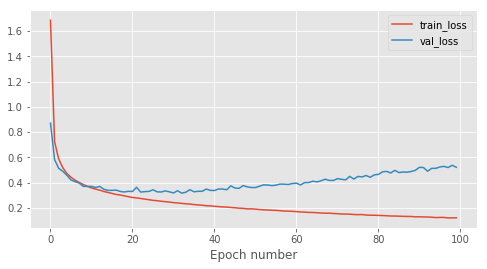

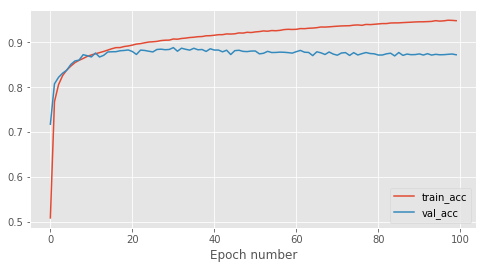

In [8]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [3,3,3,3]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [1,2,3,4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("avgpooling_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f2969cdc828>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29ae7d46d8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29ae7d42b0>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 14, 14])


loss: 3.8524, accuracy: 0.0100:   0%|          | 2/1000 [00:00<00:33, 30.12it/s]

torch.Size([100, 64, 14, 14])
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 2, 2])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_strided_conv_

loss: 0.4082, accuracy: 0.8400:   1%|          | 7/1000 [00:00<00:24, 40.90it/s]

Epoch 0: train_acc_0.7320_train_loss_0.8763_val_acc_0.8444_val_loss_0.4702 epoch time 27.1805 seconds
total time0.0 : 27.180521249771118


loss: 0.3368, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.88it/s]

Epoch 1: train_acc_0.8498_train_loss_0.4278_val_acc_0.8630_val_loss_0.3964 epoch time 27.4408 seconds
total time0.0 : 54.62132549285889


loss: 0.2026, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.08it/s]

Epoch 2: train_acc_0.8671_train_loss_0.3673_val_acc_0.8700_val_loss_0.3707 epoch time 27.1989 seconds
total time1.0 : 21.820252180099487


loss: 0.2333, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:24, 39.80it/s]

Epoch 3: train_acc_0.8773_train_loss_0.3315_val_acc_0.8699_val_loss_0.3647 epoch time 27.2850 seconds
total time1.0 : 49.105268239974976


loss: 0.1900, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.80it/s]

Epoch 4: train_acc_0.8846_train_loss_0.3097_val_acc_0.8783_val_loss_0.3462 epoch time 26.6400 seconds
total time2.0 : 15.745293617248535


loss: 0.2511, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:24, 40.90it/s]

Epoch 5: train_acc_0.8903_train_loss_0.2883_val_acc_0.8799_val_loss_0.3364 epoch time 27.2104 seconds
total time2.0 : 42.95572519302368


loss: 0.1258, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.55it/s]

Epoch 6: train_acc_0.8954_train_loss_0.2707_val_acc_0.8838_val_loss_0.3350 epoch time 27.0797 seconds
total time3.0 : 10.035381555557251


loss: 0.2059, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:23, 41.68it/s]

Epoch 7: train_acc_0.9007_train_loss_0.2546_val_acc_0.8822_val_loss_0.3390 epoch time 27.2772 seconds
total time3.0 : 37.31257343292236


loss: 0.2593, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 38.68it/s]

Epoch 8: train_acc_0.9047_train_loss_0.2414_val_acc_0.8802_val_loss_0.3512 epoch time 27.2132 seconds
total time4.0 : 4.525737285614014


loss: 0.2496, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.71it/s]

Epoch 9: train_acc_0.9080_train_loss_0.2293_val_acc_0.8803_val_loss_0.3632 epoch time 27.0581 seconds
total time4.0 : 31.58382296562195


loss: 0.1332, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.02it/s]

Epoch 10: train_acc_0.9118_train_loss_0.2175_val_acc_0.8791_val_loss_0.3854 epoch time 27.0744 seconds
total time4.0 : 58.6582453250885


loss: 0.1922, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 40.36it/s]

Epoch 11: train_acc_0.9144_train_loss_0.2081_val_acc_0.8763_val_loss_0.3692 epoch time 27.0902 seconds
total time5.0 : 25.748481273651123


loss: 0.1348, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:25, 39.54it/s]

Epoch 12: train_acc_0.9182_train_loss_0.1989_val_acc_0.8806_val_loss_0.3748 epoch time 27.1088 seconds
total time5.0 : 52.85731315612793


loss: 0.1209, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:23, 41.53it/s]

Epoch 13: train_acc_0.9214_train_loss_0.1896_val_acc_0.8828_val_loss_0.3984 epoch time 26.9817 seconds
total time6.0 : 19.83900284767151


loss: 0.1598, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.92it/s]

Epoch 14: train_acc_0.9230_train_loss_0.1850_val_acc_0.8805_val_loss_0.4036 epoch time 26.9619 seconds
total time6.0 : 46.80092430114746


loss: 0.1597, accuracy: 0.9200:   1%|          | 8/1000 [00:00<00:23, 41.85it/s]

Epoch 15: train_acc_0.9270_train_loss_0.1744_val_acc_0.8768_val_loss_0.4142 epoch time 26.8375 seconds
total time7.0 : 13.638463735580444


loss: 0.1243, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 40.74it/s]

Epoch 16: train_acc_0.9285_train_loss_0.1693_val_acc_0.8808_val_loss_0.4189 epoch time 26.9435 seconds
total time7.0 : 40.581955909729004


loss: 0.1406, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 41.33it/s]

Epoch 17: train_acc_0.9309_train_loss_0.1616_val_acc_0.8730_val_loss_0.4529 epoch time 27.0974 seconds
total time8.0 : 7.679320573806763


loss: 0.1503, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 41.31it/s]

Epoch 18: train_acc_0.9340_train_loss_0.1559_val_acc_0.8748_val_loss_0.4488 epoch time 27.0814 seconds
total time8.0 : 34.76069188117981


loss: 0.0664, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.16it/s]

Epoch 19: train_acc_0.9375_train_loss_0.1500_val_acc_0.8754_val_loss_0.4592 epoch time 26.9881 seconds
total time9.0 : 1.748790979385376


loss: 0.0578, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.96it/s]

Epoch 20: train_acc_0.9386_train_loss_0.1445_val_acc_0.8704_val_loss_0.4788 epoch time 27.0819 seconds
total time9.0 : 28.830713272094727


loss: 0.0905, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 40.46it/s]

Epoch 21: train_acc_0.9418_train_loss_0.1394_val_acc_0.8732_val_loss_0.5130 epoch time 27.0535 seconds
total time9.0 : 55.88425421714783


loss: 0.1228, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.66it/s]

Epoch 22: train_acc_0.9426_train_loss_0.1362_val_acc_0.8736_val_loss_0.5048 epoch time 27.0626 seconds
total time10.0 : 22.946898460388184


loss: 0.1302, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.79it/s]

Epoch 23: train_acc_0.9438_train_loss_0.1333_val_acc_0.8753_val_loss_0.5221 epoch time 26.9689 seconds
total time10.0 : 49.915815591812134


loss: 0.0992, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 41.31it/s]

Epoch 24: train_acc_0.9462_train_loss_0.1282_val_acc_0.8685_val_loss_0.5177 epoch time 27.1033 seconds
total time11.0 : 17.019161224365234


loss: 0.1406, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:23, 41.94it/s]

Epoch 25: train_acc_0.9476_train_loss_0.1230_val_acc_0.8761_val_loss_0.5137 epoch time 27.0083 seconds
total time11.0 : 44.02748346328735


loss: 0.0874, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 41.08it/s]

Epoch 26: train_acc_0.9487_train_loss_0.1213_val_acc_0.8704_val_loss_0.5339 epoch time 26.9439 seconds
total time12.0 : 10.971407175064087


loss: 0.1736, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.63it/s]

Epoch 27: train_acc_0.9491_train_loss_0.1191_val_acc_0.8734_val_loss_0.5608 epoch time 26.9274 seconds
total time12.0 : 37.89885449409485


loss: 0.0838, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:23, 41.54it/s]

Epoch 28: train_acc_0.9507_train_loss_0.1163_val_acc_0.8716_val_loss_0.5384 epoch time 27.0030 seconds
total time13.0 : 4.901809453964233


loss: 0.0729, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 41.25it/s]

Epoch 29: train_acc_0.9516_train_loss_0.1135_val_acc_0.8678_val_loss_0.5949 epoch time 27.1439 seconds
total time13.0 : 32.045750856399536


loss: 0.0775, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.31it/s]

Epoch 30: train_acc_0.9539_train_loss_0.1108_val_acc_0.8720_val_loss_0.5705 epoch time 27.5016 seconds
total time13.0 : 59.54733204841614


loss: 0.1157, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:25, 39.61it/s]

Epoch 31: train_acc_0.9560_train_loss_0.1061_val_acc_0.8738_val_loss_0.6094 epoch time 27.3819 seconds
total time14.0 : 26.929230451583862


loss: 0.0901, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:25, 38.63it/s]

Epoch 32: train_acc_0.9558_train_loss_0.1065_val_acc_0.8704_val_loss_0.6159 epoch time 27.8697 seconds
total time14.0 : 54.79894232749939


loss: 0.0832, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.98it/s]

Epoch 33: train_acc_0.9568_train_loss_0.1048_val_acc_0.8699_val_loss_0.6187 epoch time 27.0347 seconds
total time15.0 : 21.83361530303955


loss: 0.1109, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:24, 40.45it/s]

Epoch 34: train_acc_0.9593_train_loss_0.0981_val_acc_0.8724_val_loss_0.6616 epoch time 27.1424 seconds
total time15.0 : 48.976038694381714


loss: 0.0395, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.03it/s]

Epoch 35: train_acc_0.9590_train_loss_0.0987_val_acc_0.8712_val_loss_0.6729 epoch time 27.1885 seconds
total time16.0 : 16.164580821990967


loss: 0.0765, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 39.87it/s]

Epoch 36: train_acc_0.9597_train_loss_0.0981_val_acc_0.8669_val_loss_0.6600 epoch time 27.2391 seconds
total time16.0 : 43.40363597869873


loss: 0.0418, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 39.76it/s]

Epoch 37: train_acc_0.9611_train_loss_0.0939_val_acc_0.8711_val_loss_0.6842 epoch time 27.2568 seconds
total time17.0 : 10.660404205322266


loss: 0.1340, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:23, 41.57it/s]

Epoch 38: train_acc_0.9622_train_loss_0.0929_val_acc_0.8705_val_loss_0.6691 epoch time 26.7809 seconds
total time17.0 : 37.441282510757446


loss: 0.0522, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.63it/s]

Epoch 39: train_acc_0.9623_train_loss_0.0919_val_acc_0.8688_val_loss_0.7035 epoch time 27.0154 seconds
total time18.0 : 4.456695556640625


loss: 0.1193, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:23, 41.49it/s]

Epoch 40: train_acc_0.9628_train_loss_0.0887_val_acc_0.8649_val_loss_0.6848 epoch time 27.0218 seconds
total time18.0 : 31.478532314300537


loss: 0.0590, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 40.56it/s]

Epoch 41: train_acc_0.9629_train_loss_0.0910_val_acc_0.8708_val_loss_0.7018 epoch time 27.1906 seconds
total time18.0 : 58.66915845870972


loss: 0.1228, accuracy: 0.9600:   1%|          | 6/1000 [00:00<00:28, 35.46it/s]

Epoch 42: train_acc_0.9659_train_loss_0.0830_val_acc_0.8694_val_loss_0.7663 epoch time 30.4373 seconds
total time19.0 : 29.106436252593994


loss: 0.1266, accuracy: 0.9200:   0%|          | 5/1000 [00:00<00:34, 28.80it/s]

Epoch 43: train_acc_0.9638_train_loss_0.0905_val_acc_0.8724_val_loss_0.6692 epoch time 33.0017 seconds
total time20.0 : 2.1081252098083496


loss: 0.0308, accuracy: 0.9800:   0%|          | 5/1000 [00:00<00:34, 28.84it/s]

Epoch 44: train_acc_0.9662_train_loss_0.0836_val_acc_0.8673_val_loss_0.7748 epoch time 33.2160 seconds
total time20.0 : 35.3241183757782


loss: 0.0746, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.47it/s]

Epoch 45: train_acc_0.9672_train_loss_0.0804_val_acc_0.8654_val_loss_0.8086 epoch time 30.4626 seconds
total time21.0 : 5.786705255508423


loss: 0.0361, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.81it/s]

Epoch 46: train_acc_0.9682_train_loss_0.0778_val_acc_0.8656_val_loss_0.7713 epoch time 28.1236 seconds
total time21.0 : 33.91034913063049


loss: 0.0615, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 40.87it/s]

Epoch 47: train_acc_0.9670_train_loss_0.0822_val_acc_0.8672_val_loss_0.7331 epoch time 26.9717 seconds
total time22.0 : 0.8820128440856934


loss: 0.0834, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.48it/s]

Epoch 48: train_acc_0.9682_train_loss_0.0785_val_acc_0.8641_val_loss_0.6919 epoch time 27.0071 seconds
total time22.0 : 27.88915514945984


loss: 0.0491, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.74it/s]

Epoch 49: train_acc_0.9681_train_loss_0.0783_val_acc_0.8703_val_loss_0.7841 epoch time 26.6229 seconds
total time22.0 : 54.512091398239136


loss: 0.1318, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 41.13it/s]

Epoch 50: train_acc_0.9698_train_loss_0.0744_val_acc_0.8649_val_loss_0.8182 epoch time 27.2031 seconds
total time23.0 : 21.715214729309082


loss: 0.0893, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.08it/s]

Epoch 51: train_acc_0.9692_train_loss_0.0771_val_acc_0.8666_val_loss_0.7411 epoch time 27.0570 seconds
total time23.0 : 48.77221941947937


loss: 0.0496, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:25, 39.12it/s]

Epoch 52: train_acc_0.9708_train_loss_0.0734_val_acc_0.8684_val_loss_0.8360 epoch time 27.1869 seconds
total time24.0 : 15.959094762802124


loss: 0.0942, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:23, 41.47it/s]

Epoch 53: train_acc_0.9704_train_loss_0.0745_val_acc_0.8653_val_loss_0.8130 epoch time 27.0846 seconds
total time24.0 : 43.04364824295044


loss: 0.0980, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 40.76it/s]

Epoch 54: train_acc_0.9713_train_loss_0.0721_val_acc_0.8665_val_loss_0.8068 epoch time 27.0889 seconds
total time25.0 : 10.132580757141113


loss: 0.0535, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 39.83it/s]

Epoch 55: train_acc_0.9711_train_loss_0.0735_val_acc_0.8651_val_loss_0.7517 epoch time 27.1686 seconds
total time25.0 : 37.301143169403076


loss: 0.0583, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 39.96it/s]

Epoch 56: train_acc_0.9716_train_loss_0.0704_val_acc_0.8661_val_loss_0.8244 epoch time 27.0918 seconds
total time26.0 : 4.392959117889404


loss: 0.0454, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 41.00it/s]

Epoch 57: train_acc_0.9722_train_loss_0.0705_val_acc_0.8680_val_loss_0.8016 epoch time 27.0011 seconds
total time26.0 : 31.394014835357666


loss: 0.0695, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 39.91it/s]

Epoch 58: train_acc_0.9724_train_loss_0.0706_val_acc_0.8666_val_loss_0.8943 epoch time 27.0430 seconds
total time26.0 : 58.43698263168335


loss: 0.0550, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.43it/s]

Epoch 59: train_acc_0.9733_train_loss_0.0676_val_acc_0.8639_val_loss_0.8476 epoch time 27.0913 seconds
total time27.0 : 25.52825927734375


loss: 0.1074, accuracy: 0.9700:   1%|          | 8/1000 [00:00<00:23, 42.25it/s]

Epoch 60: train_acc_0.9735_train_loss_0.0679_val_acc_0.8708_val_loss_0.7468 epoch time 26.7248 seconds
total time27.0 : 52.253108501434326


loss: 0.0860, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:24, 40.73it/s]

Epoch 61: train_acc_0.9745_train_loss_0.0647_val_acc_0.8644_val_loss_0.8977 epoch time 26.8404 seconds
total time28.0 : 19.093554735183716


loss: 0.0342, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 40.50it/s]

Epoch 62: train_acc_0.9748_train_loss_0.0649_val_acc_0.8608_val_loss_0.9009 epoch time 27.1459 seconds
total time28.0 : 46.239421367645264


loss: 0.0356, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.34it/s]

Epoch 63: train_acc_0.9745_train_loss_0.0654_val_acc_0.8645_val_loss_0.8819 epoch time 27.0940 seconds
total time29.0 : 13.333431720733643


loss: 0.0044, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:24, 40.88it/s]

Epoch 64: train_acc_0.9742_train_loss_0.0656_val_acc_0.8630_val_loss_0.8642 epoch time 27.0401 seconds
total time29.0 : 40.373515605926514


loss: 0.0473, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.29it/s]

Epoch 65: train_acc_0.9771_train_loss_0.0607_val_acc_0.8637_val_loss_0.8889 epoch time 27.0758 seconds
total time30.0 : 7.449346542358398


loss: 0.0993, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.33it/s]

Epoch 66: train_acc_0.9766_train_loss_0.0614_val_acc_0.8677_val_loss_0.9257 epoch time 26.9982 seconds
total time30.0 : 34.447529315948486


loss: 0.0571, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 40.52it/s]

Epoch 67: train_acc_0.9765_train_loss_0.0629_val_acc_0.8656_val_loss_0.8726 epoch time 27.1335 seconds
total time31.0 : 1.581064224243164


loss: 0.0534, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 41.01it/s]

Epoch 68: train_acc_0.9763_train_loss_0.0619_val_acc_0.8657_val_loss_0.9475 epoch time 27.0324 seconds
total time31.0 : 28.613446474075317


loss: 0.0615, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 40.26it/s]

Epoch 69: train_acc_0.9766_train_loss_0.0610_val_acc_0.8627_val_loss_0.9776 epoch time 27.1076 seconds
total time31.0 : 55.721028327941895


loss: 0.0443, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.57it/s]

Epoch 70: train_acc_0.9765_train_loss_0.0603_val_acc_0.8665_val_loss_0.9304 epoch time 27.1293 seconds
total time32.0 : 22.850351333618164


loss: 0.0730, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 41.01it/s]

Epoch 71: train_acc_0.9781_train_loss_0.0579_val_acc_0.8667_val_loss_1.0072 epoch time 26.9265 seconds
total time32.0 : 49.77688765525818


loss: 0.0771, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.49it/s]

Epoch 72: train_acc_0.9774_train_loss_0.0588_val_acc_0.8667_val_loss_0.9642 epoch time 26.8505 seconds
total time33.0 : 16.62740683555603


loss: 0.0893, accuracy: 0.9500:   1%|          | 7/1000 [00:00<00:24, 40.98it/s]

Epoch 73: train_acc_0.9769_train_loss_0.0610_val_acc_0.8623_val_loss_0.9793 epoch time 27.1977 seconds
total time33.0 : 43.8250834941864


loss: 0.0315, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:23, 41.55it/s]

Epoch 74: train_acc_0.9784_train_loss_0.0559_val_acc_0.8646_val_loss_0.9918 epoch time 27.2442 seconds
total time34.0 : 11.069319009780884


loss: 0.0516, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:24, 40.39it/s]

Epoch 75: train_acc_0.9797_train_loss_0.0551_val_acc_0.8677_val_loss_1.0173 epoch time 27.1745 seconds
total time34.0 : 38.243775606155396


loss: 0.0427, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.49it/s]

Epoch 76: train_acc_0.9792_train_loss_0.0552_val_acc_0.8622_val_loss_1.0120 epoch time 27.1167 seconds
total time35.0 : 5.360432863235474


loss: 0.0217, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:24, 40.93it/s]

Epoch 77: train_acc_0.9778_train_loss_0.0587_val_acc_0.8625_val_loss_1.0584 epoch time 27.2956 seconds
total time35.0 : 32.65607190132141


loss: 0.0164, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:25, 39.23it/s]

Epoch 78: train_acc_0.9790_train_loss_0.0566_val_acc_0.8647_val_loss_0.9343 epoch time 27.2482 seconds
total time35.0 : 59.90425181388855


loss: 0.0140, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:24, 39.97it/s]

Epoch 79: train_acc_0.9799_train_loss_0.0526_val_acc_0.8653_val_loss_1.0027 epoch time 27.1490 seconds
total time36.0 : 27.053273916244507


loss: 0.0201, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:24, 40.78it/s]

Epoch 80: train_acc_0.9792_train_loss_0.0564_val_acc_0.8641_val_loss_0.9701 epoch time 27.1922 seconds
total time36.0 : 54.245458364486694


loss: 0.0229, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 40.17it/s]

Epoch 81: train_acc_0.9798_train_loss_0.0543_val_acc_0.8624_val_loss_0.9627 epoch time 27.0682 seconds
total time37.0 : 21.31369709968567


loss: 0.0189, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 41.31it/s]

Epoch 82: train_acc_0.9804_train_loss_0.0532_val_acc_0.8644_val_loss_0.9625 epoch time 27.2251 seconds
total time37.0 : 48.538753032684326


loss: 0.0108, accuracy: 1.0000:   1%|          | 8/1000 [00:00<00:23, 41.70it/s]

Epoch 83: train_acc_0.9811_train_loss_0.0520_val_acc_0.8624_val_loss_0.9863 epoch time 26.6884 seconds
total time38.0 : 15.22714114189148


loss: 0.1558, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 40.07it/s]

Epoch 84: train_acc_0.9797_train_loss_0.0548_val_acc_0.8631_val_loss_0.9837 epoch time 27.0745 seconds
total time38.0 : 42.30163264274597


loss: 0.0326, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:23, 41.53it/s]

Epoch 85: train_acc_0.9812_train_loss_0.0498_val_acc_0.8658_val_loss_1.0815 epoch time 27.1648 seconds
total time39.0 : 9.46644139289856


loss: 0.0774, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:24, 40.22it/s]

Epoch 86: train_acc_0.9806_train_loss_0.0520_val_acc_0.8620_val_loss_1.0143 epoch time 27.1561 seconds
total time39.0 : 36.62254571914673


loss: 0.0523, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.84it/s]

Epoch 87: train_acc_0.9808_train_loss_0.0519_val_acc_0.8634_val_loss_0.9138 epoch time 27.2442 seconds
total time40.0 : 3.8666958808898926


loss: 0.0529, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 39.95it/s]

Epoch 88: train_acc_0.9801_train_loss_0.0533_val_acc_0.8618_val_loss_1.0599 epoch time 27.2113 seconds
total time40.0 : 31.07794713973999


loss: 0.0374, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.26it/s]

Epoch 89: train_acc_0.9818_train_loss_0.0488_val_acc_0.8656_val_loss_1.0329 epoch time 27.2305 seconds
total time40.0 : 58.308398485183716


loss: 0.0263, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:25, 39.61it/s]

Epoch 90: train_acc_0.9814_train_loss_0.0505_val_acc_0.8656_val_loss_0.9678 epoch time 27.1702 seconds
total time41.0 : 25.478636980056763


loss: 0.0652, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.62it/s]

Epoch 91: train_acc_0.9827_train_loss_0.0479_val_acc_0.8649_val_loss_0.9852 epoch time 27.2384 seconds
total time41.0 : 52.716991901397705


loss: 0.0042, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:24, 40.74it/s]

Epoch 92: train_acc_0.9813_train_loss_0.0507_val_acc_0.8677_val_loss_1.0889 epoch time 27.2041 seconds
total time42.0 : 19.921082496643066


loss: 0.0141, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:25, 39.46it/s]

Epoch 93: train_acc_0.9827_train_loss_0.0482_val_acc_0.8665_val_loss_1.1093 epoch time 27.2062 seconds
total time42.0 : 47.12727403640747


loss: 0.0920, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.00it/s]

Epoch 94: train_acc_0.9830_train_loss_0.0467_val_acc_0.8634_val_loss_1.0660 epoch time 26.9252 seconds
total time43.0 : 14.052478313446045


loss: 0.0761, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.52it/s]

Epoch 95: train_acc_0.9817_train_loss_0.0505_val_acc_0.8673_val_loss_1.0059 epoch time 26.8534 seconds
total time43.0 : 40.90583896636963


loss: 0.0187, accuracy: 1.0000:   1%|          | 7/1000 [00:00<00:24, 40.88it/s]

Epoch 96: train_acc_0.9826_train_loss_0.0495_val_acc_0.8635_val_loss_1.0481 epoch time 27.2779 seconds
total time44.0 : 8.183741331100464


loss: 0.0274, accuracy: 0.9900:   1%|          | 7/1000 [00:00<00:24, 40.95it/s]

Epoch 97: train_acc_0.9844_train_loss_0.0445_val_acc_0.8660_val_loss_1.0518 epoch time 27.0460 seconds
total time44.0 : 35.22969698905945


loss: 0.1438, accuracy: 0.9800:   1%|          | 7/1000 [00:00<00:24, 40.74it/s]

Epoch 98: train_acc_0.9833_train_loss_0.0468_val_acc_0.8611_val_loss_1.0500 epoch time 27.0635 seconds
total time45.0 : 2.2932140827178955


loss: 0.1705, accuracy: 0.9500:  12%|█▏        | 19/158 [00:00<00:01, 105.46it/s]

Epoch 99: train_acc_0.9829_train_loss_0.0468_val_acc_0.8620_val_loss_1.1190 epoch time 27.2635 seconds
total time45.0 : 29.55669355392456
Generating test set evaluation metrics


loss: 0.4954, accuracy: 0.8300: 100%|██████████| 158/158 [00:01<00:00, 91.39it/s]


finish


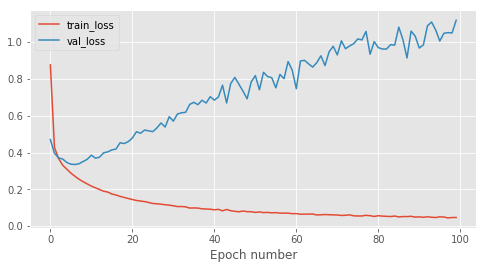

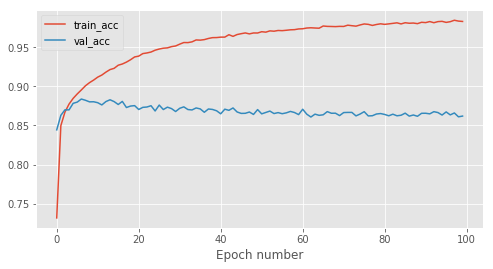

In [7]:
#stride
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [0]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("stride_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29683077f0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29687737b8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f29687a9da0>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])


loss: 3.8331, accuracy: 0.0100:   0%|          | 5/1000 [00:00<00:28, 34.84it/s]

torch.Size([100, 64, 26, 26])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.8817, accuracy: 0.7400:   1%|          | 7/1000 [00:00<00:23, 41.52it/s]

Epoch 0: train_acc_0.5638_train_loss_1.5307_val_acc_0.7084_val_loss_0.9667 epoch time 28.3707 seconds
total time0.0 : 28.370718717575073


loss: 0.7701, accuracy: 0.7500:   1%|          | 7/1000 [00:00<00:25, 39.69it/s]

Epoch 1: train_acc_0.7372_train_loss_0.8581_val_acc_0.7680_val_loss_0.7591 epoch time 28.2174 seconds
total time0.0 : 56.58808088302612


loss: 0.4495, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 38.68it/s]

Epoch 2: train_acc_0.7769_train_loss_0.7153_val_acc_0.8011_val_loss_0.6460 epoch time 28.4608 seconds
total time1.0 : 25.048852920532227


loss: 0.5491, accuracy: 0.8500:   1%|          | 7/1000 [00:00<00:25, 38.72it/s]

Epoch 3: train_acc_0.8023_train_loss_0.6267_val_acc_0.8174_val_loss_0.5762 epoch time 28.3374 seconds
total time1.0 : 53.38628339767456


loss: 0.4350, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:24, 40.39it/s]

Epoch 4: train_acc_0.8183_train_loss_0.5708_val_acc_0.8294_val_loss_0.5320 epoch time 28.4453 seconds
total time2.0 : 21.831581115722656


loss: 0.5283, accuracy: 0.8300:   1%|          | 7/1000 [00:00<00:24, 39.86it/s]

Epoch 5: train_acc_0.8285_train_loss_0.5304_val_acc_0.8306_val_loss_0.5083 epoch time 28.4050 seconds
total time2.0 : 50.236592054367065


loss: 0.3910, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.59it/s]

Epoch 6: train_acc_0.8352_train_loss_0.5020_val_acc_0.8389_val_loss_0.4777 epoch time 28.2196 seconds
total time3.0 : 18.4562246799469


loss: 0.5001, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 39.39it/s]

Epoch 7: train_acc_0.8427_train_loss_0.4790_val_acc_0.8475_val_loss_0.4572 epoch time 28.3223 seconds
total time3.0 : 46.7785370349884


loss: 0.4069, accuracy: 0.8500:   1%|          | 7/1000 [00:00<00:24, 39.96it/s]

Epoch 8: train_acc_0.8478_train_loss_0.4598_val_acc_0.8461_val_loss_0.4491 epoch time 28.3065 seconds
total time4.0 : 15.085065603256226


loss: 0.3934, accuracy: 0.8600:   1%|          | 7/1000 [00:00<00:24, 39.73it/s]

Epoch 9: train_acc_0.8515_train_loss_0.4448_val_acc_0.8489_val_loss_0.4410 epoch time 28.3642 seconds
total time4.0 : 43.44929218292236


loss: 0.3867, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:25, 39.23it/s]

Epoch 10: train_acc_0.8547_train_loss_0.4315_val_acc_0.8592_val_loss_0.4164 epoch time 28.3284 seconds
total time5.0 : 11.777735233306885


loss: 0.4781, accuracy: 0.8000:   1%|          | 7/1000 [00:00<00:24, 39.92it/s]

Epoch 11: train_acc_0.8585_train_loss_0.4198_val_acc_0.8552_val_loss_0.4279 epoch time 28.2098 seconds
total time5.0 : 39.9875590801239


loss: 0.3204, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:24, 39.76it/s]

Epoch 12: train_acc_0.8610_train_loss_0.4104_val_acc_0.8632_val_loss_0.4051 epoch time 28.1693 seconds
total time6.0 : 8.156864643096924


loss: 0.4402, accuracy: 0.8600:   1%|          | 7/1000 [00:00<00:25, 38.88it/s]

Epoch 13: train_acc_0.8640_train_loss_0.4018_val_acc_0.8673_val_loss_0.3935 epoch time 28.3180 seconds
total time6.0 : 36.47486686706543


loss: 0.4024, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 39.43it/s]

Epoch 14: train_acc_0.8659_train_loss_0.3942_val_acc_0.8675_val_loss_0.3875 epoch time 28.2813 seconds
total time7.0 : 4.756152868270874


loss: 0.2903, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:25, 39.06it/s]

Epoch 15: train_acc_0.8680_train_loss_0.3865_val_acc_0.8678_val_loss_0.3869 epoch time 28.3307 seconds
total time7.0 : 33.08682990074158


loss: 0.3181, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 41.07it/s]

Epoch 16: train_acc_0.8693_train_loss_0.3810_val_acc_0.8675_val_loss_0.3876 epoch time 28.3112 seconds
total time8.0 : 1.3980193138122559


loss: 0.3919, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 39.34it/s]

Epoch 17: train_acc_0.8711_train_loss_0.3744_val_acc_0.8730_val_loss_0.3683 epoch time 28.1795 seconds
total time8.0 : 29.577542543411255


loss: 0.4634, accuracy: 0.8100:   1%|          | 7/1000 [00:00<00:24, 39.73it/s]

Epoch 18: train_acc_0.8741_train_loss_0.3672_val_acc_0.8716_val_loss_0.3676 epoch time 28.3445 seconds
total time8.0 : 57.92201495170593


loss: 0.2404, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:23, 41.46it/s]

Epoch 19: train_acc_0.8743_train_loss_0.3628_val_acc_0.8688_val_loss_0.3711 epoch time 28.1768 seconds
total time9.0 : 26.09885311126709


loss: 0.3068, accuracy: 0.8600:   1%|          | 7/1000 [00:00<00:24, 39.81it/s]

Epoch 20: train_acc_0.8757_train_loss_0.3581_val_acc_0.8731_val_loss_0.3658 epoch time 28.1975 seconds
total time9.0 : 54.296391010284424


loss: 0.2410, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 39.58it/s]

Epoch 21: train_acc_0.8769_train_loss_0.3535_val_acc_0.8775_val_loss_0.3613 epoch time 28.0856 seconds
total time10.0 : 22.381980419158936


loss: 0.4226, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 39.70it/s]

Epoch 22: train_acc_0.8785_train_loss_0.3492_val_acc_0.8796_val_loss_0.3485 epoch time 27.9866 seconds
total time10.0 : 50.36857485771179


loss: 0.3766, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.76it/s]

Epoch 23: train_acc_0.8783_train_loss_0.3465_val_acc_0.8745_val_loss_0.3603 epoch time 28.0874 seconds
total time11.0 : 18.455981016159058


loss: 0.3258, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:24, 40.54it/s]

Epoch 24: train_acc_0.8807_train_loss_0.3427_val_acc_0.8753_val_loss_0.3604 epoch time 28.1611 seconds
total time11.0 : 46.6171178817749


loss: 0.2849, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:24, 39.99it/s]

Epoch 25: train_acc_0.8816_train_loss_0.3390_val_acc_0.8799_val_loss_0.3498 epoch time 28.2286 seconds
total time12.0 : 14.84574818611145


loss: 0.2307, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:24, 39.92it/s]

Epoch 26: train_acc_0.8820_train_loss_0.3363_val_acc_0.8737_val_loss_0.3551 epoch time 28.2565 seconds
total time12.0 : 43.102256298065186


loss: 0.2738, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.63it/s]

Epoch 27: train_acc_0.8825_train_loss_0.3333_val_acc_0.8741_val_loss_0.3598 epoch time 28.2255 seconds
total time13.0 : 11.327778339385986


loss: 0.2525, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:25, 38.96it/s]

Epoch 28: train_acc_0.8829_train_loss_0.3313_val_acc_0.8791_val_loss_0.3543 epoch time 28.3168 seconds
total time13.0 : 39.64461636543274


loss: 0.4192, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:25, 38.37it/s]

Epoch 29: train_acc_0.8845_train_loss_0.3280_val_acc_0.8815_val_loss_0.3464 epoch time 28.2803 seconds
total time14.0 : 7.924882173538208


loss: 0.3440, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 39.84it/s]

Epoch 30: train_acc_0.8854_train_loss_0.3254_val_acc_0.8795_val_loss_0.3502 epoch time 28.2425 seconds
total time14.0 : 36.167410373687744


loss: 0.2195, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.70it/s]

Epoch 31: train_acc_0.8861_train_loss_0.3232_val_acc_0.8836_val_loss_0.3415 epoch time 28.1606 seconds
total time15.0 : 4.328043460845947


loss: 0.2470, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 38.83it/s]

Epoch 32: train_acc_0.8862_train_loss_0.3212_val_acc_0.8810_val_loss_0.3401 epoch time 28.2199 seconds
total time15.0 : 32.54791760444641


loss: 0.3464, accuracy: 0.8500:   1%|          | 7/1000 [00:00<00:24, 40.52it/s]

Epoch 33: train_acc_0.8869_train_loss_0.3186_val_acc_0.8793_val_loss_0.3433 epoch time 28.0510 seconds
total time16.0 : 0.5989112854003906


loss: 0.2307, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 39.82it/s]

Epoch 34: train_acc_0.8879_train_loss_0.3165_val_acc_0.8829_val_loss_0.3416 epoch time 28.0801 seconds
total time16.0 : 28.67904043197632


loss: 0.2746, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:25, 39.42it/s]

Epoch 35: train_acc_0.8887_train_loss_0.3148_val_acc_0.8834_val_loss_0.3361 epoch time 28.1963 seconds
total time16.0 : 56.87532877922058


loss: 0.2789, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.32it/s]

Epoch 36: train_acc_0.8884_train_loss_0.3130_val_acc_0.8831_val_loss_0.3455 epoch time 28.3198 seconds
total time17.0 : 25.195111751556396


loss: 0.2259, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:25, 39.68it/s]

Epoch 37: train_acc_0.8893_train_loss_0.3116_val_acc_0.8846_val_loss_0.3359 epoch time 28.2430 seconds
total time17.0 : 53.438087463378906


loss: 0.2114, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:25, 38.95it/s]

Epoch 38: train_acc_0.8892_train_loss_0.3098_val_acc_0.8842_val_loss_0.3297 epoch time 28.1353 seconds
total time18.0 : 21.57339835166931


loss: 0.3571, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 39.79it/s]

Epoch 39: train_acc_0.8904_train_loss_0.3081_val_acc_0.8826_val_loss_0.3344 epoch time 28.1801 seconds
total time18.0 : 49.753502368927


loss: 0.3402, accuracy: 0.8400:   1%|          | 7/1000 [00:00<00:24, 40.09it/s]

Epoch 40: train_acc_0.8905_train_loss_0.3069_val_acc_0.8820_val_loss_0.3350 epoch time 28.2920 seconds
total time19.0 : 18.045464754104614


loss: 0.2857, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 38.89it/s]

Epoch 41: train_acc_0.8908_train_loss_0.3040_val_acc_0.8839_val_loss_0.3346 epoch time 28.1554 seconds
total time19.0 : 46.20084357261658


loss: 0.2768, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 39.74it/s]

Epoch 42: train_acc_0.8911_train_loss_0.3039_val_acc_0.8853_val_loss_0.3316 epoch time 28.3365 seconds
total time20.0 : 14.537322521209717


loss: 0.2504, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 39.45it/s]

Epoch 43: train_acc_0.8915_train_loss_0.3023_val_acc_0.8857_val_loss_0.3347 epoch time 28.2752 seconds
total time20.0 : 42.812490463256836


loss: 0.2147, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:23, 41.52it/s]

Epoch 44: train_acc_0.8929_train_loss_0.3004_val_acc_0.8872_val_loss_0.3310 epoch time 28.1251 seconds
total time21.0 : 10.937551736831665


loss: 0.2612, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:24, 40.78it/s]

Epoch 45: train_acc_0.8930_train_loss_0.2994_val_acc_0.8846_val_loss_0.3303 epoch time 27.9809 seconds
total time21.0 : 38.918450593948364


loss: 0.2668, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 39.57it/s]

Epoch 46: train_acc_0.8925_train_loss_0.2992_val_acc_0.8862_val_loss_0.3289 epoch time 28.2436 seconds
total time22.0 : 7.162092685699463


loss: 0.3500, accuracy: 0.8300:   1%|          | 7/1000 [00:00<00:25, 39.49it/s]

Epoch 47: train_acc_0.8937_train_loss_0.2972_val_acc_0.8884_val_loss_0.3305 epoch time 28.2205 seconds
total time22.0 : 35.38263010978699


loss: 0.2655, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:26, 38.08it/s]

Epoch 48: train_acc_0.8939_train_loss_0.2959_val_acc_0.8853_val_loss_0.3328 epoch time 28.2640 seconds
total time23.0 : 3.646663188934326


loss: 0.2905, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 39.02it/s]

Epoch 49: train_acc_0.8942_train_loss_0.2951_val_acc_0.8838_val_loss_0.3412 epoch time 28.1004 seconds
total time23.0 : 31.74705719947815


loss: 0.2679, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:24, 40.18it/s]

Epoch 50: train_acc_0.8934_train_loss_0.2949_val_acc_0.8872_val_loss_0.3295 epoch time 28.2311 seconds
total time23.0 : 59.9781596660614


loss: 0.1631, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:25, 39.13it/s]

Epoch 51: train_acc_0.8949_train_loss_0.2926_val_acc_0.8823_val_loss_0.3310 epoch time 28.3976 seconds
total time24.0 : 28.375756978988647


loss: 0.2517, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.06it/s]

Epoch 52: train_acc_0.8943_train_loss_0.2924_val_acc_0.8820_val_loss_0.3381 epoch time 28.3428 seconds
total time24.0 : 56.718599796295166


loss: 0.4077, accuracy: 0.8000:   1%|          | 7/1000 [00:00<00:25, 39.35it/s]

Epoch 53: train_acc_0.8946_train_loss_0.2912_val_acc_0.8807_val_loss_0.3330 epoch time 28.3494 seconds
total time25.0 : 25.06799864768982


loss: 0.2776, accuracy: 0.8500:   1%|          | 7/1000 [00:00<00:25, 39.59it/s]

Epoch 54: train_acc_0.8949_train_loss_0.2903_val_acc_0.8880_val_loss_0.3245 epoch time 28.1047 seconds
total time25.0 : 53.17266249656677


loss: 0.2509, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:23, 41.45it/s]

Epoch 55: train_acc_0.8942_train_loss_0.2900_val_acc_0.8875_val_loss_0.3253 epoch time 27.9684 seconds
total time26.0 : 21.141024112701416


loss: 0.3382, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.52it/s]

Epoch 56: train_acc_0.8958_train_loss_0.2879_val_acc_0.8897_val_loss_0.3232 epoch time 27.9761 seconds
total time26.0 : 49.11707925796509


loss: 0.2669, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:25, 38.84it/s]

Epoch 57: train_acc_0.8953_train_loss_0.2872_val_acc_0.8859_val_loss_0.3285 epoch time 28.1559 seconds
total time27.0 : 17.272953987121582


loss: 0.2573, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.42it/s]

Epoch 58: train_acc_0.8964_train_loss_0.2869_val_acc_0.8841_val_loss_0.3285 epoch time 28.2228 seconds
total time27.0 : 45.49577188491821


loss: 0.2910, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:24, 39.90it/s]

Epoch 59: train_acc_0.8959_train_loss_0.2864_val_acc_0.8880_val_loss_0.3246 epoch time 28.1487 seconds
total time28.0 : 13.644458055496216


loss: 0.1476, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:25, 39.41it/s]

Epoch 60: train_acc_0.8965_train_loss_0.2851_val_acc_0.8888_val_loss_0.3263 epoch time 28.1896 seconds
total time28.0 : 41.83408236503601


loss: 0.3655, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:25, 39.29it/s]

Epoch 61: train_acc_0.8969_train_loss_0.2840_val_acc_0.8846_val_loss_0.3304 epoch time 28.2355 seconds
total time29.0 : 10.069628477096558


loss: 0.2549, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 39.63it/s]

Epoch 62: train_acc_0.8976_train_loss_0.2836_val_acc_0.8861_val_loss_0.3278 epoch time 28.1092 seconds
total time29.0 : 38.17878317832947


loss: 0.2029, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 39.36it/s]

Epoch 63: train_acc_0.8976_train_loss_0.2825_val_acc_0.8834_val_loss_0.3297 epoch time 28.2006 seconds
total time30.0 : 6.37943172454834


loss: 0.1323, accuracy: 0.9700:   1%|          | 7/1000 [00:00<00:25, 38.99it/s]

Epoch 64: train_acc_0.8972_train_loss_0.2833_val_acc_0.8856_val_loss_0.3251 epoch time 28.1555 seconds
total time30.0 : 34.53489804267883


loss: 0.3741, accuracy: 0.8600:   1%|          | 7/1000 [00:00<00:24, 39.97it/s]

Epoch 65: train_acc_0.8976_train_loss_0.2817_val_acc_0.8873_val_loss_0.3245 epoch time 28.1073 seconds
total time31.0 : 2.642230987548828


loss: 0.2497, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:24, 40.32it/s]

Epoch 66: train_acc_0.8981_train_loss_0.2804_val_acc_0.8882_val_loss_0.3228 epoch time 28.0869 seconds
total time31.0 : 30.729145050048828


loss: 0.2460, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:24, 39.89it/s]

Epoch 67: train_acc_0.8975_train_loss_0.2805_val_acc_0.8851_val_loss_0.3305 epoch time 27.9085 seconds
total time31.0 : 58.637629985809326


loss: 0.2080, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.21it/s]

Epoch 68: train_acc_0.8972_train_loss_0.2794_val_acc_0.8858_val_loss_0.3238 epoch time 28.1021 seconds
total time32.0 : 26.73976421356201


loss: 0.2428, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.00it/s]

Epoch 69: train_acc_0.8987_train_loss_0.2792_val_acc_0.8830_val_loss_0.3296 epoch time 28.1841 seconds
total time32.0 : 54.923872232437134


loss: 0.3855, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:24, 39.79it/s]

Epoch 70: train_acc_0.8982_train_loss_0.2787_val_acc_0.8911_val_loss_0.3172 epoch time 28.1520 seconds
total time33.0 : 23.075857639312744


loss: 0.3458, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 40.29it/s]

Epoch 71: train_acc_0.8997_train_loss_0.2774_val_acc_0.8908_val_loss_0.3215 epoch time 27.7786 seconds
total time33.0 : 50.854464054107666


loss: 0.3336, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.37it/s]

Epoch 72: train_acc_0.8990_train_loss_0.2761_val_acc_0.8847_val_loss_0.3337 epoch time 27.9229 seconds
total time34.0 : 18.777334690093994


loss: 0.3470, accuracy: 0.8600:   1%|          | 7/1000 [00:00<00:24, 40.51it/s]

Epoch 73: train_acc_0.8992_train_loss_0.2763_val_acc_0.8839_val_loss_0.3335 epoch time 28.0440 seconds
total time34.0 : 46.82132029533386


loss: 0.3533, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:25, 39.33it/s]

Epoch 74: train_acc_0.8989_train_loss_0.2762_val_acc_0.8908_val_loss_0.3194 epoch time 28.0759 seconds
total time35.0 : 14.897208213806152


loss: 0.3761, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:24, 40.88it/s]

Epoch 75: train_acc_0.8995_train_loss_0.2754_val_acc_0.8882_val_loss_0.3272 epoch time 27.7773 seconds
total time35.0 : 42.674489974975586


loss: 0.2513, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 40.69it/s]

Epoch 76: train_acc_0.8999_train_loss_0.2741_val_acc_0.8889_val_loss_0.3255 epoch time 27.9423 seconds
total time36.0 : 10.61681056022644


loss: 0.1830, accuracy: 0.9200:   1%|          | 7/1000 [00:00<00:24, 40.50it/s]

Epoch 77: train_acc_0.8997_train_loss_0.2741_val_acc_0.8887_val_loss_0.3233 epoch time 28.0233 seconds
total time36.0 : 38.6401424407959


loss: 0.4690, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:24, 39.87it/s]

Epoch 78: train_acc_0.9001_train_loss_0.2733_val_acc_0.8842_val_loss_0.3288 epoch time 27.6810 seconds
total time37.0 : 6.321146488189697


loss: 0.3799, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 39.25it/s]

Epoch 79: train_acc_0.9000_train_loss_0.2736_val_acc_0.8896_val_loss_0.3200 epoch time 27.7654 seconds
total time37.0 : 34.08649802207947


loss: 0.2840, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 39.74it/s]

Epoch 80: train_acc_0.9011_train_loss_0.2723_val_acc_0.8891_val_loss_0.3245 epoch time 28.0253 seconds
total time38.0 : 2.1118147373199463


loss: 0.3169, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.56it/s]

Epoch 81: train_acc_0.9006_train_loss_0.2716_val_acc_0.8878_val_loss_0.3189 epoch time 28.1810 seconds
total time38.0 : 30.292864084243774


loss: 0.2180, accuracy: 0.9400:   1%|          | 7/1000 [00:00<00:24, 39.78it/s]

Epoch 82: train_acc_0.9001_train_loss_0.2714_val_acc_0.8873_val_loss_0.3236 epoch time 27.9521 seconds
total time38.0 : 58.244959354400635


loss: 0.2165, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:25, 39.26it/s]

Epoch 83: train_acc_0.9006_train_loss_0.2709_val_acc_0.8891_val_loss_0.3199 epoch time 28.0553 seconds
total time39.0 : 26.30029797554016


loss: 0.4090, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 38.53it/s]

Epoch 84: train_acc_0.9005_train_loss_0.2706_val_acc_0.8901_val_loss_0.3186 epoch time 28.4597 seconds
total time39.0 : 54.76004219055176


loss: 0.2845, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:25, 39.41it/s]

Epoch 85: train_acc_0.9008_train_loss_0.2694_val_acc_0.8864_val_loss_0.3251 epoch time 28.5560 seconds
total time40.0 : 23.315999031066895


loss: 0.2326, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:25, 38.52it/s]

Epoch 86: train_acc_0.9011_train_loss_0.2695_val_acc_0.8869_val_loss_0.3256 epoch time 28.6483 seconds
total time40.0 : 51.964290618896484


loss: 0.2795, accuracy: 0.9000:   1%|          | 7/1000 [00:00<00:25, 38.64it/s]

Epoch 87: train_acc_0.9020_train_loss_0.2682_val_acc_0.8849_val_loss_0.3315 epoch time 28.5481 seconds
total time41.0 : 20.512351512908936


loss: 0.2813, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:24, 40.96it/s]

Epoch 88: train_acc_0.9017_train_loss_0.2684_val_acc_0.8836_val_loss_0.3287 epoch time 28.4830 seconds
total time41.0 : 48.99531006813049


loss: 0.2401, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 38.60it/s]

Epoch 89: train_acc_0.9010_train_loss_0.2686_val_acc_0.8876_val_loss_0.3230 epoch time 28.3968 seconds
total time42.0 : 17.3921058177948


loss: 0.4621, accuracy: 0.8700:   1%|          | 7/1000 [00:00<00:25, 38.94it/s]

Epoch 90: train_acc_0.9014_train_loss_0.2674_val_acc_0.8861_val_loss_0.3263 epoch time 28.6980 seconds
total time42.0 : 46.09011244773865


loss: 0.1500, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:26, 38.16it/s]

Epoch 91: train_acc_0.9018_train_loss_0.2670_val_acc_0.8894_val_loss_0.3216 epoch time 28.6347 seconds
total time43.0 : 14.7247793674469


loss: 0.2256, accuracy: 0.9300:   1%|          | 7/1000 [00:00<00:24, 40.61it/s]

Epoch 92: train_acc_0.9019_train_loss_0.2665_val_acc_0.8835_val_loss_0.3278 epoch time 28.4685 seconds
total time43.0 : 43.19326567649841


loss: 0.2689, accuracy: 0.9100:   1%|          | 7/1000 [00:00<00:25, 39.11it/s]

Epoch 93: train_acc_0.9026_train_loss_0.2663_val_acc_0.8907_val_loss_0.3250 epoch time 28.5062 seconds
total time44.0 : 11.699503183364868


loss: 0.2959, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:25, 39.26it/s]

Epoch 94: train_acc_0.9021_train_loss_0.2661_val_acc_0.8855_val_loss_0.3262 epoch time 28.5667 seconds
total time44.0 : 40.26617503166199


loss: 0.1596, accuracy: 0.9600:   1%|          | 7/1000 [00:00<00:25, 39.07it/s]

Epoch 95: train_acc_0.9024_train_loss_0.2656_val_acc_0.8846_val_loss_0.3252 epoch time 28.6335 seconds
total time45.0 : 8.899633169174194


loss: 0.2851, accuracy: 0.8900:   1%|          | 7/1000 [00:00<00:25, 39.01it/s]

Epoch 96: train_acc_0.9021_train_loss_0.2642_val_acc_0.8885_val_loss_0.3227 epoch time 28.6789 seconds
total time45.0 : 37.5784912109375


loss: 0.2844, accuracy: 0.8600:   1%|          | 7/1000 [00:00<00:24, 39.82it/s]

Epoch 97: train_acc_0.9015_train_loss_0.2652_val_acc_0.8899_val_loss_0.3198 epoch time 28.5732 seconds
total time46.0 : 6.1516478061676025


loss: 0.2752, accuracy: 0.8800:   1%|          | 7/1000 [00:00<00:25, 39.24it/s]

Epoch 98: train_acc_0.9024_train_loss_0.2645_val_acc_0.8847_val_loss_0.3252 epoch time 28.6476 seconds
total time46.0 : 34.79920983314514


loss: 0.4804, accuracy: 0.8700:  11%|█         | 17/158 [00:00<00:01, 90.79it/s]

Epoch 99: train_acc_0.9029_train_loss_0.2638_val_acc_0.8849_val_loss_0.3261 epoch time 28.5080 seconds
total time47.0 : 3.3072028160095215
Generating test set evaluation metrics


loss: 0.4336, accuracy: 0.8400: 100%|██████████| 158/158 [00:01<00:00, 82.21it/s]


finish


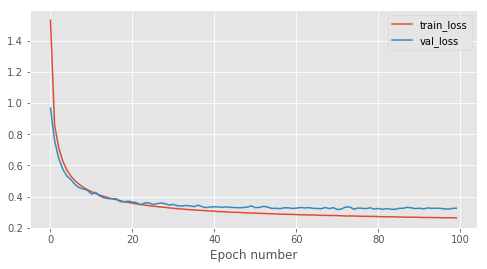

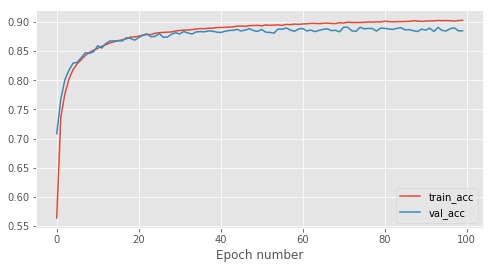

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 26, 26])


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 22, 22])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(3, 3))
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.4723, accuracy: 0.8000:   0%|          | 4/1000 [00:00<00:43, 22.68it/s]

Epoch 0: train_acc_0.6974_train_loss_1.0117_val_acc_0.8156_val_loss_0.5368 epoch time 49.9297 seconds
total time0.0 : 49.92966675758362


loss: 0.5861, accuracy: 0.8200:   0%|          | 4/1000 [00:00<00:42, 23.31it/s]

Epoch 1: train_acc_0.8395_train_loss_0.4806_val_acc_0.8465_val_loss_0.4362 epoch time 50.6493 seconds
total time1.0 : 40.57898473739624


loss: 0.4074, accuracy: 0.8600:   0%|          | 4/1000 [00:00<00:43, 23.02it/s]

Epoch 2: train_acc_0.8586_train_loss_0.4086_val_acc_0.8622_val_loss_0.3961 epoch time 49.8012 seconds
total time2.0 : 30.380201816558838


loss: 0.2581, accuracy: 0.9000:   0%|          | 4/1000 [00:00<00:43, 23.09it/s]

Epoch 3: train_acc_0.8682_train_loss_0.3741_val_acc_0.8701_val_loss_0.3742 epoch time 50.5909 seconds
total time3.0 : 20.97112774848938


loss: 0.3047, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:44, 22.64it/s]

Epoch 4: train_acc_0.8760_train_loss_0.3508_val_acc_0.8813_val_loss_0.3369 epoch time 49.7988 seconds
total time4.0 : 10.769911050796509


loss: 0.2886, accuracy: 0.8900:   0%|          | 4/1000 [00:00<00:42, 23.18it/s]

Epoch 5: train_acc_0.8805_train_loss_0.3356_val_acc_0.8818_val_loss_0.3322 epoch time 50.5223 seconds
total time5.0 : 1.2922465801239014


loss: 0.2591, accuracy: 0.9000:   0%|          | 4/1000 [00:00<00:43, 22.80it/s]

Epoch 6: train_acc_0.8837_train_loss_0.3232_val_acc_0.8827_val_loss_0.3319 epoch time 49.5777 seconds
total time5.0 : 50.86995792388916


loss: 0.4125, accuracy: 0.8300:   0%|          | 4/1000 [00:00<00:43, 22.88it/s]

Epoch 7: train_acc_0.8864_train_loss_0.3141_val_acc_0.8816_val_loss_0.3312 epoch time 50.2507 seconds
total time6.0 : 41.12066578865051


loss: 0.2819, accuracy: 0.8800:   0%|          | 4/1000 [00:00<00:43, 22.95it/s]

Epoch 8: train_acc_0.8903_train_loss_0.3036_val_acc_0.8889_val_loss_0.3148 epoch time 49.5917 seconds
total time7.0 : 30.71235942840576


loss: 0.2793, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:43, 22.81it/s]

Epoch 9: train_acc_0.8910_train_loss_0.2966_val_acc_0.8801_val_loss_0.3420 epoch time 50.2797 seconds
total time8.0 : 20.992036819458008


loss: 0.3229, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:44, 22.59it/s]

Epoch 10: train_acc_0.8936_train_loss_0.2896_val_acc_0.8920_val_loss_0.3134 epoch time 49.4550 seconds
total time9.0 : 10.447006702423096


loss: 0.1881, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:42, 23.22it/s]

Epoch 11: train_acc_0.8957_train_loss_0.2839_val_acc_0.8918_val_loss_0.3170 epoch time 50.2493 seconds
total time10.0 : 0.6963057518005371


loss: 0.2931, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:44, 22.63it/s]

Epoch 12: train_acc_0.8973_train_loss_0.2779_val_acc_0.8861_val_loss_0.3158 epoch time 49.4631 seconds
total time10.0 : 50.159361600875854


loss: 0.2140, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:42, 23.52it/s]

Epoch 13: train_acc_0.8995_train_loss_0.2722_val_acc_0.8866_val_loss_0.3100 epoch time 50.0653 seconds
total time11.0 : 40.224663496017456


loss: 0.2068, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:43, 22.86it/s]

Epoch 14: train_acc_0.9009_train_loss_0.2677_val_acc_0.8922_val_loss_0.3078 epoch time 49.6166 seconds
total time12.0 : 29.841219663619995


loss: 0.3029, accuracy: 0.8600:   0%|          | 4/1000 [00:00<00:42, 23.68it/s]

Epoch 15: train_acc_0.9014_train_loss_0.2628_val_acc_0.8930_val_loss_0.3056 epoch time 50.2981 seconds
total time13.0 : 20.139331102371216


loss: 0.2383, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:44, 22.52it/s]

Epoch 16: train_acc_0.9026_train_loss_0.2593_val_acc_0.8907_val_loss_0.3062 epoch time 49.6382 seconds
total time14.0 : 9.777533769607544


loss: 0.2243, accuracy: 0.8700:   0%|          | 4/1000 [00:00<00:43, 22.95it/s]

Epoch 17: train_acc_0.9048_train_loss_0.2541_val_acc_0.8854_val_loss_0.3193 epoch time 50.3740 seconds
total time15.0 : 0.15152692794799805


loss: 0.2333, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:44, 22.41it/s]

Epoch 18: train_acc_0.9042_train_loss_0.2518_val_acc_0.8925_val_loss_0.3071 epoch time 49.2187 seconds
total time15.0 : 49.37022256851196


loss: 0.2437, accuracy: 0.9000:   0%|          | 4/1000 [00:00<00:43, 23.05it/s]

Epoch 19: train_acc_0.9069_train_loss_0.2465_val_acc_0.8921_val_loss_0.3085 epoch time 49.9566 seconds
total time16.0 : 39.32684683799744


loss: 0.1528, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 22.85it/s]

Epoch 20: train_acc_0.9073_train_loss_0.2438_val_acc_0.8917_val_loss_0.3103 epoch time 49.2833 seconds
total time17.0 : 28.610147714614868


loss: 0.1937, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:42, 23.24it/s]

Epoch 21: train_acc_0.9092_train_loss_0.2394_val_acc_0.8888_val_loss_0.3144 epoch time 50.1012 seconds
total time18.0 : 18.711298942565918


loss: 0.1788, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 22.68it/s]

Epoch 22: train_acc_0.9094_train_loss_0.2368_val_acc_0.8918_val_loss_0.3086 epoch time 49.4010 seconds
total time19.0 : 8.112330913543701


loss: 0.1793, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 23.03it/s]

Epoch 23: train_acc_0.9101_train_loss_0.2338_val_acc_0.8878_val_loss_0.3194 epoch time 49.9647 seconds
total time19.0 : 58.07706260681152


loss: 0.3297, accuracy: 0.8700:   0%|          | 4/1000 [00:00<00:44, 22.42it/s]

Epoch 24: train_acc_0.9108_train_loss_0.2311_val_acc_0.8906_val_loss_0.3200 epoch time 49.2607 seconds
total time20.0 : 47.33778929710388


loss: 0.2652, accuracy: 0.9000:   0%|          | 4/1000 [00:00<00:43, 22.70it/s]

Epoch 25: train_acc_0.9117_train_loss_0.2270_val_acc_0.8934_val_loss_0.3155 epoch time 49.8748 seconds
total time21.0 : 37.21263122558594


loss: 0.2405, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:44, 22.63it/s]

Epoch 26: train_acc_0.9140_train_loss_0.2234_val_acc_0.8945_val_loss_0.3158 epoch time 49.1495 seconds
total time22.0 : 26.362122774124146


loss: 0.2325, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:42, 23.40it/s]

Epoch 27: train_acc_0.9140_train_loss_0.2212_val_acc_0.8906_val_loss_0.3270 epoch time 49.8576 seconds
total time23.0 : 16.219699144363403


loss: 0.1233, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:44, 22.43it/s]

Epoch 28: train_acc_0.9157_train_loss_0.2183_val_acc_0.8922_val_loss_0.3183 epoch time 49.1235 seconds
total time24.0 : 5.343230724334717


loss: 0.1382, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:42, 23.42it/s]

Epoch 29: train_acc_0.9164_train_loss_0.2152_val_acc_0.8930_val_loss_0.3158 epoch time 49.8361 seconds
total time24.0 : 55.179343461990356


loss: 0.2198, accuracy: 0.8900:   0%|          | 4/1000 [00:00<00:43, 23.01it/s]

Epoch 30: train_acc_0.9170_train_loss_0.2119_val_acc_0.8922_val_loss_0.3251 epoch time 49.2165 seconds
total time25.0 : 44.39587998390198


loss: 0.3007, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 22.83it/s]

Epoch 31: train_acc_0.9181_train_loss_0.2096_val_acc_0.8895_val_loss_0.3281 epoch time 49.7654 seconds
total time26.0 : 34.16131258010864


loss: 0.2827, accuracy: 0.8700:   0%|          | 4/1000 [00:00<00:42, 23.29it/s]

Epoch 32: train_acc_0.9192_train_loss_0.2070_val_acc_0.8906_val_loss_0.3194 epoch time 49.2208 seconds
total time27.0 : 23.382132530212402


loss: 0.2339, accuracy: 0.8800:   0%|          | 4/1000 [00:00<00:43, 23.15it/s]

Epoch 33: train_acc_0.9201_train_loss_0.2038_val_acc_0.8870_val_loss_0.3384 epoch time 49.6908 seconds
total time28.0 : 13.072898864746094


loss: 0.2189, accuracy: 0.9000:   0%|          | 4/1000 [00:00<00:43, 22.71it/s]

Epoch 34: train_acc_0.9206_train_loss_0.2009_val_acc_0.8873_val_loss_0.3356 epoch time 49.0885 seconds
total time29.0 : 2.1614420413970947


loss: 0.3233, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:42, 23.59it/s]

Epoch 35: train_acc_0.9206_train_loss_0.1993_val_acc_0.8921_val_loss_0.3373 epoch time 49.6385 seconds
total time29.0 : 51.799915075302124


loss: 0.1262, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 22.67it/s]

Epoch 36: train_acc_0.9218_train_loss_0.1960_val_acc_0.8891_val_loss_0.3400 epoch time 49.0655 seconds
total time30.0 : 40.865445375442505


loss: 0.1709, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:42, 23.46it/s]

Epoch 37: train_acc_0.9234_train_loss_0.1937_val_acc_0.8894_val_loss_0.3360 epoch time 49.5670 seconds
total time31.0 : 30.432396411895752


loss: 0.2055, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:43, 22.81it/s]

Epoch 38: train_acc_0.9239_train_loss_0.1912_val_acc_0.8911_val_loss_0.3409 epoch time 48.9274 seconds
total time32.0 : 19.35979986190796


loss: 0.1471, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:42, 23.24it/s]

Epoch 39: train_acc_0.9250_train_loss_0.1892_val_acc_0.8885_val_loss_0.3519 epoch time 49.5489 seconds
total time33.0 : 8.908703565597534


loss: 0.1222, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:43, 23.00it/s]

Epoch 40: train_acc_0.9256_train_loss_0.1870_val_acc_0.8887_val_loss_0.3565 epoch time 49.0903 seconds
total time33.0 : 57.999037742614746


loss: 0.1877, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:42, 23.41it/s]

Epoch 41: train_acc_0.9273_train_loss_0.1837_val_acc_0.8885_val_loss_0.3510 epoch time 49.5319 seconds
total time34.0 : 47.530927419662476


loss: 0.1318, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 22.75it/s]

Epoch 42: train_acc_0.9276_train_loss_0.1818_val_acc_0.8819_val_loss_0.3728 epoch time 48.9977 seconds
total time35.0 : 36.52863550186157


loss: 0.1238, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:42, 23.30it/s]

Epoch 43: train_acc_0.9280_train_loss_0.1802_val_acc_0.8847_val_loss_0.3582 epoch time 49.5268 seconds
total time36.0 : 26.055411338806152


loss: 0.2165, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 22.91it/s]

Epoch 44: train_acc_0.9289_train_loss_0.1773_val_acc_0.8846_val_loss_0.3635 epoch time 48.9447 seconds
total time37.0 : 15.000138759613037


loss: 0.2171, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 23.11it/s]

Epoch 45: train_acc_0.9303_train_loss_0.1745_val_acc_0.8879_val_loss_0.3743 epoch time 49.6513 seconds
total time38.0 : 4.651439666748047


loss: 0.1468, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:44, 22.41it/s]

Epoch 46: train_acc_0.9307_train_loss_0.1729_val_acc_0.8882_val_loss_0.3618 epoch time 49.1752 seconds
total time38.0 : 53.82662296295166


loss: 0.1154, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:42, 23.25it/s]

Epoch 47: train_acc_0.9322_train_loss_0.1698_val_acc_0.8849_val_loss_0.3806 epoch time 49.9589 seconds
total time39.0 : 43.78555750846863


loss: 0.1036, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:42, 23.25it/s]

Epoch 48: train_acc_0.9324_train_loss_0.1684_val_acc_0.8868_val_loss_0.3733 epoch time 49.2655 seconds
total time40.0 : 33.051048278808594


loss: 0.1022, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:42, 23.60it/s]

Epoch 49: train_acc_0.9336_train_loss_0.1656_val_acc_0.8859_val_loss_0.3838 epoch time 49.6068 seconds
total time41.0 : 22.657890558242798


loss: 0.2487, accuracy: 0.8800:   0%|          | 4/1000 [00:00<00:43, 23.04it/s]

Epoch 50: train_acc_0.9340_train_loss_0.1635_val_acc_0.8838_val_loss_0.3941 epoch time 49.2730 seconds
total time42.0 : 11.93086314201355


loss: 0.2430, accuracy: 0.8900:   0%|          | 4/1000 [00:00<00:42, 23.49it/s]

Epoch 51: train_acc_0.9345_train_loss_0.1616_val_acc_0.8812_val_loss_0.3984 epoch time 49.9198 seconds
total time43.0 : 1.8506553173065186


loss: 0.1242, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 23.07it/s]

Epoch 52: train_acc_0.9350_train_loss_0.1595_val_acc_0.8837_val_loss_0.4157 epoch time 49.0734 seconds
total time43.0 : 50.92402625083923


loss: 0.1218, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 22.66it/s]

Epoch 53: train_acc_0.9362_train_loss_0.1572_val_acc_0.8860_val_loss_0.4035 epoch time 49.7606 seconds
total time44.0 : 40.6846649646759


loss: 0.2045, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:43, 22.75it/s]

Epoch 54: train_acc_0.9371_train_loss_0.1553_val_acc_0.8797_val_loss_0.4170 epoch time 49.1097 seconds
total time45.0 : 29.79439616203308


loss: 0.1488, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:42, 23.69it/s]

Epoch 55: train_acc_0.9373_train_loss_0.1537_val_acc_0.8794_val_loss_0.4203 epoch time 49.7510 seconds
total time46.0 : 19.545356035232544


loss: 0.1066, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:43, 23.10it/s]

Epoch 56: train_acc_0.9383_train_loss_0.1518_val_acc_0.8824_val_loss_0.4140 epoch time 48.7842 seconds
total time47.0 : 8.329525232315063


loss: 0.1277, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:42, 23.28it/s]

Epoch 57: train_acc_0.9402_train_loss_0.1484_val_acc_0.8830_val_loss_0.4279 epoch time 49.7424 seconds
total time47.0 : 58.07195711135864


loss: 0.1410, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:43, 22.74it/s]

Epoch 58: train_acc_0.9400_train_loss_0.1467_val_acc_0.8811_val_loss_0.4249 epoch time 49.1361 seconds
total time48.0 : 47.208038091659546


loss: 0.0960, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:42, 23.32it/s]

Epoch 59: train_acc_0.9413_train_loss_0.1445_val_acc_0.8817_val_loss_0.4310 epoch time 49.6496 seconds
total time49.0 : 36.85761642456055


loss: 0.1247, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 23.08it/s]

Epoch 60: train_acc_0.9424_train_loss_0.1432_val_acc_0.8769_val_loss_0.4516 epoch time 48.9810 seconds
total time50.0 : 25.838614225387573


loss: 0.1476, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 22.88it/s]

Epoch 61: train_acc_0.9427_train_loss_0.1416_val_acc_0.8780_val_loss_0.4502 epoch time 49.6336 seconds
total time51.0 : 15.472201824188232


loss: 0.0762, accuracy: 0.9800:   0%|          | 4/1000 [00:00<00:44, 22.38it/s]

Epoch 62: train_acc_0.9419_train_loss_0.1407_val_acc_0.8779_val_loss_0.4473 epoch time 49.0785 seconds
total time52.0 : 4.550705432891846


loss: 0.0920, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:42, 23.42it/s]

Epoch 63: train_acc_0.9441_train_loss_0.1374_val_acc_0.8790_val_loss_0.4585 epoch time 49.7433 seconds
total time52.0 : 54.29403376579285


loss: 0.1596, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:44, 22.37it/s]

Epoch 64: train_acc_0.9448_train_loss_0.1351_val_acc_0.8748_val_loss_0.4793 epoch time 49.1499 seconds
total time53.0 : 43.44390892982483


loss: 0.0739, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:42, 23.44it/s]

Epoch 65: train_acc_0.9451_train_loss_0.1340_val_acc_0.8744_val_loss_0.4625 epoch time 49.7354 seconds
total time54.0 : 33.17932653427124


loss: 0.1289, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 22.98it/s]

Epoch 66: train_acc_0.9461_train_loss_0.1321_val_acc_0.8792_val_loss_0.4639 epoch time 49.0117 seconds
total time55.0 : 22.191033124923706


loss: 0.0990, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:42, 23.25it/s]

Epoch 67: train_acc_0.9470_train_loss_0.1305_val_acc_0.8792_val_loss_0.4840 epoch time 49.5919 seconds
total time56.0 : 11.78297758102417


loss: 0.2054, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:43, 23.00it/s]

Epoch 68: train_acc_0.9480_train_loss_0.1286_val_acc_0.8775_val_loss_0.5062 epoch time 48.8482 seconds
total time57.0 : 0.6312274932861328


loss: 0.1303, accuracy: 0.9200:   0%|          | 4/1000 [00:00<00:42, 23.64it/s]

Epoch 69: train_acc_0.9480_train_loss_0.1274_val_acc_0.8744_val_loss_0.4944 epoch time 49.6067 seconds
total time57.0 : 50.23789095878601


loss: 0.1238, accuracy: 0.9300:   0%|          | 4/1000 [00:00<00:43, 23.02it/s]

Epoch 70: train_acc_0.9483_train_loss_0.1261_val_acc_0.8761_val_loss_0.4975 epoch time 48.9103 seconds
total time58.0 : 39.148197412490845


loss: 0.1366, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:41, 23.81it/s]

Epoch 71: train_acc_0.9498_train_loss_0.1225_val_acc_0.8754_val_loss_0.5084 epoch time 49.6296 seconds
total time59.0 : 28.777749061584473


loss: 0.0936, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:44, 22.28it/s]

Epoch 72: train_acc_0.9498_train_loss_0.1225_val_acc_0.8742_val_loss_0.4954 epoch time 48.9133 seconds
total time60.0 : 17.69108247756958


loss: 0.1459, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:42, 23.27it/s]

Epoch 73: train_acc_0.9508_train_loss_0.1211_val_acc_0.8775_val_loss_0.5115 epoch time 49.6598 seconds
total time61.0 : 7.350919961929321


loss: 0.1039, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:43, 22.81it/s]

Epoch 74: train_acc_0.9511_train_loss_0.1185_val_acc_0.8715_val_loss_0.5275 epoch time 49.1980 seconds
total time61.0 : 56.54887843132019


loss: 0.1039, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:43, 23.07it/s]

Epoch 75: train_acc_0.9522_train_loss_0.1175_val_acc_0.8777_val_loss_0.5305 epoch time 49.7808 seconds
total time62.0 : 46.32968854904175


loss: 0.1059, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:43, 23.05it/s]

Epoch 76: train_acc_0.9524_train_loss_0.1166_val_acc_0.8748_val_loss_0.5372 epoch time 49.1122 seconds
total time63.0 : 35.44188165664673


loss: 0.1078, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:43, 22.98it/s]

Epoch 77: train_acc_0.9534_train_loss_0.1149_val_acc_0.8729_val_loss_0.5402 epoch time 49.6190 seconds
total time64.0 : 25.06083393096924


loss: 0.0934, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:43, 23.05it/s]

Epoch 78: train_acc_0.9546_train_loss_0.1120_val_acc_0.8770_val_loss_0.5464 epoch time 48.8851 seconds
total time65.0 : 13.945923089981079


loss: 0.0544, accuracy: 0.9900:   0%|          | 4/1000 [00:00<00:41, 24.00it/s]

Epoch 79: train_acc_0.9541_train_loss_0.1114_val_acc_0.8739_val_loss_0.5417 epoch time 49.6082 seconds
total time66.0 : 3.5541722774505615


loss: 0.0842, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:42, 23.20it/s]

Epoch 80: train_acc_0.9553_train_loss_0.1097_val_acc_0.8712_val_loss_0.5691 epoch time 48.8350 seconds
total time66.0 : 52.389209032058716


loss: 0.0755, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:42, 23.68it/s]

Epoch 81: train_acc_0.9555_train_loss_0.1088_val_acc_0.8745_val_loss_0.5589 epoch time 49.4501 seconds
total time67.0 : 41.839279890060425


loss: 0.0483, accuracy: 0.9800:   0%|          | 4/1000 [00:00<00:43, 22.87it/s]

Epoch 82: train_acc_0.9568_train_loss_0.1060_val_acc_0.8755_val_loss_0.5748 epoch time 48.8789 seconds
total time68.0 : 30.718149185180664


loss: 0.1351, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:42, 23.44it/s]

Epoch 83: train_acc_0.9564_train_loss_0.1071_val_acc_0.8720_val_loss_0.5789 epoch time 49.4617 seconds
total time69.0 : 20.17983841896057


loss: 0.0656, accuracy: 0.9800:   0%|          | 4/1000 [00:00<00:43, 22.65it/s]

Epoch 84: train_acc_0.9569_train_loss_0.1053_val_acc_0.8744_val_loss_0.5781 epoch time 48.8594 seconds
total time70.0 : 9.039207935333252


loss: 0.2102, accuracy: 0.9400:   0%|          | 4/1000 [00:00<00:42, 23.30it/s]

Epoch 85: train_acc_0.9579_train_loss_0.1034_val_acc_0.8749_val_loss_0.5771 epoch time 49.4973 seconds
total time70.0 : 58.536508560180664


loss: 0.1186, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:43, 22.75it/s]

Epoch 86: train_acc_0.9578_train_loss_0.1030_val_acc_0.8693_val_loss_0.5932 epoch time 48.8242 seconds
total time71.0 : 47.36069989204407


loss: 0.0351, accuracy: 0.9900:   0%|          | 4/1000 [00:00<00:42, 23.42it/s]

Epoch 87: train_acc_0.9586_train_loss_0.1005_val_acc_0.8705_val_loss_0.5994 epoch time 49.3770 seconds
total time72.0 : 36.73773169517517


loss: 0.0721, accuracy: 0.9800:   0%|          | 4/1000 [00:00<00:43, 22.80it/s]

Epoch 88: train_acc_0.9597_train_loss_0.0990_val_acc_0.8691_val_loss_0.5985 epoch time 48.7714 seconds
total time73.0 : 25.509165287017822


loss: 0.0593, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:42, 23.42it/s]

Epoch 89: train_acc_0.9616_train_loss_0.0956_val_acc_0.8708_val_loss_0.6259 epoch time 49.6959 seconds
total time74.0 : 15.205052137374878


loss: 0.0749, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:43, 23.13it/s]

Epoch 90: train_acc_0.9605_train_loss_0.0969_val_acc_0.8686_val_loss_0.6365 epoch time 48.8049 seconds
total time75.0 : 4.009963512420654


loss: 0.0935, accuracy: 0.9600:   0%|          | 4/1000 [00:00<00:43, 22.74it/s]

Epoch 91: train_acc_0.9623_train_loss_0.0945_val_acc_0.8697_val_loss_0.6274 epoch time 49.5933 seconds
total time75.0 : 53.60324788093567


loss: 0.1437, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:43, 22.75it/s]

Epoch 92: train_acc_0.9614_train_loss_0.0949_val_acc_0.8669_val_loss_0.6412 epoch time 48.8152 seconds
total time76.0 : 42.418421030044556


loss: 0.1235, accuracy: 0.9100:   0%|          | 4/1000 [00:00<00:41, 23.89it/s]

Epoch 93: train_acc_0.9621_train_loss_0.0936_val_acc_0.8700_val_loss_0.6503 epoch time 49.3888 seconds
total time77.0 : 31.807229042053223


loss: 0.0675, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:43, 22.67it/s]

Epoch 94: train_acc_0.9625_train_loss_0.0914_val_acc_0.8708_val_loss_0.6613 epoch time 48.8265 seconds
total time78.0 : 20.633748292922974


loss: 0.0633, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:43, 23.15it/s]

Epoch 95: train_acc_0.9628_train_loss_0.0928_val_acc_0.8692_val_loss_0.6485 epoch time 49.5225 seconds
total time79.0 : 10.156256437301636


loss: 0.0779, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:43, 22.73it/s]

Epoch 96: train_acc_0.9644_train_loss_0.0880_val_acc_0.8736_val_loss_0.6603 epoch time 48.9300 seconds
total time79.0 : 59.08626699447632


loss: 0.1009, accuracy: 0.9500:   0%|          | 4/1000 [00:00<00:42, 23.39it/s]

Epoch 97: train_acc_0.9642_train_loss_0.0880_val_acc_0.8689_val_loss_0.6784 epoch time 49.5313 seconds
total time80.0 : 48.61760377883911


loss: 0.0667, accuracy: 0.9700:   0%|          | 4/1000 [00:00<00:43, 23.06it/s]

Epoch 98: train_acc_0.9645_train_loss_0.0871_val_acc_0.8703_val_loss_0.6859 epoch time 49.0664 seconds
total time81.0 : 37.684016942977905


loss: 0.2082, accuracy: 0.8900:   6%|▋         | 10/158 [00:00<00:02, 57.78it/s]

Epoch 99: train_acc_0.9648_train_loss_0.0865_val_acc_0.8706_val_loss_0.6736 epoch time 49.5072 seconds
total time82.0 : 27.191173791885376
Generating test set evaluation metrics


loss: 0.1992, accuracy: 0.9100: 100%|██████████| 158/158 [00:02<00:00, 54.76it/s]


finish


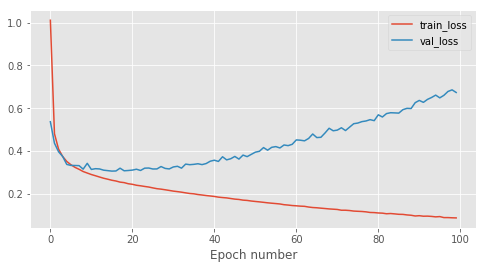

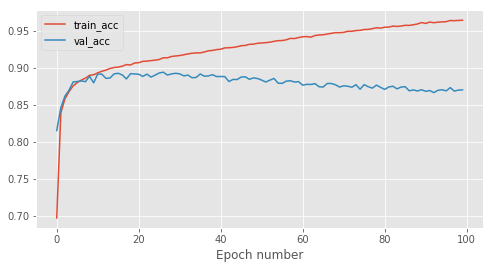

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 22, 22])


loss: 3.8527, accuracy: 0.0100:   0%|          | 1/1000 [00:00<00:54, 18.42it/s]

torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 16, 16])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(3, 3))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(4, 4))
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.4322, accuracy: 0.8800:   0%|          | 3/1000 [00:00<00:56, 17.71it/s]

Epoch 0: train_acc_0.7442_train_loss_0.8336_val_acc_0.8441_val_loss_0.4538 epoch time 64.7426 seconds
total time1.0 : 4.7425689697265625


loss: 0.6185, accuracy: 0.8500:   0%|          | 3/1000 [00:00<00:57, 17.32it/s]

Epoch 1: train_acc_0.8569_train_loss_0.4121_val_acc_0.8640_val_loss_0.3781 epoch time 64.9529 seconds
total time2.0 : 9.695443630218506


loss: 0.4675, accuracy: 0.8500:   0%|          | 3/1000 [00:00<00:57, 17.30it/s]

Epoch 2: train_acc_0.8728_train_loss_0.3583_val_acc_0.8735_val_loss_0.3561 epoch time 64.9389 seconds
total time3.0 : 14.634385108947754


loss: 0.3534, accuracy: 0.8700:   0%|          | 3/1000 [00:00<00:58, 17.05it/s]

Epoch 3: train_acc_0.8815_train_loss_0.3272_val_acc_0.8827_val_loss_0.3292 epoch time 64.8093 seconds
total time4.0 : 19.443655252456665


loss: 0.2306, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:57, 17.45it/s]

Epoch 4: train_acc_0.8856_train_loss_0.3093_val_acc_0.8842_val_loss_0.3174 epoch time 64.6298 seconds
total time5.0 : 24.073421239852905


loss: 0.3562, accuracy: 0.8700:   0%|          | 3/1000 [00:00<00:58, 17.07it/s]

Epoch 5: train_acc_0.8922_train_loss_0.2924_val_acc_0.8853_val_loss_0.3180 epoch time 64.5822 seconds
total time6.0 : 28.655669689178467


loss: 0.3467, accuracy: 0.8900:   0%|          | 3/1000 [00:00<00:57, 17.36it/s]

Epoch 6: train_acc_0.8950_train_loss_0.2804_val_acc_0.8845_val_loss_0.3158 epoch time 64.7632 seconds
total time7.0 : 33.41883111000061


loss: 0.2064, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:56, 17.66it/s]

Epoch 7: train_acc_0.8987_train_loss_0.2692_val_acc_0.8916_val_loss_0.3048 epoch time 64.6554 seconds
total time8.0 : 38.0742301940918


loss: 0.1842, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:56, 17.51it/s]

Epoch 8: train_acc_0.9013_train_loss_0.2593_val_acc_0.8870_val_loss_0.3097 epoch time 64.5641 seconds
total time9.0 : 42.63836646080017


loss: 0.1453, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:54, 18.29it/s]

Epoch 9: train_acc_0.9042_train_loss_0.2491_val_acc_0.8901_val_loss_0.3087 epoch time 64.4674 seconds
total time10.0 : 47.105809450149536


loss: 0.1557, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:58, 17.18it/s]

Epoch 10: train_acc_0.9074_train_loss_0.2405_val_acc_0.8915_val_loss_0.3064 epoch time 64.4461 seconds
total time11.0 : 51.55187177658081


loss: 0.1686, accuracy: 0.9000:   0%|          | 3/1000 [00:00<00:57, 17.33it/s]

Epoch 11: train_acc_0.9101_train_loss_0.2309_val_acc_0.8913_val_loss_0.3147 epoch time 64.6215 seconds
total time12.0 : 56.173378705978394


loss: 0.1499, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:56, 17.74it/s]

Epoch 12: train_acc_0.9129_train_loss_0.2235_val_acc_0.8922_val_loss_0.3036 epoch time 64.4176 seconds
total time14.0 : 0.5909371376037598


loss: 0.1795, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:57, 17.44it/s]

Epoch 13: train_acc_0.9149_train_loss_0.2144_val_acc_0.8891_val_loss_0.3161 epoch time 64.6071 seconds
total time15.0 : 5.198011159896851


loss: 0.1508, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:56, 17.74it/s]

Epoch 14: train_acc_0.9175_train_loss_0.2082_val_acc_0.8919_val_loss_0.3162 epoch time 64.2820 seconds
total time16.0 : 9.480008840560913


loss: 0.2423, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:57, 17.40it/s]

Epoch 15: train_acc_0.9192_train_loss_0.2008_val_acc_0.8877_val_loss_0.3301 epoch time 64.4457 seconds
total time17.0 : 13.925743103027344


loss: 0.1317, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:57, 17.23it/s]

Epoch 16: train_acc_0.9220_train_loss_0.1930_val_acc_0.8875_val_loss_0.3423 epoch time 64.3471 seconds
total time18.0 : 18.272831201553345


loss: 0.1015, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:57, 17.21it/s]

Epoch 17: train_acc_0.9244_train_loss_0.1876_val_acc_0.8862_val_loss_0.3477 epoch time 64.2748 seconds
total time19.0 : 22.547606229782104


loss: 0.1371, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:57, 17.48it/s]

Epoch 18: train_acc_0.9273_train_loss_0.1802_val_acc_0.8878_val_loss_0.3525 epoch time 64.3529 seconds
total time20.0 : 26.900527238845825


loss: 0.1326, accuracy: 0.9300:   0%|          | 3/1000 [00:00<00:56, 17.49it/s]

Epoch 19: train_acc_0.9283_train_loss_0.1748_val_acc_0.8880_val_loss_0.3587 epoch time 64.1764 seconds
total time21.0 : 31.076944828033447


loss: 0.0627, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.52it/s]

Epoch 20: train_acc_0.9312_train_loss_0.1671_val_acc_0.8824_val_loss_0.3815 epoch time 64.2953 seconds
total time22.0 : 35.37221002578735


loss: 0.1947, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:56, 17.72it/s]

Epoch 21: train_acc_0.9333_train_loss_0.1610_val_acc_0.8806_val_loss_0.3798 epoch time 64.3243 seconds
total time23.0 : 39.696518898010254


loss: 0.1674, accuracy: 0.9200:   0%|          | 3/1000 [00:00<00:56, 17.70it/s]

Epoch 22: train_acc_0.9359_train_loss_0.1564_val_acc_0.8837_val_loss_0.3969 epoch time 64.2283 seconds
total time24.0 : 43.924771547317505


loss: 0.1148, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:56, 17.72it/s]

Epoch 23: train_acc_0.9377_train_loss_0.1501_val_acc_0.8847_val_loss_0.4337 epoch time 64.2507 seconds
total time25.0 : 48.175503730773926


loss: 0.1302, accuracy: 0.9100:   0%|          | 3/1000 [00:00<00:57, 17.42it/s]

Epoch 24: train_acc_0.9398_train_loss_0.1465_val_acc_0.8855_val_loss_0.3962 epoch time 64.1009 seconds
total time26.0 : 52.27638077735901


loss: 0.0762, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:56, 17.51it/s]

Epoch 25: train_acc_0.9431_train_loss_0.1398_val_acc_0.8789_val_loss_0.4399 epoch time 64.2837 seconds
total time27.0 : 56.5600860118866


loss: 0.1127, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:57, 17.32it/s]

Epoch 26: train_acc_0.9430_train_loss_0.1365_val_acc_0.8777_val_loss_0.4316 epoch time 64.2486 seconds
total time29.0 : 0.8086631298065186


loss: 0.0525, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.60it/s]

Epoch 27: train_acc_0.9456_train_loss_0.1306_val_acc_0.8789_val_loss_0.4501 epoch time 64.1802 seconds
total time30.0 : 4.98891282081604


loss: 0.1160, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.43it/s]

Epoch 28: train_acc_0.9478_train_loss_0.1254_val_acc_0.8796_val_loss_0.4712 epoch time 64.1618 seconds
total time31.0 : 9.150663375854492


loss: 0.1726, accuracy: 0.9100:   0%|          | 3/1000 [00:00<00:56, 17.70it/s]

Epoch 29: train_acc_0.9493_train_loss_0.1213_val_acc_0.8734_val_loss_0.5099 epoch time 64.0943 seconds
total time32.0 : 13.244937658309937


loss: 0.0412, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.51it/s]

Epoch 30: train_acc_0.9521_train_loss_0.1165_val_acc_0.8804_val_loss_0.5001 epoch time 64.1946 seconds
total time33.0 : 17.43950390815735


loss: 0.0996, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:55, 17.93it/s]

Epoch 31: train_acc_0.9523_train_loss_0.1148_val_acc_0.8773_val_loss_0.5140 epoch time 64.2243 seconds
total time34.0 : 21.66382884979248


loss: 0.0597, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.04it/s]

Epoch 32: train_acc_0.9544_train_loss_0.1093_val_acc_0.8777_val_loss_0.5500 epoch time 64.2610 seconds
total time35.0 : 25.924808979034424


loss: 0.0937, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:56, 17.54it/s]

Epoch 33: train_acc_0.9556_train_loss_0.1074_val_acc_0.8752_val_loss_0.5497 epoch time 64.0294 seconds
total time36.0 : 29.954214334487915


loss: 0.0754, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:58, 16.99it/s]

Epoch 34: train_acc_0.9578_train_loss_0.1025_val_acc_0.8706_val_loss_0.5615 epoch time 64.1848 seconds
total time37.0 : 34.13904905319214


loss: 0.0373, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.27it/s]

Epoch 35: train_acc_0.9583_train_loss_0.1020_val_acc_0.8786_val_loss_0.5984 epoch time 64.1120 seconds
total time38.0 : 38.25105929374695


loss: 0.0440, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:57, 17.43it/s]

Epoch 36: train_acc_0.9594_train_loss_0.0976_val_acc_0.8759_val_loss_0.6097 epoch time 64.1572 seconds
total time39.0 : 42.408255100250244


loss: 0.1264, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:57, 17.25it/s]

Epoch 37: train_acc_0.9611_train_loss_0.0958_val_acc_0.8713_val_loss_0.6004 epoch time 64.1617 seconds
total time40.0 : 46.56993794441223


loss: 0.0356, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.35it/s]

Epoch 38: train_acc_0.9627_train_loss_0.0916_val_acc_0.8769_val_loss_0.6025 epoch time 64.0060 seconds
total time41.0 : 50.575934648513794


loss: 0.0782, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.46it/s]

Epoch 39: train_acc_0.9633_train_loss_0.0904_val_acc_0.8729_val_loss_0.6056 epoch time 64.1030 seconds
total time42.0 : 54.678954124450684


loss: 0.0590, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.49it/s]

Epoch 40: train_acc_0.9641_train_loss_0.0868_val_acc_0.8741_val_loss_0.6501 epoch time 64.1401 seconds
total time43.0 : 58.81908440589905


loss: 0.1511, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:55, 17.85it/s]

Epoch 41: train_acc_0.9650_train_loss_0.0867_val_acc_0.8744_val_loss_0.6406 epoch time 64.1470 seconds
total time45.0 : 2.966092109680176


loss: 0.1295, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:58, 17.10it/s]

Epoch 42: train_acc_0.9668_train_loss_0.0825_val_acc_0.8755_val_loss_0.6618 epoch time 64.1240 seconds
total time46.0 : 7.09010124206543


loss: 0.0842, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:56, 17.68it/s]

Epoch 43: train_acc_0.9668_train_loss_0.0816_val_acc_0.8781_val_loss_0.6772 epoch time 63.8172 seconds
total time47.0 : 10.907285213470459


loss: 0.1033, accuracy: 0.9500:   0%|          | 3/1000 [00:00<00:56, 17.60it/s]

Epoch 44: train_acc_0.9674_train_loss_0.0804_val_acc_0.8750_val_loss_0.6541 epoch time 63.9771 seconds
total time48.0 : 14.884385108947754


loss: 0.0534, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.54it/s]

Epoch 45: train_acc_0.9690_train_loss_0.0772_val_acc_0.8774_val_loss_0.6815 epoch time 64.0784 seconds
total time49.0 : 18.96273684501648


loss: 0.0664, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.71it/s]

Epoch 46: train_acc_0.9696_train_loss_0.0761_val_acc_0.8751_val_loss_0.7118 epoch time 64.1723 seconds
total time50.0 : 23.135051727294922


loss: 0.0976, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:55, 17.84it/s]

Epoch 47: train_acc_0.9704_train_loss_0.0735_val_acc_0.8743_val_loss_0.6702 epoch time 64.0613 seconds
total time51.0 : 27.19635820388794


loss: 0.0990, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:56, 17.57it/s]

Epoch 48: train_acc_0.9706_train_loss_0.0736_val_acc_0.8732_val_loss_0.6928 epoch time 63.8591 seconds
total time52.0 : 31.055492877960205


loss: 0.0361, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.39it/s]

Epoch 49: train_acc_0.9713_train_loss_0.0719_val_acc_0.8749_val_loss_0.8099 epoch time 64.0270 seconds
total time53.0 : 35.08248710632324


loss: 0.0427, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.41it/s]

Epoch 50: train_acc_0.9702_train_loss_0.0732_val_acc_0.8716_val_loss_0.7684 epoch time 64.1336 seconds
total time54.0 : 39.21612501144409


loss: 0.0489, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.66it/s]

Epoch 51: train_acc_0.9727_train_loss_0.0685_val_acc_0.8728_val_loss_0.7314 epoch time 64.2054 seconds
total time55.0 : 43.42150688171387


loss: 0.0431, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.49it/s]

Epoch 52: train_acc_0.9730_train_loss_0.0687_val_acc_0.8752_val_loss_0.7330 epoch time 64.0437 seconds
total time56.0 : 47.46518921852112


loss: 0.0791, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.52it/s]

Epoch 53: train_acc_0.9740_train_loss_0.0649_val_acc_0.8741_val_loss_0.7564 epoch time 63.9233 seconds
total time57.0 : 51.38846826553345


loss: 0.0689, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.48it/s]

Epoch 54: train_acc_0.9732_train_loss_0.0669_val_acc_0.8758_val_loss_0.7604 epoch time 63.9791 seconds
total time58.0 : 55.36755299568176


loss: 0.0208, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.59it/s]

Epoch 55: train_acc_0.9739_train_loss_0.0648_val_acc_0.8765_val_loss_0.7884 epoch time 63.9170 seconds
total time59.0 : 59.28453779220581


loss: 0.0814, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:57, 17.49it/s]

Epoch 56: train_acc_0.9747_train_loss_0.0633_val_acc_0.8735_val_loss_0.7805 epoch time 64.0149 seconds
total time61.0 : 3.2994446754455566


loss: 0.0373, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.48it/s]

Epoch 57: train_acc_0.9755_train_loss_0.0608_val_acc_0.8711_val_loss_0.7776 epoch time 63.9281 seconds
total time62.0 : 7.227503299713135


loss: 0.0429, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:55, 17.87it/s]

Epoch 58: train_acc_0.9765_train_loss_0.0599_val_acc_0.8764_val_loss_0.8560 epoch time 63.8962 seconds
total time63.0 : 11.123737096786499


loss: 0.0691, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.56it/s]

Epoch 59: train_acc_0.9762_train_loss_0.0607_val_acc_0.8714_val_loss_0.8053 epoch time 64.0688 seconds
total time64.0 : 15.19252347946167


loss: 0.0211, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.67it/s]

Epoch 60: train_acc_0.9767_train_loss_0.0594_val_acc_0.8758_val_loss_0.7787 epoch time 63.9941 seconds
total time65.0 : 19.18658685684204


loss: 0.0635, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.57it/s]

Epoch 61: train_acc_0.9779_train_loss_0.0564_val_acc_0.8722_val_loss_0.8367 epoch time 63.9049 seconds
total time66.0 : 23.091471195220947


loss: 0.0411, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:55, 17.91it/s]

Epoch 62: train_acc_0.9772_train_loss_0.0570_val_acc_0.8709_val_loss_0.8126 epoch time 63.8244 seconds
total time67.0 : 26.91588020324707


loss: 0.0385, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.33it/s]

Epoch 63: train_acc_0.9776_train_loss_0.0574_val_acc_0.8675_val_loss_0.8249 epoch time 63.7870 seconds
total time68.0 : 30.7029070854187


loss: 0.0111, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.46it/s]

Epoch 64: train_acc_0.9788_train_loss_0.0552_val_acc_0.8731_val_loss_0.8411 epoch time 63.9422 seconds
total time69.0 : 34.64507436752319


loss: 0.0309, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.56it/s]

Epoch 65: train_acc_0.9798_train_loss_0.0523_val_acc_0.8720_val_loss_0.8861 epoch time 63.8856 seconds
total time70.0 : 38.530718088150024


loss: 0.0243, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:55, 17.81it/s]

Epoch 66: train_acc_0.9791_train_loss_0.0545_val_acc_0.8726_val_loss_0.8854 epoch time 63.8492 seconds
total time71.0 : 42.37992238998413


loss: 0.0320, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.25it/s]

Epoch 67: train_acc_0.9790_train_loss_0.0542_val_acc_0.8743_val_loss_0.8718 epoch time 63.5338 seconds
total time72.0 : 45.91367435455322


loss: 0.0404, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.24it/s]

Epoch 68: train_acc_0.9808_train_loss_0.0499_val_acc_0.8729_val_loss_0.8761 epoch time 64.0432 seconds
total time73.0 : 49.956875801086426


loss: 0.0540, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.69it/s]

Epoch 69: train_acc_0.9798_train_loss_0.0525_val_acc_0.8716_val_loss_0.8982 epoch time 63.9754 seconds
total time74.0 : 53.93229007720947


loss: 0.0079, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.60it/s]

Epoch 70: train_acc_0.9814_train_loss_0.0498_val_acc_0.8728_val_loss_0.8967 epoch time 63.9234 seconds
total time75.0 : 57.85571265220642


loss: 0.0840, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.79it/s]

Epoch 71: train_acc_0.9810_train_loss_0.0501_val_acc_0.8722_val_loss_0.9717 epoch time 63.9376 seconds
total time77.0 : 1.7932815551757812


loss: 0.0338, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.56it/s]

Epoch 72: train_acc_0.9815_train_loss_0.0480_val_acc_0.8716_val_loss_0.9262 epoch time 63.7136 seconds
total time78.0 : 5.50691032409668


loss: 0.0342, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.67it/s]

Epoch 73: train_acc_0.9821_train_loss_0.0484_val_acc_0.8729_val_loss_0.9574 epoch time 63.7876 seconds
total time79.0 : 9.294548988342285


loss: 0.0295, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.62it/s]

Epoch 74: train_acc_0.9817_train_loss_0.0481_val_acc_0.8739_val_loss_0.9761 epoch time 64.0188 seconds
total time80.0 : 13.313319444656372


loss: 0.0445, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.57it/s]

Epoch 75: train_acc_0.9826_train_loss_0.0465_val_acc_0.8727_val_loss_0.9593 epoch time 63.9097 seconds
total time81.0 : 17.222983837127686


loss: 0.0221, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.31it/s]

Epoch 76: train_acc_0.9827_train_loss_0.0466_val_acc_0.8731_val_loss_0.9060 epoch time 63.6855 seconds
total time82.0 : 20.908514261245728


loss: 0.0240, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.15it/s]

Epoch 77: train_acc_0.9832_train_loss_0.0442_val_acc_0.8675_val_loss_0.9709 epoch time 63.7446 seconds
total time83.0 : 24.653085947036743


loss: 0.0256, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.43it/s]

Epoch 78: train_acc_0.9828_train_loss_0.0453_val_acc_0.8699_val_loss_0.9429 epoch time 63.7750 seconds
total time84.0 : 28.42804265022278


loss: 0.0147, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:57, 17.43it/s]

Epoch 79: train_acc_0.9838_train_loss_0.0431_val_acc_0.8655_val_loss_0.9659 epoch time 63.8206 seconds
total time85.0 : 32.24867081642151


loss: 0.0249, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.68it/s]

Epoch 80: train_acc_0.9837_train_loss_0.0439_val_acc_0.8716_val_loss_0.9273 epoch time 63.8242 seconds
total time86.0 : 36.07285451889038


loss: 0.0168, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:55, 17.84it/s]

Epoch 81: train_acc_0.9841_train_loss_0.0415_val_acc_0.8734_val_loss_1.0531 epoch time 63.7929 seconds
total time87.0 : 39.86572623252869


loss: 0.0619, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.59it/s]

Epoch 82: train_acc_0.9846_train_loss_0.0420_val_acc_0.8699_val_loss_1.0253 epoch time 63.6727 seconds
total time88.0 : 43.53843879699707


loss: 0.0535, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:55, 17.84it/s]

Epoch 83: train_acc_0.9850_train_loss_0.0406_val_acc_0.8730_val_loss_1.0108 epoch time 63.8678 seconds
total time89.0 : 47.406261920928955


loss: 0.0441, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.56it/s]

Epoch 84: train_acc_0.9851_train_loss_0.0403_val_acc_0.8673_val_loss_1.0009 epoch time 63.7372 seconds
total time90.0 : 51.14347815513611


loss: 0.0221, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:58, 17.17it/s]

Epoch 85: train_acc_0.9844_train_loss_0.0422_val_acc_0.8728_val_loss_1.0463 epoch time 63.8467 seconds
total time91.0 : 54.990193367004395


loss: 0.0899, accuracy: 0.9400:   0%|          | 3/1000 [00:00<00:55, 17.88it/s]

Epoch 86: train_acc_0.9864_train_loss_0.0369_val_acc_0.8697_val_loss_1.0119 epoch time 63.7969 seconds
total time92.0 : 58.7871253490448


loss: 0.0607, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.67it/s]

Epoch 87: train_acc_0.9861_train_loss_0.0386_val_acc_0.8718_val_loss_0.9985 epoch time 63.6238 seconds
total time94.0 : 2.410944700241089


loss: 0.0283, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.38it/s]

Epoch 88: train_acc_0.9859_train_loss_0.0389_val_acc_0.8703_val_loss_1.0671 epoch time 63.7000 seconds
total time95.0 : 6.110978364944458


loss: 0.0177, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:56, 17.63it/s]

Epoch 89: train_acc_0.9862_train_loss_0.0386_val_acc_0.8725_val_loss_1.0291 epoch time 63.7978 seconds
total time96.0 : 9.908785820007324


loss: 0.0671, accuracy: 0.9700:   0%|          | 3/1000 [00:00<00:56, 17.57it/s]

Epoch 90: train_acc_0.9863_train_loss_0.0373_val_acc_0.8712_val_loss_1.0550 epoch time 63.9097 seconds
total time97.0 : 13.818500518798828


loss: 0.0372, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.34it/s]

Epoch 91: train_acc_0.9868_train_loss_0.0369_val_acc_0.8744_val_loss_1.0563 epoch time 63.7757 seconds
total time98.0 : 17.594197988510132


loss: 0.0163, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:57, 17.28it/s]

Epoch 92: train_acc_0.9869_train_loss_0.0368_val_acc_0.8741_val_loss_0.9756 epoch time 63.6596 seconds
total time99.0 : 21.25379705429077


loss: 0.0207, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.73it/s]

Epoch 93: train_acc_0.9868_train_loss_0.0361_val_acc_0.8684_val_loss_0.9686 epoch time 63.7978 seconds
total time100.0 : 25.051576614379883


loss: 0.0733, accuracy: 0.9600:   0%|          | 3/1000 [00:00<00:56, 17.59it/s]

Epoch 94: train_acc_0.9873_train_loss_0.0353_val_acc_0.8737_val_loss_1.0093 epoch time 63.7311 seconds
total time101.0 : 28.782687187194824


loss: 0.0683, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:56, 17.70it/s]

Epoch 95: train_acc_0.9876_train_loss_0.0334_val_acc_0.8735_val_loss_1.0301 epoch time 63.6967 seconds
total time102.0 : 32.479355573654175


loss: 0.0382, accuracy: 0.9900:   0%|          | 3/1000 [00:00<00:56, 17.74it/s]

Epoch 96: train_acc_0.9874_train_loss_0.0347_val_acc_0.8716_val_loss_1.0874 epoch time 63.6276 seconds
total time103.0 : 36.10694098472595


loss: 0.0353, accuracy: 0.9800:   0%|          | 3/1000 [00:00<00:57, 17.45it/s]

Epoch 97: train_acc_0.9876_train_loss_0.0349_val_acc_0.8725_val_loss_1.0432 epoch time 63.6580 seconds
total time104.0 : 39.76496720314026


loss: 0.0051, accuracy: 1.0000:   0%|          | 3/1000 [00:00<00:58, 17.05it/s]

Epoch 98: train_acc_0.9871_train_loss_0.0366_val_acc_0.8715_val_loss_1.0536 epoch time 63.7534 seconds
total time105.0 : 43.518354654312134


loss: 0.3475, accuracy: 0.8800:   5%|▌         | 8/158 [00:00<00:03, 45.67it/s]

Epoch 99: train_acc_0.9885_train_loss_0.0328_val_acc_0.8708_val_loss_1.0398 epoch time 63.7668 seconds
total time106.0 : 47.2851676940918
Generating test set evaluation metrics


loss: 0.3086, accuracy: 0.9000: 100%|██████████| 158/158 [00:03<00:00, 44.24it/s]


finish


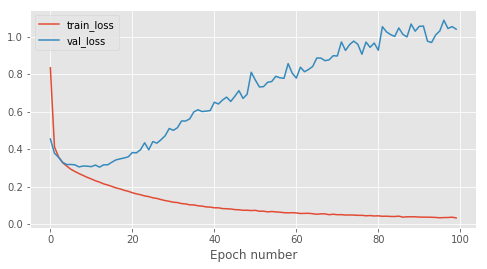

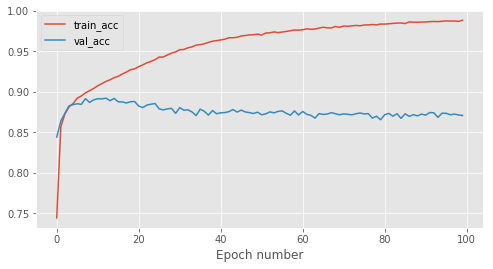

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 16, 16])


loss: 3.8524, accuracy: 0.0000:   0%|          | 2/1000 [00:00<01:05, 15.28it/s]

torch.Size([100, 64, 16, 16])
torch.Size([100, 64, 8, 8])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(3, 3))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(4, 4))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

loss: 0.4643, accuracy: 0.8400:   0%|          | 2/1000 [00:00<01:06, 15.02it/s]

Epoch 0: train_acc_0.7347_train_loss_0.8543_val_acc_0.8391_val_loss_0.4381 epoch time 74.5556 seconds
total time1.0 : 14.555582284927368


loss: 0.3513, accuracy: 0.9000:   0%|          | 1/1000 [00:00<01:05, 15.25it/s]

Epoch 1: train_acc_0.8553_train_loss_0.4100_val_acc_0.8590_val_loss_0.3879 epoch time 74.4597 seconds
total time2.0 : 29.01532554626465


KeyboardInterrupt: 

In [9]:
#dilated
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [1,1,1,1]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [1,2,3,4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("dilated_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

In [5]:
#dilated
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [1]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = [4]
experiment_name = []
for layer in num_layers:
    experiment_name.append("dilated_convolution_layer_{}".format(layer))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,layer in zip(dim_reduction_idx,experiment_name,num_layers):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=layer, use_bias=True)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f8af076b7f0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f8aef86ce80>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f8aef86c4e0>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 26, 26])
torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 22, 22])
torch.Size([100, 64, 16, 16])
torch.Size([100, 64, 16, 16])
torch.Size([100, 64, 8, 8])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


  0%|          | 0/1000 [00:00<?, ?it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(3, 3))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(4, 4))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_dilated_conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(5, 5))
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.5595, accuracy: 0.8600: 100%|██████████| 158/158 [00:04<00:00, 38.90it/s]


Epoch 0: train_acc_0.7130_train_loss_0.9372_val_acc_0.8492_val_loss_0.4483 epoch time 76.4526 seconds
total time1.0 : 16.45258855819702


loss: 0.2848, accuracy: 0.9000:   0%|          | 2/1000 [00:00<01:08, 14.48it/s]

Epoch 1: train_acc_0.8521_train_loss_0.4223_val_acc_0.8655_val_loss_0.3826 epoch time 76.1395 seconds
total time2.0 : 32.59209442138672


loss: 0.2564, accuracy: 0.8900:   0%|          | 2/1000 [00:00<01:09, 14.46it/s]

Epoch 2: train_acc_0.8704_train_loss_0.3630_val_acc_0.8764_val_loss_0.3459 epoch time 75.9943 seconds
total time3.0 : 48.58635854721069


loss: 0.2716, accuracy: 0.8600:   0%|          | 2/1000 [00:00<01:08, 14.50it/s]

Epoch 3: train_acc_0.8782_train_loss_0.3312_val_acc_0.8746_val_loss_0.3468 epoch time 76.1337 seconds
total time5.0 : 4.720061540603638


loss: 0.2196, accuracy: 0.9300:   0%|          | 2/1000 [00:00<01:09, 14.44it/s]

Epoch 4: train_acc_0.8852_train_loss_0.3084_val_acc_0.8833_val_loss_0.3266 epoch time 75.8935 seconds
total time6.0 : 20.6135151386261


loss: 0.2576, accuracy: 0.8800:   0%|          | 2/1000 [00:00<01:08, 14.57it/s]

Epoch 5: train_acc_0.8901_train_loss_0.2903_val_acc_0.8851_val_loss_0.3134 epoch time 75.9526 seconds
total time7.0 : 36.56610894203186


loss: 0.2450, accuracy: 0.8600:   0%|          | 2/1000 [00:00<01:09, 14.38it/s]

Epoch 6: train_acc_0.8950_train_loss_0.2758_val_acc_0.8869_val_loss_0.3113 epoch time 75.8677 seconds
total time8.0 : 52.43379998207092


loss: 0.1427, accuracy: 0.9500:   0%|          | 2/1000 [00:00<01:08, 14.61it/s]

Epoch 7: train_acc_0.8986_train_loss_0.2628_val_acc_0.8906_val_loss_0.3061 epoch time 75.3983 seconds
total time10.0 : 7.832078695297241


loss: 0.1488, accuracy: 0.9200:   0%|          | 2/1000 [00:00<01:07, 14.75it/s]

Epoch 8: train_acc_0.9028_train_loss_0.2491_val_acc_0.8889_val_loss_0.3116 epoch time 75.0436 seconds
total time11.0 : 22.875661849975586


loss: 0.3152, accuracy: 0.8800:   0%|          | 2/1000 [00:00<01:08, 14.64it/s]

Epoch 9: train_acc_0.9054_train_loss_0.2390_val_acc_0.8835_val_loss_0.3307 epoch time 75.0907 seconds
total time12.0 : 37.96632409095764


loss: 0.2242, accuracy: 0.9200:  32%|███▏      | 322/1000 [00:22<00:48, 14.02it/s]


KeyboardInterrupt: 

In [ ]:
#stride2_filter32_layer1234_type0